In [1]:
from google.cloud import bigquery

In [2]:
import pandas as pd

In [3]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/arossi/Downloads/steam-shape-278619-3b26e69d872b.json'

In [4]:
client = bigquery.Client() #project='steam-shape-278619', credentials='3b26e69d872b095360b043c503e29be1ae1cae6a')

In [5]:
query_job = client.query(
    """SELECT start_time as start_time, end_time-start_time as intervall, instance_index as instance_index, average_usage.cpus as pavgcpu, average_usage.memory as pavgmem, maximum_usage.cpus as pmaxcpu, maximum_usage.memory as pmaxmem
FROM `google.com:google-cluster-data`.clusterdata_2019_h.instance_usage
WHERE collection_type=0
LIMIT 10"""
)

results = query_job.result()  # Waits for job to complete.

SELECT CAST(start_time/300000000 as int) as slot, SUM(intervall/1000000) as intervall, COUNT(instance_index) as counts, SUM(pavgcpu * intervall) as avgcpu, SUM(pavgmem * intervall) as avgmem, SUM(pmaxcpu * intervall) as maxcpu, SUM(pmaxmem * intervall) as maxmem
FROM 
(SELECT start_time as start_time, end_time-start_time as intervall, instance_index as instance_index, average_usage.cpus as pavgcpu, average_usage.memory as pavgmem, maximum_usage.cpus as pmaxcpu, maximum_usage.memory as pmaxmem
FROM `google.com:google-cluster-data`.clusterdata_2019_h.instance_usage
WHERE collection_type=0)
GROUP BY slot
ORDER BY slot

In [ ]:
for row in results:
    print("{} : {} views".format(row.start_time, row.intervall))

In [8]:
df = results.to_dataframe()

In [9]:
df

,start_time,intervall,instance_index,pavgcpu,pavgmem,pmaxcpu,pmaxmem
0,37401000000,99000000,357,0.000322,0.000654,0.009888,0.000695
1,2074500000000,300000000,2582,0.000113,0.000427,0.000777,0.000428
2,2535900000000,264000000,2582,0.000146,0.000592,0.000680,0.000593
3,47100000000,300000000,423,0.000111,0.000748,0.002056,0.000757
4,114600000000,156000000,423,0.000125,0.000751,0.001032,0.000755
5,12900000000,300000000,423,0.004410,0.000821,0.037109,0.000834
6,8100000000,300000000,423,0.000080,0.000630,0.001648,0.000634
7,2535474000000,3000000,617,0.000014,0.000028,0.001318,0.000028
8,2226300000000,300000000,2087,0.000099,0.000424,0.001720,0.000425
9,2278800000000,300000000,2087,0.000121,0.000427,0.001240,0.000429


In [15]:
query_machine = """SELECT time, machine_id, capacity.cpus as cpu, capacity.memory as memory
FROM `google.com:google-cluster-data`.clusterdata_2019_a.machine_events 
ORDER BY time
"""

In [21]:
all_machines_query = """SELECT DISTINCT machine_id 
FROM `google.com:google-cluster-data`.clusterdata_2019_a.machine_events 
ORDER BY machine_id"""
query_job = client.query(all_machines_query)

machines = query_job.result().to_dataframe()  # Waits for job to complete.
machines

,machine_id
0,20731766
1,20732703
2,20732904
3,20732905
4,20732906
...,...
9996,400224371858
9997,400224405682
9998,400224536580
9999,400227566035


In [ ]:
machines.to_csv("/Users/arossi/Desktop/BigQuery/machines_a.csv"")

In [30]:
for machine in machines.machine_id:
    query_machine = """SELECT CAST(start_time/300000000 as int) as slot, SUM(intervall/1000000) as intervall, COUNT(instance_index) as counts, SUM(pavgcpu * intervall) as avgcpu, SUM(pavgmem * intervall) as avgmem, SUM(pmaxcpu * intervall) as maxcpu, SUM(pmaxmem * intervall) as maxmem
FROM 
(SELECT machine_id, start_time as start_time, end_time-start_time as intervall, instance_index as instance_index, average_usage.cpus as pavgcpu, average_usage.memory as pavgmem, maximum_usage.cpus as pmaxcpu, maximum_usage.memory as pmaxmem
FROM `google.com:google-cluster-data`.clusterdata_2019_a.instance_usage
WHERE machine_id = """+ str(machine)+""")
GROUP BY slot
ORDER BY slot
"""
    query_job = client.query(query_machine)

    machine_df = query_job.result().to_dataframe()  # Waits for job to complete.
#     if machine_df.shape[0]:
    print(machine, machine_df)
    machine_df.to_csv("/Users/arossi/Desktop/BigQuery/machine_"+str(machine).zfill(12)+".csv")
#         input()

20731766       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    13987.0      47  1.028484e+08  8.148647e+07  3.545550e+08   
1        2    14663.0      52  1.004543e+08  8.370961e+07  3.927795e+08   
2        3    14897.0      52  1.051757e+08  8.350093e+07  3.664314e+08   
3        4    14718.0      50  8.944999e+07  8.383458e+07  4.596418e+08   
4        5    14782.0      50  1.247465e+08  8.440438e+07  3.981059e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8925     7885.0      28  1.533029e+08  5.510212e+07  4.144526e+08   
8916  8926     7802.0      29  1.598051e+08  6.211762e+07  3.896964e+08   
8917  8927     7643.0      34  1.505121e+08  5.405676e+07  5.180116e+08   
8918  8928     7949.0      29  1.574418e+08  5.746873e+07  3.430378e+08   
8919  8929     7800.0      28  1.625919e+08  5.655024e+07  4.061985e+08   

            maxmem  
0     8.482300e+07  
1     8.579963e+07  
2     8.566796e+07  
3     

20733594       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    13720.0      46  1.328487e+08  7.942667e+07  3.670820e+08   
1        2    14483.0      53  5.576316e+07  7.875082e+07  2.745174e+08   
2        3    14417.0      51  4.881217e+07  7.587695e+07  2.186359e+08   
3        4    14798.0      54  1.132059e+08  7.739591e+07  3.111831e+08   
4        5    14927.0      59  1.209288e+08  7.864272e+07  4.174336e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    15964.0      80  1.707836e+08  9.019755e+07  5.742224e+08   
8916  8927    16710.0     104  2.020784e+08  1.156207e+08  6.319520e+08   
8917  8928    15393.0      75  2.100610e+08  1.133136e+08  5.494673e+08   
8918  8929    14041.0      79  1.580736e+08  8.509869e+07  4.961097e+08   
8919  8930      671.0      18  3.370170e+06  2.292555e+06  1.515003e+07   

            maxmem  
0     8.176212e+07  
1     8.144121e+07  
2     8.058936e+07  
3     

20733601       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    19771.0      67  9.348231e+07  8.146103e+07  4.227306e+08   
1        2    20414.0      70  1.058042e+08  8.774323e+07  4.938599e+08   
2        3    20417.0      69  1.048439e+08  8.639111e+07  5.276330e+08   
3        4    20397.0      69  1.100993e+08  8.617226e+07  4.153495e+08   
4        5    19950.0      73  1.307906e+08  8.942939e+07  4.754078e+08   
...    ...        ...     ...           ...           ...           ...   
8913  8926    16250.0      76  1.222062e+08  1.032756e+08  4.384892e+08   
8914  8927    16632.0     101  1.443170e+08  1.213136e+08  5.606980e+08   
8915  8928    16569.0      68  1.517110e+08  1.321668e+08  4.980737e+08   
8916  8929    16593.0      64  1.442573e+08  1.223178e+08  4.541376e+08   
8917  8930      478.0      26  2.517538e+06  2.059865e+06  1.136596e+07   

            maxmem  
0     8.799407e+07  
1     9.195021e+07  
2     9.480913e+07  
3     

20733612       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    14400.0      48  1.385499e+08  7.870874e+07  4.733720e+08   
1        2    15575.0      58  1.335569e+08  8.049189e+07  4.536416e+08   
2        3    15137.0      59  1.227211e+08  7.999357e+07  3.677612e+08   
3        4    14776.0      51  8.437660e+07  8.026473e+07  3.011299e+08   
4        5    14842.0      54  1.133504e+08  8.096902e+07  5.442392e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    21054.0      90  1.345552e+08  7.433685e+07  4.825567e+08   
8920  8927    20742.0      95  1.055345e+08  6.060177e+07  3.756575e+08   
8921  8928    21050.0      98  1.320848e+08  7.409262e+07  4.392226e+08   
8922  8929    20447.0      91  1.046946e+08  6.287350e+07  4.068536e+08   
8923  8930      868.0      12  7.195426e+06  1.710542e+06  2.176732e+07   

            maxmem  
0     8.200006e+07  
1     8.394633e+07  
2     8.351772e+07  
3     

20733622       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16830.0      57  1.476389e+08  9.012836e+07  4.547207e+08   
1        2    18410.0      66  1.168255e+08  9.165928e+07  3.606249e+08   
2        3    18316.0      66  1.022718e+08  8.915086e+07  5.087588e+08   
3        4    18771.0      67  1.354205e+08  9.510138e+07  5.483716e+08   
4        5    18530.0      65  1.347756e+08  9.341191e+07  4.303667e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    20349.0      94  1.591306e+08  9.130360e+07  5.729835e+08   
8918  8927    18705.0     106  1.380891e+08  8.157509e+07  4.530154e+08   
8919  8928    19900.0      87  1.909616e+08  1.114743e+08  6.053600e+08   
8920  8929    18821.0      82  1.611691e+08  9.141928e+07  4.941890e+08   
8921  8930      265.0      22  2.868805e+06  3.530054e+05  7.705018e+06   

            maxmem  
0     9.360060e+07  
1     9.535995e+07  
2     9.226279e+07  
3     

20734325       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15300.0      51  1.346666e+08  7.818460e+07  3.713991e+08   
1        2    16049.0      57  1.142213e+08  8.634681e+07  4.086597e+08   
2        3    15786.0      59  1.234006e+08  8.514681e+07  3.931258e+08   
3        4    15081.0      57  1.301700e+08  8.180037e+07  3.807837e+08   
4        5    14767.0      52  1.410014e+08  8.180336e+07  3.418683e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    17136.0      65  1.291703e+08  8.490724e+07  3.649519e+08   
8918  8927    17325.0      74  1.432257e+08  8.741980e+07  4.624135e+08   
8919  8928    18271.0      87  1.683200e+08  9.569054e+07  5.600275e+08   
8920  8929    16445.0      84  1.378535e+08  8.248465e+07  3.834603e+08   
8921  8930      503.0      18  4.268812e+06  2.223477e+06  1.161718e+07   

            maxmem  
0     8.353643e+07  
1     9.250568e+07  
2     8.934119e+07  
3     

20734339       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16800.0      56  8.064108e+07  7.555962e+07  2.951014e+08   
1        2    17973.0      65  9.360702e+07  7.607943e+07  3.404910e+08   
2        3    17650.0      60  8.889486e+07  7.197845e+07  4.429443e+08   
3        4    18133.0      70  1.139393e+08  8.039942e+07  5.898234e+08   
4        5    17659.0      64  1.269341e+08  8.272156e+07  4.113254e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    18863.0      74  1.413549e+08  8.950507e+07  4.240870e+08   
8920  8927    17774.0      80  1.404197e+08  8.403573e+07  4.115429e+08   
8921  8928    18497.0      83  1.347516e+08  7.599921e+07  4.119202e+08   
8922  8929    18147.0      85  1.454560e+08  8.076582e+07  4.523727e+08   
8923  8930      224.0       4  3.768646e+06  4.552584e+05  8.938843e+06   

            maxmem  
0     8.104649e+07  
1     8.079433e+07  
2     7.760169e+07  
3     

20736634       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16759.0      56  1.402718e+08  8.113513e+07  4.631069e+08   
1        2    17319.0      62  1.397886e+08  9.230437e+07  4.357890e+08   
2        3    16957.0      58  1.255457e+08  8.575590e+07  3.825415e+08   
3        4    17118.0      59  1.438020e+08  8.811689e+07  4.281119e+08   
4        5    17188.0      59  1.478929e+08  8.627143e+07  5.290626e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    22279.0      79  1.146417e+08  7.710016e+07  4.151789e+08   
8919  8927    22402.0      93  1.254501e+08  7.437323e+07  4.688078e+08   
8920  8928    23727.0      95  1.101975e+08  6.720727e+07  4.371078e+08   
8921  8929    23061.0     105  1.247667e+08  7.994767e+07  7.801816e+08   
8922  8930      167.0       6  4.376221e+04  2.524347e+05  7.965269e+05   

            maxmem  
0     8.811170e+07  
1     9.670058e+07  
2     9.260377e+07  
3     

20736641       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    14197.0      48  1.014469e+08  7.840170e+07  3.677385e+08   
1        2    15955.0      61  9.184010e+07  7.903203e+07  3.104708e+08   
2        3    16017.0      65  9.986039e+07  7.991291e+07  4.996450e+08   
3        4    15940.0      57  1.282358e+08  8.426639e+07  4.247706e+08   
4        5    16232.0      60  1.184170e+08  8.397251e+07  4.406400e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    16023.0      71  1.970260e+08  1.200332e+08  7.370034e+08   
8919  8927    16452.0      81  1.964005e+08  1.117953e+08  6.064691e+08   
8920  8928    15786.0      85  1.773836e+08  9.787376e+07  5.379121e+08   
8921  8929    15617.0      89  1.856123e+08  8.655833e+07  5.539731e+08   
8922  8930      786.0      22  5.006933e+06  2.445655e+06  1.968312e+07   

            maxmem  
0     8.151904e+07  
1     8.198079e+07  
2     8.632391e+07  
3     

20736652       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15230.0      51  1.007707e+08  8.540012e+07  3.509692e+08   
1        2    15300.0      51  1.048456e+08  8.771524e+07  3.916852e+08   
2        3    15170.0      51  1.044008e+08  8.457470e+07  5.507795e+08   
3        4    15422.0      53  8.698553e+07  9.004565e+07  4.506583e+08   
4        5    14909.0      54  1.203718e+08  8.720580e+07  3.841496e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    15683.0      78  1.452875e+08  9.165545e+07  4.936501e+08   
8918  8927    14727.0      80  1.553391e+08  1.030188e+08  6.184400e+08   
8919  8928    15538.0      76  1.606341e+08  1.079538e+08  6.649959e+08   
8920  8929    14912.0      79  1.434741e+08  1.065650e+08  5.441655e+08   
8921  8930      230.0      20  2.750094e+06  2.689943e+05  9.221654e+06   

            maxmem  
0     9.039896e+07  
1     9.010677e+07  
2     8.828884e+07  
3     

20736661       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15848.0      53  7.794687e+07  7.458767e+07  3.467404e+08   
1        2    17718.0      65  1.066166e+08  8.288828e+07  1.004830e+09   
2        3    17035.0      63  7.936695e+07  7.632850e+07  3.261845e+08   
3        4    16870.0      62  6.169107e+07  7.556002e+07  2.901789e+08   
4        5    16661.0      69  1.050616e+08  7.800109e+07  3.225238e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    18492.0      66  1.691847e+08  1.059970e+08  5.653114e+08   
8917  8927    18734.0      78  1.585861e+08  9.894874e+07  5.151564e+08   
8918  8928    19302.0      83  1.700160e+08  9.732414e+07  6.104867e+08   
8919  8929    18681.0      86  1.845143e+08  1.025748e+08  5.874497e+08   
8920  8930      267.0       7  1.495939e+06  5.035458e+05  4.694031e+06   

            maxmem  
0     7.840170e+07  
1     8.713036e+07  
2     8.099738e+07  
3     

20736668       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16370.0      55  1.219699e+08  7.650103e+07  4.303219e+08   
1        2    17432.0      62  7.221130e+07  7.516650e+07  3.735578e+08   
2        3    17726.0      62  8.342382e+07  7.543253e+07  3.956206e+08   
3        4    17748.0      62  1.016601e+08  7.498052e+07  3.502299e+08   
4        5    17728.0      64  9.801757e+07  7.639047e+07  3.654827e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    19621.0      85  1.736362e+08  1.025994e+08  5.239683e+08   
8917  8927    19329.0      86  1.666834e+08  9.498448e+07  5.477335e+08   
8918  8928    19624.0     105  1.726662e+08  1.005019e+08  5.465220e+08   
8919  8929    19126.0      86  1.518411e+08  8.971785e+07  5.004100e+08   
8920  8930      670.0      16  6.127039e+06  2.013048e+06  1.745984e+07   

            maxmem  
0     7.906298e+07  
1     7.850151e+07  
2     7.888796e+07  
3     

20736676       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16200.0      54  1.185534e+08  8.629217e+07  4.777210e+08   
1        2    16572.0      62  1.611029e+08  8.772134e+07  4.753829e+08   
2        3    16500.0      56  1.648713e+08  8.778473e+07  4.072952e+08   
3        4    16438.0      56  1.532141e+08  8.734507e+07  4.797911e+08   
4        5    16562.0      56  1.434348e+08  8.810851e+07  4.102949e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    18835.0      84  8.994939e+07  6.799464e+07  4.191586e+08   
8919  8927    20721.0     138  1.127857e+08  7.207282e+07  4.103103e+08   
8920  8928    18837.0      91  1.102060e+08  6.886322e+07  4.358985e+08   
8921  8929    18336.0      94  1.572980e+08  8.092084e+07  4.960790e+08   
8922  8930      639.0      12  2.125830e+06  1.731565e+06  6.807304e+06   

            maxmem  
0     8.956461e+07  
1     8.998968e+07  
2     9.098597e+07  
3     

20736683       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    10473.0      35  1.193219e+08  8.309758e+07  5.299233e+08   
1        2    10777.0      37  1.418775e+08  8.866154e+07  4.379333e+08   
2        3    10954.0      38  1.406972e+08  8.812719e+07  4.457418e+08   
3        4    11149.0      41  1.473395e+08  8.592194e+07  4.813320e+08   
4        5    11100.0      37  1.588411e+08  9.105005e+07  5.037217e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    20446.0      82  1.416428e+08  8.351217e+07  4.526133e+08   
8919  8927    19021.0     113  1.254986e+08  7.452275e+07  4.399574e+08   
8920  8928    19525.0     107  1.305455e+08  7.682998e+07  4.578365e+08   
8921  8929    19086.0      88  1.564768e+08  9.068320e+07  4.719132e+08   
8922  8930       80.0       1  3.613281e+05  3.430176e+05  1.787109e+06   

            maxmem  
0     8.938487e+07  
1     9.250467e+07  
2     9.304840e+07  
3     

20736694       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16458.0      55  1.162045e+08  7.517045e+07  5.248585e+08   
1        2    18731.0      69  1.002554e+08  7.894231e+07  3.835779e+08   
2        3    18271.0      63  1.076854e+08  7.774355e+07  3.415127e+08   
3        4    18667.0      73  1.109427e+08  7.686092e+07  3.208223e+08   
4        5    18684.0      70  1.300640e+08  7.348900e+07  3.802064e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    13627.0      50  1.816083e+08  1.007579e+08  6.425014e+08   
8916  8927    13861.0     111  1.767829e+08  1.050607e+08  6.035727e+08   
8917  8928    13679.0      59  1.755309e+08  1.115713e+08  5.697243e+08   
8918  8929    12830.0      55  1.785716e+08  1.171209e+08  6.710927e+08   
8919  8930      321.0      26  9.164686e+05  3.070621e+05  3.364497e+06   

            maxmem  
0     7.959008e+07  
1     8.319789e+07  
2     8.360642e+07  
3     

20736702       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    30000.0     100  6.560755e+07  6.811638e+07  2.395005e+08   
1        2    30000.0     100  7.402067e+07  6.805544e+07  3.088374e+08   
2        3    30000.0     100  7.081318e+07  6.784887e+07  2.481314e+08   
3        4    30000.0     100  7.028818e+07  6.779079e+07  2.649170e+08   
4        5    30000.0     100  7.978992e+07  7.166319e+07  2.650904e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    19710.0      79  1.408914e+08  8.924943e+07  4.594147e+08   
8917  8927    19481.0     106  1.263763e+08  8.899366e+07  4.192152e+08   
8918  8928    20015.0      83  1.571055e+08  1.012703e+08  4.831246e+08   
8919  8929    20022.0      91  1.612569e+08  9.696412e+07  5.411690e+08   
8920  8930      356.0      10  4.717670e+06  7.007446e+05  8.497605e+06   

            maxmem  
0     6.994085e+07  
1     6.852694e+07  
2     6.808405e+07  
3     

20736712       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15797.0      53  5.253477e+07  7.733081e+07  2.616080e+08   
1        2    16260.0      58  7.454231e+07  7.641977e+07  4.562302e+08   
2        3    15082.0      69  6.796725e+07  7.544358e+07  3.134855e+08   
3        4    15086.0      55  1.047213e+08  7.615458e+07  4.230512e+08   
4        5    15000.0      50  1.217866e+08  7.865496e+07  4.502769e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    16259.0      59  1.621650e+08  8.357853e+07  5.368662e+08   
8920  8927    16427.0      78  1.584131e+08  1.032246e+08  5.255481e+08   
8921  8928    14942.0      58  1.286059e+08  8.858604e+07  3.923147e+08   
8922  8929    15570.0      59  1.493320e+08  9.435694e+07  3.743869e+08   
8923  8930       56.0       3  2.361488e+04  5.282402e+03  1.153984e+05   

            maxmem  
0     8.026288e+07  
1     7.885125e+07  
2     7.828403e+07  
3     

20736726       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15072.0      51  1.420217e+08  7.450745e+07  4.533739e+08   
1        2    16981.0      68  1.462195e+08  7.708168e+07  4.588673e+08   
2        3    16657.0      71  1.401289e+08  7.626589e+07  4.831302e+08   
3        4    16400.0      59  1.273423e+08  7.672715e+07  3.669126e+08   
4        5    16541.0      58  1.264941e+08  7.822067e+07  3.549044e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    19007.0      80  1.911531e+08  1.029072e+08  6.048921e+08   
8917  8927    17772.0     107  1.667112e+08  8.844416e+07  5.927818e+08   
8918  8928    17626.0      94  1.621127e+08  9.133004e+07  5.879944e+08   
8919  8929    17672.0      80  1.879320e+08  1.004556e+08  5.422756e+08   
8920  8930      180.0       9  5.369005e+05  2.479610e+05  2.169381e+06   

            maxmem  
0     7.845148e+07  
1     7.972474e+07  
2     7.972138e+07  
3     

20736735       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17592.0      59  1.317497e+08  7.920983e+07  4.658498e+08   
1        2    18556.0      67  8.254441e+07  8.124615e+07  2.833536e+08   
2        3    18793.0      66  1.153663e+08  8.114644e+07  3.152395e+08   
3        4    18476.0      66  1.347672e+08  7.882553e+07  5.538827e+08   
4        5    18724.0      64  1.488686e+08  8.398919e+07  4.553583e+08   
...    ...        ...     ...           ...           ...           ...   
8920  8926    13847.0      51  2.020795e+08  1.269688e+08  6.478795e+08   
8921  8927    13864.0     105  1.827579e+08  1.069066e+08  6.264899e+08   
8922  8928    13260.0      66  2.079653e+08  1.326686e+08  5.810247e+08   
8923  8929    12800.0      46  2.040640e+08  1.248221e+08  5.966580e+08   
8924  8930      577.0      47  1.447700e+06  4.773769e+05  5.259643e+06   

            maxmem  
0     8.502076e+07  
1     8.673536e+07  
2     8.630401e+07  
3     

20736885       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15559.0      53  1.117943e+08  7.330559e+07  3.620017e+08   
1        2    16717.0      63  8.814866e+07  7.380582e+07  3.043831e+08   
2        3    16358.0      66  7.681659e+07  7.224254e+07  3.026292e+08   
3        4    16906.0      64  9.870369e+07  7.702100e+07  3.336528e+08   
4        5    16998.0      64  1.256471e+08  7.727487e+07  3.996681e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    17331.0      64  1.835760e+08  1.108934e+08  5.904206e+08   
8916  8927    17025.0      94  1.600054e+08  9.834713e+07  6.278688e+08   
8917  8928    15569.0      69  1.914279e+08  1.096152e+08  5.853563e+08   
8918  8929    15410.0      64  1.792354e+08  9.819526e+07  5.774159e+08   
8919  8930      457.0      10  4.615360e+06  8.806591e+05  1.171141e+07   

            maxmem  
0     7.889641e+07  
1     7.773863e+07  
2     7.777442e+07  
3     

20736897       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    14700.0      49  1.383986e+08  7.943230e+07  4.571222e+08   
1        2    14551.0      50  1.309571e+08  8.013006e+07  3.917559e+08   
2        3    14287.0      55  1.219578e+08  7.773285e+07  3.562884e+08   
3        4    14100.0      47  1.175111e+08  7.576132e+07  3.521971e+08   
4        5    14002.0      47  1.168974e+08  7.389660e+07  3.703368e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    15497.0      66  1.788010e+08  1.013024e+08  5.046026e+08   
8917  8927    16427.0      70  1.798283e+08  1.203027e+08  7.046184e+08   
8918  8928    16005.0      58  1.802018e+08  1.221826e+08  6.151950e+08   
8919  8929    15261.0      62  1.737547e+08  9.357993e+07  5.220554e+08   
8920  8930      617.0      11  2.748481e+06  2.174870e+06  1.594124e+07   

            maxmem  
0     8.453178e+07  
1     8.262115e+07  
2     8.032433e+07  
3     

20736910       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15332.0      52  1.140282e+08  7.333661e+07  4.967150e+08   
1        2    17965.0      81  7.227532e+07  7.686050e+07  3.206572e+08   
2        3    18435.0      95  9.155059e+07  7.613315e+07  3.582499e+08   
3        4    18278.0      81  1.028330e+08  7.909380e+07  4.727545e+08   
4        5    17786.0      71  1.212174e+08  8.285574e+07  4.874188e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    20995.0      95  1.087390e+08  7.145159e+07  4.437695e+08   
8918  8927    21208.0      96  1.479738e+08  9.053677e+07  5.340592e+08   
8919  8928    21265.0      83  1.328433e+08  8.775862e+07  4.575822e+08   
8920  8929    20702.0      87  1.575603e+08  9.846161e+07  5.585457e+08   
8921  8930      198.0      12  2.708302e+05  3.842373e+05  7.550802e+05   

            maxmem  
0     7.829224e+07  
1     8.271374e+07  
2     8.032128e+07  
3     

20736917       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    13395.0      45  7.097414e+07  1.035950e+08  2.398714e+08   
1        2    13565.0      49  6.129385e+07  1.053753e+08  2.073993e+08   
2        3    13451.0      50  5.926626e+07  1.027147e+08  2.729217e+08   
3        4    14035.0      50  6.647349e+07  1.025966e+08  2.293179e+08   
4        5    14225.0      52  7.752578e+07  1.068590e+08  3.473058e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    17690.0      62  1.599787e+08  1.043758e+08  4.805223e+08   
8918  8927    16582.0      90  1.346832e+08  7.040792e+07  3.913683e+08   
8919  8928    18275.0      67  1.661069e+08  8.556571e+07  5.187010e+08   
8920  8929    18014.0      73  1.444161e+08  8.557929e+07  4.616269e+08   
8921  8930      278.0       5  2.625694e+06  1.630971e+06  9.099802e+06   

            maxmem  
0     8.535702e+07  
1     8.704356e+07  
2     1.063704e+08  
3     

20736925       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16200.0      54  1.150560e+08  8.389549e+07  3.445046e+08   
1        2    16364.0      57  1.114571e+08  8.365253e+07  4.324846e+08   
2        3    16312.0      59  1.346188e+08  8.507730e+07  4.301584e+08   
3        4    16076.0      54  1.235368e+08  8.458541e+07  4.705223e+08   
4        5    16288.0      55  1.270449e+08  8.702894e+07  4.321987e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    10629.0      54  2.071714e+08  1.238248e+08  7.867388e+08   
8917  8927    10574.0      59  1.974183e+08  1.225605e+08  6.057541e+08   
8918  8928    11233.0      47  2.025205e+08  1.232116e+08  7.319391e+08   
8919  8929    11208.0      47  2.066004e+08  1.178222e+08  5.801389e+08   
8920  8930       58.0       2  7.113934e+04  1.083794e+05  3.930988e+05   

            maxmem  
0     8.943558e+07  
1     8.799377e+07  
2     8.872886e+07  
3     

20736934       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15900.0      53  1.099866e+08  8.718252e+07  3.339077e+08   
1        2    16292.0      56  9.729038e+07  9.050305e+07  3.140678e+08   
2        3    16048.0      56  1.125324e+08  8.741150e+07  3.623552e+08   
3        4    15802.0      60  1.121923e+08  8.930368e+07  3.774219e+08   
4        5    15458.0      52  9.995300e+07  9.074656e+07  3.326869e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    14291.0      66  1.854146e+08  1.053883e+08  6.581765e+08   
8918  8927    13976.0      75  1.757267e+08  9.546503e+07  5.573759e+08   
8919  8928    16224.0      84  1.876748e+08  1.137755e+08  6.567684e+08   
8920  8929    14661.0      66  1.876004e+08  1.134250e+08  5.529267e+08   
8921  8930      464.0      17  8.098011e+05  2.445440e+05  2.909439e+06   

            maxmem  
0     9.337206e+07  
1     9.481828e+07  
2     9.290187e+07  
3     

20736941       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17100.0      57  1.063253e+08  8.242922e+07  3.506616e+08   
1        2    18020.0      63  1.105453e+08  8.397944e+07  4.040001e+08   
2        3    18256.0      73  1.124254e+08  8.415521e+07  4.799625e+08   
3        4    17716.0      67  1.254142e+08  8.405959e+07  4.222055e+08   
4        5    17002.0      66  1.058914e+08  8.338633e+07  2.987572e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    20292.0      98  1.647339e+08  1.055672e+08  5.611229e+08   
8916  8927    19657.0      80  1.444884e+08  8.106601e+07  5.511326e+08   
8917  8928    20884.0     103  1.546695e+08  1.018824e+08  6.166673e+08   
8918  8929    18807.0      98  1.356317e+08  8.769813e+07  8.568048e+08   
8919  8930      618.0      24  2.543369e+06  1.899668e+06  1.746146e+07   

            maxmem  
0     8.655367e+07  
1     8.717435e+07  
2     8.875493e+07  
3     

20736949       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15610.0      53  9.859818e+07  7.387925e+07  4.891318e+08   
1        2    16468.0      59  1.134050e+08  7.927460e+07  4.646965e+08   
2        3    16597.0      58  1.140823e+08  8.027224e+07  3.896948e+08   
3        4    16460.0      57  1.133854e+08  7.742948e+07  4.448400e+08   
4        5    16606.0      58  1.265066e+08  8.150667e+07  4.329245e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    21164.0      87  1.061137e+08  6.543085e+07  4.179011e+08   
8919  8927    21722.0     121  1.187087e+08  6.833882e+07  4.554973e+08   
8920  8928    21457.0      90  1.204973e+08  7.038469e+07  4.737608e+08   
8921  8929    21160.0      73  1.303263e+08  7.788855e+07  4.444786e+08   
8922  8930      410.0      12  1.491612e+06  7.386713e+05  2.919284e+06   

            maxmem  
0     8.183465e+07  
1     8.631711e+07  
2     8.898059e+07  
3     

20736958       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17555.0      59  1.247035e+08  7.891992e+07  3.759425e+08   
1        2    17561.0      60  9.563684e+07  7.727408e+07  4.202782e+08   
2        3    17843.0      66  1.080864e+08  7.417179e+07  3.988195e+08   
3        4    17555.0      59  1.250351e+08  7.747037e+07  5.474368e+08   
4        5    17845.0      61  1.156536e+08  7.542536e+07  3.896613e+08   
...    ...        ...     ...           ...           ...           ...   
8914  8926    22365.0      84  9.706190e+07  7.210136e+07  4.621355e+08   
8915  8927    21703.0      96  8.641804e+07  6.892985e+07  3.991886e+08   
8916  8928    22889.0      96  9.597774e+07  7.308250e+07  5.142771e+08   
8917  8929    22314.0      82  9.592394e+07  6.978042e+07  3.918010e+08   
8918  8930      199.0       4  1.027014e+06  5.442333e+05  2.171850e+06   

            maxmem  
0     8.353111e+07  
1     8.314675e+07  
2     8.149028e+07  
3     

20736966       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17595.0      59  8.563700e+07  7.485741e+07  3.030039e+08   
1        2    19531.0      70  1.005011e+08  7.866787e+07  4.096361e+08   
2        3    19347.0      70  1.050875e+08  7.564530e+07  6.730420e+08   
3        4    19388.0      68  1.141994e+08  7.851666e+07  4.139156e+08   
4        5    19624.0      68  8.429495e+07  7.981246e+07  2.967706e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    26210.0     105  1.070739e+08  7.788829e+07  4.510040e+08   
8920  8927    25253.0     109  1.152904e+08  7.665404e+07  6.194455e+08   
8921  8928    25501.0      99  1.072223e+08  7.957297e+07  4.778478e+08   
8922  8929    24980.0      95  1.107430e+08  7.650565e+07  5.026073e+08   
8923  8930      149.0       9  1.261760e+06  3.827419e+05  3.432495e+06   

            maxmem  
0     8.050821e+07  
1     8.386739e+07  
2     8.136071e+07  
3     

20736974       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17948.0      60  1.086873e+08  7.251597e+07  4.095881e+08   
1        2    18000.0      62  1.155310e+08  7.443199e+07  3.933192e+08   
2        3    17931.0      62  1.035169e+08  7.212435e+07  3.559417e+08   
3        4    18253.0      62  9.289693e+07  7.492415e+07  3.604939e+08   
4        5    18743.0      69  1.079618e+08  7.502776e+07  3.550506e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    18337.0      80  1.724737e+08  1.138229e+08  5.545746e+08   
8919  8927    17967.0      97  1.688161e+08  1.089276e+08  4.751003e+08   
8920  8928    18525.0     109  1.790770e+08  1.104186e+08  5.729920e+08   
8921  8929    17019.0      78  1.901112e+08  1.156816e+08  5.773004e+08   
8922  8930      188.0       6  8.800945e+05  3.103771e+05  2.914017e+06   

            maxmem  
0     7.807405e+07  
1     7.938814e+07  
2     7.722134e+07  
3     

20736986       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15496.0      52  9.184161e+07  7.576712e+07  3.432438e+08   
1        2    16657.0      60  1.189334e+08  7.675754e+07  7.493409e+08   
2        3    17144.0      64  1.030633e+08  7.692791e+07  4.298111e+08   
3        4    17065.0      67  7.711753e+07  8.033358e+07  2.952942e+08   
4        5    17627.0      68  1.071669e+08  7.822961e+07  4.699565e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    16863.0      76  1.683705e+08  8.535935e+07  5.477864e+08   
8920  8927    17936.0     112  1.471886e+08  8.415359e+07  5.472206e+08   
8921  8928    16960.0      70  1.624644e+08  9.481886e+07  5.036226e+08   
8922  8929    16573.0      88  1.564757e+08  8.945636e+07  5.610788e+08   
8923  8930      731.0      30  4.894749e+06  1.045735e+06  1.439113e+07   

            maxmem  
0     7.963216e+07  
1     8.004000e+07  
2     8.184830e+07  
3     

20736998       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16994.0      57  1.005101e+08  7.609681e+07  1.007980e+09   
1        2    17407.0      59  8.429955e+07  7.672207e+07  3.178169e+08   
2        3    17682.0      62  8.068175e+07  7.729199e+07  2.718024e+08   
3        4    17678.0      66  9.021559e+07  7.327002e+07  3.189227e+08   
4        5    17510.0      72  1.032604e+08  7.340237e+07  7.735063e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    23461.0      90  1.476140e+08  7.268075e+07  4.942168e+08   
8918  8927    23261.0     100  1.515537e+08  7.589747e+07  4.375049e+08   
8919  8928    23231.0      93  1.481229e+08  7.206756e+07  5.633863e+08   
8920  8929    22570.0      77  1.413248e+08  8.479351e+07  5.562968e+08   
8921  8930      230.0       2  3.948212e+04  3.345013e+05  1.975203e+05   

            maxmem  
0     8.395756e+07  
1     8.352844e+07  
2     8.290345e+07  
3     

20737005       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    21426.0      72  9.196724e+07  7.469520e+07  3.233159e+08   
1        2    21659.0      86  7.564940e+07  7.317139e+07  3.541045e+08   
2        3    21650.0      83  1.085577e+08  7.605905e+07  3.767843e+08   
3        4    21607.0      74  1.148322e+08  7.744381e+07  4.060559e+08   
4        5    21600.0      72  1.149430e+08  8.056011e+07  4.838141e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    17479.0      63  1.952433e+08  1.114293e+08  5.556904e+08   
8918  8927    17034.0      81  1.572570e+08  9.815207e+07  4.881219e+08   
8919  8928    17471.0      75  1.800600e+08  1.030452e+08  5.099749e+08   
8920  8929    17253.0      75  1.668653e+08  8.560817e+07  4.426150e+08   
8921  8930      661.0      24  1.785378e+06  1.594179e+06  9.960021e+06   

            maxmem  
0     7.919225e+07  
1     7.614374e+07  
2     8.090086e+07  
3     

20737015      slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0       1    15194.0      51  1.302883e+08  7.975650e+07  4.020105e+08   
1       2    16271.0      61  1.255476e+08  8.270863e+07  3.729746e+08   
2       3    16397.0      65  9.311645e+07  8.234556e+07  3.132592e+08   
3       4    16055.0      54  1.115175e+08  8.123995e+07  3.420660e+08   
4       5    16345.0      55  1.151698e+08  8.327889e+07  8.699959e+08   
..    ...        ...     ...           ...           ...           ...   
822   827     7814.0      31  1.496231e+08  8.400096e+07  4.113510e+08   
823   828     8114.0      33  1.502970e+08  8.599506e+07  3.429853e+08   
824   829     8057.0      29  1.533951e+08  8.638175e+07  1.999281e+09   
825   830     8630.0      30  1.519169e+08  8.562058e+07  3.029119e+08   
826   831     8700.0      29  1.525623e+08  8.694820e+07  3.706415e+08   

           maxmem  
0    8.334994e+07  
1    8.605596e+07  
2    8.559446e+07  
3    8.444529e+07  
4 

20737025       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17096.0      58  9.106428e+07  7.882032e+07  3.618290e+08   
1        2    18136.0      66  1.015325e+08  8.006535e+07  4.164777e+08   
2        3    18000.0      63  1.026929e+08  7.989115e+07  3.910047e+08   
3        4    17854.0      62  8.060761e+07  7.983210e+07  3.188153e+08   
4        5    18048.0      62  9.364785e+07  8.022903e+07  3.056318e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    15739.0      76  1.980546e+08  1.116357e+08  1.115277e+09   
8916  8927    15605.0      66  1.998737e+08  1.214939e+08  6.006944e+08   
8917  8928    15166.0      72  1.892920e+08  1.082967e+08  7.190730e+08   
8918  8929    14772.0      79  1.537500e+08  7.784247e+07  5.596986e+08   
8919  8930     1006.0      29  4.326801e+06  2.670568e+06  2.090412e+07   

            maxmem  
0     8.292585e+07  
1     8.371861e+07  
2     8.341973e+07  
3     

20737037       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17400.0      58  1.150011e+08  7.702217e+07  3.219569e+08   
1        2    18790.0      69  1.124996e+08  7.861588e+07  2.428865e+08   
2        3    18690.0      67  1.289249e+08  8.008562e+07  3.535888e+08   
3        4    18409.0      63  1.273530e+08  7.941911e+07  3.431968e+08   
4        5    18694.0      72  1.443469e+08  8.008826e+07  3.871821e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    19029.0      69  1.747688e+08  1.060194e+08  5.624936e+08   
8920  8927    18582.0      78  1.721798e+08  1.082804e+08  5.065901e+08   
8921  8928    18395.0      76  1.525275e+08  9.783013e+07  4.566094e+08   
8922  8929    17685.0     109  1.597106e+08  8.803107e+07  6.172891e+08   
8923  8930      442.0      20  1.229208e+06  7.697744e+05  4.124602e+06   

            maxmem  
0     8.163414e+07  
1     8.315538e+07  
2     8.417712e+07  
3     

20737048       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    14315.0      48  1.014000e+08  8.484949e+07  3.373492e+08   
1        2    15020.0      54  1.245171e+08  8.646471e+07  5.786797e+08   
2        3    15566.0      57  1.276462e+08  8.433728e+07  4.382470e+08   
3        4    15937.0      55  9.453318e+07  8.869550e+07  3.540192e+08   
4        5    15426.0      59  1.156144e+08  8.636443e+07  3.957832e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    18951.0      77  1.472586e+08  1.118773e+08  4.866326e+08   
8918  8927    18699.0      93  1.580508e+08  1.076285e+08  5.694939e+08   
8919  8928    18872.0      74  1.412768e+08  1.146645e+08  4.604305e+08   
8920  8929    18672.0      79  1.448646e+08  9.635351e+07  4.481986e+08   
8921  8930      490.0      18  1.295381e+06  1.051043e+06  1.167487e+07   

            maxmem  
0     8.782990e+07  
1     8.922471e+07  
2     8.668645e+07  
3     

20737059       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    12486.0      42  1.212695e+08  8.634643e+07  4.978953e+08   
1        2    12851.0      45  1.306737e+08  8.782522e+07  3.773613e+08   
2        3    12886.0      45  1.305470e+08  8.370722e+07  5.068101e+08   
3        4    12981.0      47  1.225423e+08  8.911934e+07  4.169224e+08   
4        5    12610.0      46  1.343165e+08  8.483653e+07  3.932719e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    14374.0      91  2.126756e+08  1.288008e+08  7.764706e+08   
8917  8927    13946.0      77  1.965348e+08  1.319895e+08  6.278228e+08   
8918  8928    13777.0      67  1.700101e+08  1.194830e+08  5.876675e+08   
8919  8929    12039.0      86  1.328263e+08  8.461850e+07  4.232559e+08   
8920  8930     1551.0      51  1.462224e+07  6.477746e+06  6.828496e+07   

            maxmem  
0     8.931109e+07  
1     9.051428e+07  
2     8.648178e+07  
3     

20737067       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15755.0      53  6.675832e+07  7.921824e+07  2.665886e+08   
1        2    16845.0      61  6.477266e+07  7.880719e+07  2.814098e+08   
2        3    16975.0      68  9.506380e+07  7.643394e+07  3.246242e+08   
3        4    16607.0      78  7.211122e+07  7.860192e+07  2.995911e+08   
4        5    15837.0      72  1.445074e+08  8.123474e+07  5.063592e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    16575.0      68  1.948324e+08  1.089978e+08  6.180159e+08   
8919  8927    16247.0      95  1.667178e+08  9.736109e+07  5.236627e+08   
8920  8928    17166.0      72  1.967921e+08  1.138843e+08  6.445641e+08   
8921  8929    16943.0      67  1.855024e+08  8.713091e+07  5.927179e+08   
8922  8930      468.0      25  2.914755e+06  1.221622e+06  9.775437e+06   

            maxmem  
0     8.219448e+07  
1     8.144838e+07  
2     7.846106e+07  
3     

20737076       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16800.0      56  1.451597e+08  8.003798e+07  5.241503e+08   
1        2    16608.0      57  1.290628e+08  7.839422e+07  4.519643e+08   
2        3    16695.0      61  8.874750e+07  7.914963e+07  3.009972e+08   
3        4    16416.0      61  4.690507e+07  7.906348e+07  1.997327e+08   
4        5    16321.0      70  6.192787e+07  7.828369e+07  2.447764e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    13341.0      66  2.203661e+08  1.269906e+08  6.346792e+08   
8916  8927    12155.0      55  1.979347e+08  1.139082e+08  6.152955e+08   
8917  8928    14081.0      81  2.138376e+08  1.325524e+08  6.579289e+08   
8918  8929    12079.0      70  2.177828e+08  1.149009e+08  6.181929e+08   
8919  8930      679.0      25  1.704815e+06  1.261646e+06  1.013822e+07   

            maxmem  
0     8.337708e+07  
1     8.219894e+07  
2     8.244360e+07  
3     

20737083       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17031.0      58  1.443731e+08  8.248853e+07  5.276011e+08   
1        2    18289.0      70  1.515754e+08  8.314312e+07  4.891587e+08   
2        3    17804.0      67  1.468030e+08  8.040318e+07  4.610071e+08   
3        4    17857.0      61  1.449988e+08  8.127713e+07  5.724542e+08   
4        5    18227.0      62  1.281806e+08  8.179150e+07  7.046840e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    15816.0      73  1.870964e+08  9.861328e+07  6.034515e+08   
8917  8927    16682.0      84  1.955717e+08  9.730103e+07  6.233997e+08   
8918  8928    15505.0      99  1.834319e+08  9.537328e+07  7.245877e+08   
8919  8929    14236.0      68  1.947157e+08  1.025301e+08  6.154942e+08   
8920  8930      206.0      19  2.966166e+05  1.833696e+05  1.895396e+06   

            maxmem  
0     8.940024e+07  
1     9.108704e+07  
2     8.619459e+07  
3     

20737090       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    13739.0      47  8.773147e+07  7.689259e+07  3.954480e+08   
1        2    16974.0      64  6.846095e+07  8.853502e+07  3.505427e+08   
2        3    16364.0      64  1.300981e+08  8.711419e+07  4.669275e+08   
3        4    15831.0      65  1.414257e+08  8.740265e+07  7.131704e+08   
4        5    15970.0      63  1.564635e+08  8.702869e+07  6.748099e+08   
...    ...        ...     ...           ...           ...           ...   
8870  8926    17050.0     108  1.700113e+08  9.965160e+07  5.924123e+08   
8871  8927    16757.0      88  1.769391e+08  1.136187e+08  5.455652e+08   
8872  8928    17595.0      79  1.854365e+08  1.116374e+08  4.841862e+08   
8873  8929    17746.0      87  1.970410e+08  1.243492e+08  6.598652e+08   
8874  8930       53.0       3  1.065073e+05  4.126644e+04  5.047140e+05   

            maxmem  
0     8.118814e+07  
1     9.177528e+07  
2     9.043721e+07  
3     

20737100       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    30000.0     100  6.527252e+07  6.144018e+07  2.855973e+08   
1        2    30000.0     100  7.081633e+07  6.389666e+07  2.703813e+08   
2        3    30000.0     100  7.191610e+07  6.381454e+07  3.237391e+08   
3        4    30000.0     100  6.174173e+07  6.347008e+07  2.254921e+08   
4        5    29884.0     100  6.298895e+07  6.591783e+07  3.328414e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    13432.0      53  1.938349e+08  1.329543e+08  5.598783e+08   
8916  8927    12374.0      56  2.025800e+08  1.286542e+08  5.721326e+08   
8917  8928    12483.0      50  1.935063e+08  1.143707e+08  7.681903e+08   
8918  8929    11469.0      63  1.752307e+08  9.087588e+07  5.727149e+08   
8919  8930      651.0      30  2.328629e+06  2.002762e+06  1.763593e+07   

            maxmem  
0     6.612940e+07  
1     6.784229e+07  
2     6.797733e+07  
3     

20737111       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15260.0      51  1.340680e+08  8.182802e+07  4.547276e+08   
1        2    15669.0      54  1.039111e+08  8.136400e+07  3.533730e+08   
2        3    15945.0      56  1.106153e+08  8.019284e+07  3.865932e+08   
3        4    16138.0      56  1.523293e+08  8.481290e+07  6.186655e+08   
4        5    15966.0      56  1.486678e+08  8.162548e+07  5.494437e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    18963.0      88  1.554589e+08  9.659567e+07  4.779489e+08   
8916  8927    19585.0      92  1.549018e+08  1.019108e+08  4.986679e+08   
8917  8928    18930.0      84  1.182119e+08  8.516582e+07  4.796079e+08   
8918  8929    20474.0     102  1.804264e+08  1.168545e+08  5.410448e+08   
8919  8930       93.0       7  4.858646e+05  5.440331e+04  6.247969e+05   

            maxmem  
0     8.617327e+07  
1     8.410149e+07  
2     8.489520e+07  
3     

20737118       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    20700.0      69  1.065491e+08  7.849903e+07  3.816702e+08   
1        2    20700.0      69  1.192492e+08  7.885351e+07  3.420459e+08   
2        3    20579.0      69  1.075486e+08  7.694907e+07  3.712435e+08   
3        4    20821.0      70  1.344356e+08  8.098281e+07  4.712888e+08   
4        5    20700.0      69  1.345885e+08  8.011093e+07  4.374633e+08   
...    ...        ...     ...           ...           ...           ...   
8802  8926    19680.0      68  1.345620e+08  7.811537e+07  4.302218e+08   
8803  8927    19458.0      98  1.151557e+08  6.703752e+07  4.256471e+08   
8804  8928    20117.0      75  1.463807e+08  8.105591e+07  5.029506e+08   
8805  8929    20434.0      81  1.308492e+08  7.059558e+07  4.631455e+08   
8806  8930      361.0      13  3.518777e+06  8.547983e+05  1.071677e+07   

            maxmem  
0     8.197432e+07  
1     8.195543e+07  
2     7.987314e+07  
3     

20737160       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15300.0      51  7.524834e+07  7.685337e+07  3.865522e+08   
1        2    15912.0      55  9.102372e+07  7.774332e+07  3.224053e+08   
2        3    16044.0      61  7.134379e+07  7.512619e+07  2.637684e+08   
3        4    16271.0      56  5.951733e+07  7.851455e+07  3.401732e+08   
4        5    16159.0      62  1.237923e+08  7.858395e+07  4.179854e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    17601.0      72  1.240667e+08  7.795381e+07  3.624845e+08   
8917  8927    17922.0      75  1.208319e+08  7.986032e+07  3.092800e+08   
8918  8928    18836.0      67  1.413436e+08  8.472387e+07  4.847566e+08   
8919  8929    18740.0      74  1.279424e+08  7.764177e+07  3.429912e+08   
8920  8930      214.0       7  8.965368e+05  5.011816e+05  4.321874e+06   

            maxmem  
0     8.452034e+07  
1     8.302534e+07  
2     8.042083e+07  
3     

20737536       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    13248.0      45  1.033416e+08  7.936936e+07  3.701897e+08   
1        2    13709.0      48  9.729940e+07  7.953450e+07  3.853854e+08   
2        3    13697.0      48  1.179642e+08  7.764185e+07  3.545497e+08   
3        4    14278.0      49  1.166281e+08  8.224749e+07  3.775143e+08   
4        5    13884.0      53  1.214586e+08  8.173067e+07  5.442239e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    14731.0      85  1.940859e+08  1.136392e+08  8.006339e+08   
8920  8927    14079.0      81  2.032115e+08  1.141159e+08  6.433557e+08   
8921  8928    14371.0      89  2.147806e+08  1.197156e+08  6.681209e+08   
8922  8929    12564.0     102  1.944203e+08  9.882186e+07  6.731465e+08   
8923  8930     1142.0      33  7.473486e+06  3.204984e+06  2.508395e+07   

            maxmem  
0     8.205643e+07  
1     8.192509e+07  
2     8.049895e+07  
3     

20737546       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15489.0      52  1.380721e+08  7.906558e+07  4.039003e+08   
1        2    17069.0      60  1.326749e+08  8.145317e+07  4.080457e+08   
2        3    16135.0      65  1.393225e+08  7.659284e+07  5.144887e+08   
3        4    16306.0      58  1.358104e+08  8.036655e+07  4.239491e+08   
4        5    16173.0      56  1.359757e+08  7.951181e+07  3.903668e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    18114.0      84  1.403292e+08  1.074021e+08  4.846678e+08   
8919  8927    17978.0     106  1.441674e+08  1.093027e+08  4.628746e+08   
8920  8928    18165.0      74  1.453443e+08  1.093767e+08  5.231594e+08   
8921  8929    16961.0      80  1.627790e+08  1.066809e+08  5.387400e+08   
8922  8930      166.0       4  7.902832e+05  7.475643e+05  6.703125e+06   

            maxmem  
0     8.264502e+07  
1     8.677486e+07  
2     7.967912e+07  
3     

20737867       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    14631.0      49  1.151959e+08  7.764055e+07  3.767864e+08   
1        2    16944.0      67  9.178795e+07  7.934853e+07  3.990289e+08   
2        3    16813.0      65  9.733054e+07  7.941643e+07  3.578645e+08   
3        4    16827.0      63  1.231677e+08  8.114294e+07  5.380912e+08   
4        5    16726.0      57  1.344471e+08  8.029124e+07  4.870824e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8925    16352.0      71  1.403818e+08  1.037896e+08  4.169814e+08   
8918  8926    16041.0      64  1.308621e+08  9.338830e+07  3.715557e+08   
8919  8927    16593.0      76  1.234881e+08  9.878634e+07  4.519127e+08   
8920  8928    16028.0      73  1.313029e+08  8.904558e+07  4.236015e+08   
8921  8929    16296.0      73  1.377559e+08  1.014039e+08  3.886271e+08   

            maxmem  
0     8.025521e+07  
1     8.269409e+07  
2     8.333984e+07  
3     

20738118       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17214.0      58  9.755483e+07  7.844523e+07  4.270889e+08   
1        2    17768.0      62  9.159809e+07  7.995209e+07  3.658352e+08   
2        3    17567.0      62  8.193849e+07  7.603540e+07  2.632424e+08   
3        4    17562.0      61  1.100218e+08  8.055444e+07  5.444684e+08   
4        5    17971.0      62  1.081898e+08  8.141883e+07  4.104861e+08   
...    ...        ...     ...           ...           ...           ...   
8914  8926    20420.0      88  1.753006e+08  8.765525e+07  8.489794e+08   
8915  8927    20327.0      98  1.673059e+08  9.544872e+07  6.131981e+08   
8916  8928    20541.0      93  1.567061e+08  9.894307e+07  5.107802e+08   
8917  8929    19729.0      92  1.577102e+08  9.333569e+07  5.789995e+08   
8918  8930      640.0      18  5.806129e+06  2.068812e+06  2.474319e+07   

            maxmem  
0     8.155643e+07  
1     8.272612e+07  
2     8.028756e+07  
3     

20738144       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16374.0      58  1.279413e+08  7.543821e+07  4.489556e+08   
1        2    16932.0      60  1.321849e+08  7.525447e+07  3.500379e+08   
2        3    18097.0      70  1.042764e+08  7.655172e+07  3.771941e+08   
3        4    17700.0      59  6.632509e+07  7.587547e+07  2.871669e+08   
4        5    17700.0      59  1.189914e+08  7.628489e+07  2.910750e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    18813.0      78  1.783325e+08  9.398592e+07  4.507319e+08   
8919  8927    18477.0      89  1.738786e+08  9.500069e+07  5.009462e+08   
8920  8928    18707.0      80  1.713022e+08  9.718103e+07  5.031599e+08   
8921  8929    18882.0      84  1.747139e+08  9.785387e+07  6.630312e+08   
8922  8930      261.0       5  7.860060e+05  4.289570e+05  2.180563e+06   

            maxmem  
0     7.870448e+07  
1     7.810395e+07  
2     7.901480e+07  
3     

20738242       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16800.0      56  1.192114e+08  7.545805e+07  3.819360e+08   
1        2    18080.0      65  1.308327e+08  7.889108e+07  1.036806e+09   
2        3    18028.0      66  1.220259e+08  7.823514e+07  4.005651e+08   
3        4    17941.0      63  1.177316e+08  7.783631e+07  3.861815e+08   
4        5    18041.0      64  1.062033e+08  7.849582e+07  3.803377e+08   
...    ...        ...     ...           ...           ...           ...   
8912  8926    23613.0      89  1.179956e+08  7.638704e+07  4.540146e+08   
8913  8927    23195.0      99  9.849983e+07  7.101978e+07  3.872149e+08   
8914  8928    23734.0     104  1.274921e+08  7.452503e+07  5.457914e+08   
8915  8929    23207.0      90  1.199365e+08  6.817601e+07  4.521907e+08   
8916  8930      581.0      13  3.397072e+06  1.079489e+06  6.732480e+06   

            maxmem  
0     8.033524e+07  
1     8.236345e+07  
2     8.375206e+07  
3     

20738311       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    14091.0      47  1.241377e+08  7.863531e+07  3.614324e+08   
1        2    14209.0      54  1.004927e+08  7.996911e+07  3.463253e+08   
2        3    14100.0      47  9.297638e+07  7.837143e+07  3.867436e+08   
3        4    13976.0      52  1.150214e+08  7.622531e+07  3.627527e+08   
4        5    14250.0      48  1.324081e+08  8.222551e+07  5.897644e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    11728.0      69  2.014109e+08  1.163523e+08  8.262686e+08   
8918  8927    12627.0      57  2.064790e+08  1.229248e+08  7.176855e+08   
8919  8928    12243.0      57  1.912317e+08  1.155734e+08  5.824936e+08   
8920  8929    11991.0      57  2.058273e+08  1.226180e+08  6.571436e+08   
8921  8930      258.0      15  7.203493e+05  3.751068e+05  2.539762e+06   

            maxmem  
0     8.179737e+07  
1     8.287690e+07  
2     8.273907e+07  
3     

20741520       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    20100.0      67  9.680614e+07  7.768021e+07  3.800039e+08   
1        2    20900.0      74  1.158290e+08  7.782615e+07  4.552549e+08   
2        3    20651.0      73  1.171939e+08  7.538259e+07  4.257144e+08   
3        4    20284.0      73  9.173666e+07  7.830765e+07  4.047218e+08   
4        5    20524.0      69  1.163758e+08  8.019440e+07  4.040694e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    17448.0      85  1.750799e+08  9.797627e+07  4.993772e+08   
8919  8927    17023.0      89  1.703146e+08  1.056633e+08  4.725081e+08   
8920  8928    16754.0      74  1.822471e+08  1.160514e+08  5.895985e+08   
8921  8929    16826.0      71  1.799591e+08  1.074610e+08  5.670045e+08   
8922  8930      690.0      29  2.846931e+06  9.939718e+05  6.933331e+06   

            maxmem  
0     8.416815e+07  
1     8.447311e+07  
2     8.069129e+07  
3     

20744357       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    19500.0      65  8.316307e+07  7.728767e+07  2.838344e+08   
1        2    19351.0      65  8.410064e+07  7.581932e+07  4.133542e+08   
2        3    19156.0      67  7.990839e+07  7.485809e+07  4.071907e+08   
3        4    18919.0      66  7.820282e+07  7.632337e+07  2.674917e+08   
4        5    18900.0      63  6.230106e+07  7.881603e+07  2.659996e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    19622.0      85  1.755734e+08  9.441625e+07  4.871657e+08   
8920  8927    18907.0      92  1.632745e+08  8.641653e+07  5.698201e+08   
8921  8928    20289.0      87  1.682310e+08  9.153346e+07  5.256131e+08   
8922  8929    18052.0     101  1.557667e+08  7.797389e+07  5.423646e+08   
8923  8930      255.0      17  7.513809e+05  3.584204e+05  1.975925e+06   

            maxmem  
0     8.249559e+07  
1     8.079579e+07  
2     8.003366e+07  
3     

20744586       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17100.0      57  1.318030e+08  7.940512e+07  4.474566e+08   
1        2    18677.0      68  1.476657e+08  7.915172e+07  4.667245e+08   
2        3    18500.0      72  1.373953e+08  8.195033e+07  5.866890e+08   
3        4    18631.0      66  1.276999e+08  8.036184e+07  5.351199e+08   
4        5    18566.0      65  1.173421e+08  8.071927e+07  4.478357e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    16818.0      79  1.877566e+08  1.044246e+08  5.598778e+08   
8919  8927    16736.0      86  1.818878e+08  9.244433e+07  6.464021e+08   
8920  8928    16109.0      77  1.767431e+08  8.394804e+07  5.825605e+08   
8921  8929    15665.0      84  1.862974e+08  8.982138e+07  6.335285e+08   
8922  8930      384.0      13  1.393238e+06  1.082846e+06  1.131406e+07   

            maxmem  
0     8.215656e+07  
1     8.428726e+07  
2     8.484031e+07  
3     

20744621       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18102.0      61  9.929534e+07  7.946175e+07  3.215669e+08   
1        2    19215.0      69  9.252124e+07  7.865694e+07  3.590687e+08   
2        3    19405.0      74  1.161905e+08  7.787145e+07  4.509967e+08   
3        4    19491.0      67  1.190958e+08  8.066864e+07  6.155584e+08   
4        5    19271.0      71  1.230372e+08  8.257772e+07  5.150502e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    19827.0      94  1.212662e+08  8.435344e+07  6.553641e+08   
8920  8927    19588.0     127  1.132720e+08  9.162972e+07  4.440544e+08   
8921  8928    19985.0      75  1.588716e+08  9.799353e+07  5.798647e+08   
8922  8929    20265.0      82  1.310518e+08  1.012260e+08  4.151849e+08   
8923  8930      115.0       4  3.964329e+04  1.533947e+05  2.733717e+05   

            maxmem  
0     8.299765e+07  
1     8.434102e+07  
2     8.252081e+07  
3     

20748054       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16963.0      57  8.386718e+07  8.908474e+07  3.172583e+08   
1        2    18932.0      68  7.498247e+07  9.030844e+07  3.357298e+08   
2        3    18938.0      68  1.112270e+08  9.303627e+07  3.796705e+08   
3        4    18880.0      64  1.249646e+08  9.510988e+07  4.939274e+08   
4        5    18306.0      68  1.171594e+08  9.321855e+07  4.259800e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    19976.0     109  1.810972e+08  9.750822e+07  5.609817e+08   
8916  8927    18768.0      84  1.764162e+08  9.399493e+07  7.901563e+08   
8917  8928    19836.0     102  1.674392e+08  8.952570e+07  5.337703e+08   
8918  8929    18908.0      83  2.039119e+08  1.030901e+08  5.848138e+08   
8919  8930      298.0       9  1.223806e+06  9.564037e+05  6.785480e+06   

            maxmem  
0     9.585525e+07  
1     9.715677e+07  
2     9.787187e+07  
3     

20859924       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    13686.0      46  1.256573e+08  8.118870e+07  5.013892e+08   
1        2    14063.0      50  1.347797e+08  8.019869e+07  4.262823e+08   
2        3    14231.0      55  1.304840e+08  8.120719e+07  5.181376e+08   
3        4    14588.0      50  8.641509e+07  8.055051e+07  3.725859e+08   
4        5    14125.0      55  1.348507e+08  7.942217e+07  5.237012e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    21200.0     111  1.467647e+08  6.911499e+07  5.310988e+08   
8917  8927    21060.0      90  1.458468e+08  8.397333e+07  5.258333e+08   
8918  8928    21131.0     104  1.445924e+08  9.342994e+07  8.248337e+08   
8919  8929    21163.0      96  1.683125e+08  9.846993e+07  5.609102e+08   
8920  8930      417.0      11  5.497217e+05  7.560978e+05  3.332841e+06   

            maxmem  
0     8.497784e+07  
1     8.430972e+07  
2     8.558310e+07  
3     

20967708       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    13998.0      47  5.507447e+07  7.001498e+07  2.235180e+08   
1        2    16040.0      65  7.976924e+07  7.358697e+07  4.038601e+08   
2        3    15903.0      57  7.340060e+07  6.324020e+07  2.199473e+08   
3        4    16052.0      58  7.360968e+07  7.057543e+07  2.813108e+08   
4        5    15559.0      55  8.254268e+07  6.925898e+07  3.746916e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8925    15465.0      60  9.702790e+07  7.336385e+07  3.605505e+08   
8918  8926    16093.0      78  1.178021e+08  8.983779e+07  4.025110e+08   
8919  8927    15827.0      90  1.023130e+08  8.069092e+07  3.417093e+08   
8920  8928    16904.0      70  1.205017e+08  9.610403e+07  3.937977e+08   
8921  8929    16300.0      85  1.276000e+08  9.443716e+07  4.242977e+08   

            maxmem  
0     7.236568e+07  
1     7.611897e+07  
2     7.247334e+07  
3     

20967740       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16122.0      55  7.354934e+07  6.752724e+07  2.828586e+08   
1        2    18216.0      69  7.179330e+07  6.809569e+07  2.597786e+08   
2        3    19185.0      70  9.457882e+07  7.624388e+07  3.364204e+08   
3        4    18817.0      70  9.921622e+07  7.678696e+07  3.615898e+08   
4        5    19484.0      70  8.364563e+07  7.821469e+07  2.868951e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    14536.0      60  1.321628e+08  9.756078e+07  3.818323e+08   
8916  8927    14888.0      63  1.179051e+08  9.843590e+07  3.707317e+08   
8917  8928    15078.0      74  1.171876e+08  9.804945e+07  3.134197e+08   
8918  8929    14485.0      64  1.056305e+08  9.577316e+07  2.860707e+08   
8919  8930      261.0      13  2.409945e+05  1.898975e+05  1.393397e+06   

            maxmem  
0     7.321971e+07  
1     7.311108e+07  
2     8.392280e+07  
3     

20981430       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16749.0      56  9.358763e+07  8.464237e+07  2.732619e+08   
1        2    17966.0      65  8.921419e+07  8.621363e+07  2.527654e+08   
2        3    17578.0      60  8.467195e+07  8.053719e+07  3.070630e+08   
3        4    18106.0      64  9.291101e+07  8.338264e+07  3.983212e+08   
4        5    17295.0      66  9.284267e+07  8.024632e+07  2.932409e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    18771.0      76  1.231796e+08  8.988657e+07  4.007428e+08   
8919  8927    18812.0      80  1.059066e+08  9.038361e+07  4.433933e+08   
8920  8928    18467.0      74  1.385104e+08  1.030557e+08  3.823027e+08   
8921  8929    18508.0      72  1.468174e+08  1.121566e+08  4.611857e+08   
8922  8930      107.0       4  1.979198e+05  3.379374e+05  1.455929e+06   

            maxmem  
0     9.005962e+07  
1     9.225804e+07  
2     8.568358e+07  
3     

21087191       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17400.0      58  1.035027e+08  7.280617e+07  4.253162e+08   
1        2    18722.0      67  1.295532e+08  7.578656e+07  9.173151e+08   
2        3    18618.0      63  1.317403e+08  7.894839e+07  5.443384e+08   
3        4    18775.0      64  1.279975e+08  7.410650e+07  6.827612e+08   
4        5    19047.0      66  1.230142e+08  7.512458e+07  4.457073e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    18374.0      64  1.476892e+08  8.796285e+07  4.837471e+08   
8916  8927    18189.0      86  1.178024e+08  7.422045e+07  4.175314e+08   
8917  8928    18136.0      77  1.333221e+08  8.134042e+07  5.448786e+08   
8918  8929    17913.0      67  1.283400e+08  7.785019e+07  4.257677e+08   
8919  8930       80.0       2  1.392365e+04  1.185608e+05  2.693176e+04   

            maxmem  
0     8.232050e+07  
1     8.464759e+07  
2     8.462086e+07  
3     

21109326       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    13646.0      46  1.081397e+08  7.602237e+07  4.909362e+08   
1        2    15176.0      56  9.196404e+07  7.697591e+07  3.776472e+08   
2        3    14747.0      56  1.150536e+08  7.548238e+07  4.476199e+08   
3        4    14642.0      54  1.135500e+08  7.814134e+07  3.604726e+08   
4        5    14770.0      53  1.307774e+08  7.765993e+07  4.958769e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    16710.0      63  1.269268e+08  8.604427e+07  3.759927e+08   
8918  8927    17469.0      88  1.278550e+08  7.897114e+07  4.337831e+08   
8919  8928    18327.0      69  1.629292e+08  8.862350e+07  4.788535e+08   
8920  8929    17533.0      67  1.361701e+08  7.653753e+07  4.197661e+08   
8921  8930      211.0       9  3.419144e+06  5.968771e+05  7.764067e+06   

            maxmem  
0     7.980322e+07  
1     7.943587e+07  
2     8.019208e+07  
3     

21110565       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    14700.0      49  1.368115e+08  8.000050e+07  4.998021e+08   
1        2    15059.0      54  1.246109e+08  8.014655e+07  4.869182e+08   
2        3    14687.0      50  1.298327e+08  7.913777e+07  4.667543e+08   
3        4    14192.0      53  1.280504e+08  7.637205e+07  4.434231e+08   
4        5    14700.0      50  1.189842e+08  8.022709e+07  4.141148e+08   
...    ...        ...     ...           ...           ...           ...   
8912  8926    15196.0      61  1.430842e+08  8.192853e+07  3.889264e+08   
8913  8927    15198.0      65  1.249489e+08  8.027148e+07  4.533123e+08   
8914  8928    17124.0      96  1.420434e+08  9.595007e+07  4.428756e+08   
8915  8929    16327.0      93  1.565999e+08  9.152663e+07  4.568992e+08   
8916  8930      125.0      10  7.924557e+04  9.859371e+04  5.116405e+05   

            maxmem  
0     9.362698e+07  
1     9.108771e+07  
2     8.981359e+07  
3     

21116081       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    19696.0      66  1.614756e+08  8.451515e+07  4.613391e+08   
1        2    20877.0      74  1.695324e+08  8.903117e+07  5.275071e+08   
2        3    20030.0      82  1.318158e+08  8.017179e+07  4.148134e+08   
3        4    20234.0      69  1.354354e+08  9.316224e+07  3.709118e+08   
4        5    20412.0      73  1.461367e+08  9.078864e+07  4.026768e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    17945.0      71  1.639525e+08  1.076474e+08  5.514922e+08   
8917  8927    17273.0      86  1.154144e+08  8.450930e+07  4.167124e+08   
8918  8928    18839.0      98  1.458244e+08  1.011473e+08  4.757449e+08   
8919  8929    16690.0      91  8.500299e+07  7.340833e+07  3.262531e+08   
8920  8930      648.0       8  8.570833e+05  6.787109e+05  2.870075e+06   

            maxmem  
0     9.750534e+07  
1     9.511856e+07  
2     9.158575e+07  
3     

21137545       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15508.0      52  1.003110e+08  7.995921e+07  2.896393e+08   
1        2    17000.0      63  9.280185e+07  8.313175e+07  3.545386e+08   
2        3    16926.0      60  9.073471e+07  8.305857e+07  2.598198e+08   
3        4    16519.0      59  1.016072e+08  8.185867e+07  3.524251e+08   
4        5    16943.0      59  1.075472e+08  8.311290e+07  3.387608e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    19541.0      82  1.688076e+08  9.100908e+07  4.801362e+08   
8917  8927    19222.0      98  1.747903e+08  8.466990e+07  5.465416e+08   
8918  8928    19754.0      78  1.819760e+08  9.402064e+07  5.173546e+08   
8919  8929    18974.0      88  1.585112e+08  7.203914e+07  1.233722e+09   
8920  8930      435.0      13  1.822835e+06  1.106051e+06  7.635425e+06   

            maxmem  
0     8.354511e+07  
1     8.533607e+07  
2     8.534357e+07  
3     

21153047       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    13872.0      47  1.106775e+08  8.480051e+07  3.092299e+08   
1        2    13998.0      47  1.193480e+08  8.513546e+07  5.094267e+08   
2        3    14061.0      49  9.652414e+07  8.160335e+07  2.928996e+08   
3        4    14241.0      49  9.849348e+07  8.468912e+07  3.201264e+08   
4        5    13705.0      49  1.183709e+08  8.112800e+07  5.670622e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    16081.0      64  1.484529e+08  9.246166e+07  4.610240e+08   
8920  8927    16576.0      89  1.456947e+08  8.679482e+07  4.740819e+08   
8921  8928    18127.0      80  1.688233e+08  9.829529e+07  5.963035e+08   
8922  8929    17134.0      80  1.666887e+08  9.151980e+07  5.612363e+08   
8923  8930      369.0      10  6.656113e+05  6.302557e+05  3.895899e+06   

            maxmem  
0     8.896337e+07  
1     8.809705e+07  
2     8.466181e+07  
3     

21178091       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    10956.0      37  6.849955e+07  7.519632e+07  2.755463e+08   
1        2    10981.0      50  4.789341e+07  7.375914e+07  2.210754e+08   
2        3    11037.0      45  4.485463e+07  7.196167e+07  3.006764e+08   
3        4    11074.0      41  6.390090e+07  8.115807e+07  2.763425e+08   
4        5    11303.0      42  7.954052e+07  8.272166e+07  2.611652e+08   
...    ...        ...     ...           ...           ...           ...   
8913  8926    13604.0      48  9.387812e+07  8.427700e+07  2.581114e+08   
8914  8927    13270.0      78  7.941083e+07  8.523607e+07  2.313354e+08   
8915  8928    13793.0      70  9.909449e+07  9.112788e+07  2.875594e+08   
8916  8929    13909.0      56  1.035373e+08  9.318439e+07  2.460751e+08   
8917  8930      196.0       3  6.388130e+05  7.904167e+05  3.832470e+06   

            maxmem  
0     8.080901e+07  
1     8.223328e+07  
2     7.686591e+07  
3     

21200531       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    11700.0      39  1.264855e+08  8.223610e+07  5.994143e+08   
1        2    12005.0      46  8.286543e+07  8.142257e+07  3.424532e+08   
2        3    12000.0      42  7.909725e+07  8.059635e+07  3.003219e+08   
3        4    11972.0      40  7.926214e+07  7.933694e+07  3.737046e+08   
4        5    11830.0      45  1.230314e+08  7.915933e+07  6.248091e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    18535.0      70  1.841828e+08  1.017133e+08  6.085772e+08   
8917  8927    17199.0      90  1.291906e+08  8.578084e+07  4.992621e+08   
8918  8928    16685.0      74  1.266069e+08  9.142725e+07  4.084254e+08   
8919  8929    15601.0      87  1.291067e+08  8.691868e+07  3.913319e+08   
8920  8930      689.0       6  5.233527e+06  1.654655e+06  1.432100e+07   

            maxmem  
0     8.569651e+07  
1     8.460449e+07  
2     8.228221e+07  
3     

21202484       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    14295.0      48  6.125962e+07  5.657244e+07  1.968648e+08   
1        2    15535.0      56  6.304374e+07  6.628035e+07  1.892603e+08   
2        3    16374.0      63  6.376447e+07  7.060942e+07  2.272090e+08   
3        4    16468.0      56  8.240117e+07  7.802466e+07  2.772526e+08   
4        5    17059.0      68  1.044791e+08  8.614981e+07  3.895963e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    15099.0      70  9.360987e+07  8.755353e+07  2.629588e+08   
8919  8927    15511.0      77  8.114688e+07  8.670303e+07  2.442899e+08   
8920  8928    15281.0      57  1.008015e+08  9.050019e+07  2.628885e+08   
8921  8929    15294.0      66  1.029948e+08  9.113270e+07  2.768655e+08   
8922  8930       77.0       8  1.197596e+05  4.728699e+04  6.845512e+05   

            maxmem  
0     6.191883e+07  
1     7.013426e+07  
2     7.952527e+07  
3     

21205045       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    13922.0      47  8.369571e+07  5.972694e+07  2.386909e+08   
1        2    14524.0      51  7.738127e+07  6.774176e+07  2.474390e+08   
2        3    14528.0      54  9.561616e+07  7.176970e+07  2.892678e+08   
3        4    14416.0      55  9.026821e+07  6.909545e+07  2.320164e+08   
4        5    14400.0      49  9.270609e+07  6.942902e+07  2.524598e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8925    19800.0      67  1.171793e+08  8.359730e+07  2.681937e+08   
8916  8926    19712.0      67  8.953725e+07  7.719112e+07  2.778984e+08   
8917  8927    19888.0      67  1.095991e+08  8.281554e+07  3.000942e+08   
8918  8928    19728.0      66  9.859378e+07  7.774229e+07  2.652641e+08   
8919  8929    19872.0      67  9.132971e+07  7.750415e+07  2.942139e+08   

            maxmem  
0     7.036311e+07  
1     7.302983e+07  
2     7.506213e+07  
3     

21208842       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    12667.0      43  1.325724e+08  7.998950e+07  4.120746e+08   
1        2    13448.0      47  1.342337e+08  8.147311e+07  4.464040e+08   
2        3    13550.0      47  1.191113e+08  8.023420e+07  3.656299e+08   
3        4    13508.0      47  1.050360e+08  8.426432e+07  3.558271e+08   
4        5    13421.0      46  1.206079e+08  8.180127e+07  3.692470e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    14496.0      72  1.818961e+08  1.001151e+08  5.203313e+08   
8917  8927    15418.0      97  1.764569e+08  1.002108e+08  5.698072e+08   
8918  8928    15738.0      65  1.852150e+08  1.157290e+08  5.178639e+08   
8919  8929    14896.0      58  1.669486e+08  9.503172e+07  5.206610e+08   
8920  8930      502.0      13  2.883696e+06  2.001036e+06  1.719930e+07   

            maxmem  
0     8.530404e+07  
1     8.605655e+07  
2     8.563254e+07  
3     

21210060       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1     9600.0      32  6.453667e+07  9.409475e+07  1.827081e+08   
1        2     9600.0      34  6.010853e+07  9.191498e+07  1.880801e+08   
2        3    10347.0      47  7.249043e+07  9.364237e+07  2.118640e+08   
3        4    10903.0      60  8.426087e+07  9.374760e+07  7.391695e+08   
4        5    10278.0      42  8.272269e+07  9.303673e+07  4.714198e+08   
...    ...        ...     ...           ...           ...           ...   
8910  8926    12608.0      60  1.353192e+08  1.165611e+08  4.156197e+08   
8911  8927    12844.0      60  1.546111e+08  1.306227e+08  5.006803e+08   
8912  8928    12711.0      57  1.513707e+08  1.179193e+08  4.808087e+08   
8913  8929    13292.0      58  1.406695e+08  1.248723e+08  5.137865e+08   
8914  8930       80.0       3  3.164339e+05  3.362179e+05  1.528582e+06   

            maxmem  
0     4.470434e+07  
1     4.222951e+07  
2     4.222329e+07  
3     

21214070       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    14960.0      50  9.647120e+07  8.987576e+07  2.623963e+08   
1        2    15658.0      54  7.903268e+07  8.458935e+07  2.871823e+08   
2        3    15882.0      56  9.194608e+07  8.344287e+07  2.672339e+08   
3        4    15820.0      53  7.875712e+07  8.054258e+07  2.498545e+08   
4        5    15980.0      58  7.352538e+07  8.011278e+07  2.499167e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8925    20202.0      69  7.150335e+07  8.533795e+07  2.414941e+08   
8919  8926    20100.0      67  9.449873e+07  8.818045e+07  2.832596e+08   
8920  8927    20100.0      68  9.351043e+07  8.764262e+07  2.701284e+08   
8921  8928    20100.0      68  7.661877e+07  8.138838e+07  2.634356e+08   
8922  8929    20100.0      67  9.190521e+07  8.753815e+07  3.143864e+08   

            maxmem  
0     9.390408e+07  
1     9.460490e+07  
2     9.135410e+07  
3     

21214324       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17660.0      59  1.305552e+08  9.771338e+07  4.338883e+08   
1        2    19449.0      71  1.154362e+08  9.269184e+07  4.700482e+08   
2        3    20174.0      78  1.071070e+08  1.002851e+08  4.490178e+08   
3        4    19895.0      72  1.371290e+08  1.134758e+08  4.658324e+08   
4        5    19721.0      69  1.379508e+08  1.072715e+08  4.322995e+08   
...    ...        ...     ...           ...           ...           ...   
8920  8926    14541.0      78  8.024007e+07  7.216444e+07  2.963793e+08   
8921  8927    14576.0      62  9.276413e+07  7.663276e+07  2.795134e+08   
8922  8928    14655.0      59  8.868775e+07  7.731859e+07  2.778887e+08   
8923  8929    14325.0      51  8.658532e+07  7.605319e+07  2.463795e+08   
8924  8930      174.0       2  9.607811e+05  4.773827e+05  3.095490e+06   

            maxmem  
0     1.091586e+08  
1     1.112747e+08  
2     1.189847e+08  
3     

21214388       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17559.0      60  1.112266e+08  8.454591e+07  4.294364e+08   
1        2    19741.0      70  1.168781e+08  9.808705e+07  2.953006e+08   
2        3    19301.0      72  9.461657e+07  8.271056e+07  3.210171e+08   
3        4    19836.0      77  9.594296e+07  8.240424e+07  3.057470e+08   
4        5    19647.0      78  1.248902e+08  9.896679e+07  3.721403e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    14456.0      69  1.158538e+08  9.694323e+07  3.801177e+08   
8918  8927    13456.0      76  1.038144e+08  8.560450e+07  3.109860e+08   
8919  8928    12633.0      52  1.097845e+08  8.134911e+07  2.789694e+08   
8920  8929    12909.0      60  8.403665e+07  7.799377e+07  2.307210e+08   
8921  8930      473.0      30  7.112036e+05  7.717266e+05  3.190147e+06   

            maxmem  
0     1.002904e+08  
1     1.040738e+08  
2     9.846860e+07  
3     

21214422       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16996.0      57  1.035427e+08  6.591865e+07  2.616193e+08   
1        2    17400.0      61  9.378735e+07  7.104656e+07  2.669814e+08   
2        3    17165.0      70  7.981706e+07  6.146373e+07  2.806574e+08   
3        4    16889.0      60  6.703784e+07  6.347739e+07  2.372581e+08   
4        5    17193.0      65  1.040488e+08  6.752496e+07  3.394612e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    15647.0      68  8.425984e+07  8.086597e+07  2.642906e+08   
8917  8927    14990.0      56  8.418628e+07  7.860936e+07  2.641136e+08   
8918  8928    14872.0      57  7.905434e+07  7.290403e+07  2.144080e+08   
8919  8929    14423.0      52  7.008702e+07  7.067508e+07  2.099062e+08   
8920  8930      233.0      11  2.950821e+05  5.285482e+05  1.613098e+06   

            maxmem  
0     7.102786e+07  
1     7.446284e+07  
2     7.053884e+07  
3     

21219858       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15368.0      53  5.871557e+07  6.104611e+07  2.304526e+08   
1        2    17015.0      67  7.616947e+07  6.570498e+07  2.706584e+08   
2        3    16383.0      63  7.942895e+07  6.566752e+07  2.677820e+08   
3        4    16361.0      58  8.213648e+07  7.305004e+07  2.627507e+08   
4        5    16129.0      59  1.043037e+08  7.359425e+07  2.811073e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    12416.0      51  9.042465e+07  7.844456e+07  2.463018e+08   
8918  8927    12888.0      84  8.899668e+07  8.548630e+07  2.826530e+08   
8919  8928    12687.0      48  9.549559e+07  8.371256e+07  3.046732e+08   
8920  8929    13300.0      59  1.112993e+08  9.226789e+07  5.902047e+08   
8921  8930       12.0       2  3.299713e+02  3.055573e+03  8.871078e+03   

            maxmem  
0     6.468737e+07  
1     6.867727e+07  
2     7.247707e+07  
3     

21219866       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    12220.0      41  6.747242e+07  6.619434e+07  1.915234e+08   
1        2    12421.0      62  4.696533e+07  5.851987e+07  2.084695e+08   
2        3    12633.0      47  5.853522e+07  5.843817e+07  2.224256e+08   
3        4    14430.0      61  9.214614e+07  7.082356e+07  2.864704e+08   
4        5    14535.0      62  1.012916e+08  7.765846e+07  2.721687e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    20145.0      69  8.073501e+07  6.816999e+07  2.687181e+08   
8917  8927    19843.0      68  6.136486e+07  6.551371e+07  1.954240e+08   
8918  8928    20313.0      70  7.436243e+07  6.780935e+07  2.329548e+08   
8919  8929    20189.0      70  6.342000e+07  6.728808e+07  2.182611e+08   
8920  8930       46.0       1  8.975601e+04  1.888123e+05  2.112732e+05   

            maxmem  
0     6.931679e+07  
1     6.206487e+07  
2     6.203667e+07  
3     

21225084       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16696.0      58  7.001177e+07  6.763447e+07  2.854658e+08   
1        2    19902.0      83  6.674076e+07  7.687445e+07  3.408075e+08   
2        3    20719.0      89  1.073850e+08  9.374438e+07  4.604779e+08   
3        4    19596.0      74  1.276459e+08  1.014907e+08  4.604784e+08   
4        5    19834.0      72  1.366248e+08  1.146803e+08  4.843223e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    16820.0      61  1.461620e+08  1.128852e+08  4.811678e+08   
8920  8927    17065.0      94  1.348864e+08  1.047269e+08  4.218652e+08   
8921  8928    17161.0      70  1.303389e+08  1.029274e+08  4.226868e+08   
8922  8929    16862.0      77  1.398958e+08  1.097609e+08  6.227786e+08   
8923  8930      188.0      12  7.412167e+05  2.652016e+05  2.172523e+06   

            maxmem  
0     7.523063e+07  
1     8.889569e+07  
2     1.104510e+08  
3     

21225553       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    12000.0      40  1.193464e+08  7.562084e+07  3.123150e+08   
1        2    14361.0      58  1.084445e+08  8.180743e+07  3.817946e+08   
2        3    13841.0      59  1.019825e+08  8.552445e+07  3.156572e+08   
3        4    14235.0      56  1.306283e+08  8.455075e+07  3.231804e+08   
4        5    14766.0      58  1.364808e+08  8.509470e+07  3.959821e+08   
...    ...        ...     ...           ...           ...           ...   
8909  8926     9309.0      35  1.183449e+08  7.501167e+07  1.600778e+09   
8910  8927     9175.0      43  1.050514e+08  6.301162e+07  3.409645e+08   
8911  8928    10806.0      52  1.183623e+08  7.979343e+07  4.633557e+08   
8912  8929     9863.0      41  1.070165e+08  7.635615e+07  4.586739e+08   
8913  8930      601.0      17  2.327606e+06  1.188308e+06  1.122765e+07   

            maxmem  
0     8.934231e+07  
1     9.346774e+07  
2     9.588787e+07  
3     

21242379       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    14958.0      50  1.176075e+08  8.121083e+07  4.557173e+08   
1        2    16943.0      65  1.153111e+08  8.967613e+07  4.423143e+08   
2        3    16763.0      59  1.189713e+08  8.587531e+07  4.391926e+08   
3        4    16602.0      59  1.190745e+08  8.475544e+07  3.867328e+08   
4        5    16968.0      64  1.120266e+08  9.431007e+07  3.877459e+08   
...    ...        ...     ...           ...           ...           ...   
8920  8926    18363.0      71  1.039795e+08  8.024743e+07  3.265486e+08   
8921  8927    18221.0      98  9.897311e+07  8.276860e+07  3.374024e+08   
8922  8928    18922.0      82  1.348973e+08  9.963745e+07  5.574743e+08   
8923  8929    17328.0      78  1.138221e+08  7.442360e+07  3.959227e+08   
8924  8930      662.0      34  1.980488e+06  1.507682e+06  1.226626e+07   

            maxmem  
0     9.064297e+07  
1     1.049696e+08  
2     9.929651e+07  
3     

21243991       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    11864.0      40  9.156103e+07  8.385196e+07  2.659981e+08   
1        2    12100.0      49  7.765648e+07  8.002408e+07  2.685952e+08   
2        3    12439.0      45  9.476927e+07  8.594002e+07  3.171939e+08   
3        4    12003.0      42  9.192993e+07  8.564452e+07  2.365911e+08   
4        5    11901.0      53  7.978239e+07  8.453132e+07  2.340851e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    17845.0      68  7.941530e+07  8.041779e+07  2.829957e+08   
8920  8927    17610.0      61  6.069081e+07  7.652889e+07  2.373473e+08   
8921  8928    17487.0      85  7.751566e+07  7.668599e+07  2.315130e+08   
8922  8929    17560.0      74  7.757542e+07  7.713338e+07  2.714703e+08   
8923  8930      144.0      13  1.383944e+05  1.191959e+05  6.346970e+05   

            maxmem  
0     8.830854e+07  
1     6.896743e+07  
2     9.696414e+07  
3     

21244001       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16393.0      56  9.093812e+07  7.500171e+07  3.119316e+08   
1        2    18730.0      75  6.722523e+07  7.451663e+07  2.135928e+08   
2        3    19060.0      76  7.792134e+07  7.097656e+07  2.567351e+08   
3        4    18989.0      82  8.275218e+07  8.033086e+07  3.224271e+08   
4        5    19503.0      73  1.086165e+08  1.026468e+08  3.793860e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    19500.0      65  8.073235e+07  8.579836e+07  2.576111e+08   
8917  8927    19351.0      67  7.673324e+07  8.659116e+07  2.572713e+08   
8918  8928    19649.0      66  7.967656e+07  8.735959e+07  2.222539e+08   
8919  8929    19276.0      69  8.373326e+07  9.046722e+07  2.283322e+08   
8920  8930       56.0       5  8.081436e+04  6.669521e+04  3.820496e+05   

            maxmem  
0     8.552073e+07  
1     8.122199e+07  
2     7.519209e+07  
3     

21247433       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16810.0      57  8.026336e+07  7.252560e+07  2.672794e+08   
1        2    18867.0      72  7.380899e+07  7.520117e+07  2.698664e+08   
2        3    18380.0      78  9.576372e+07  7.475419e+07  3.305090e+08   
3        4    18895.0      73  9.953407e+07  7.878870e+07  3.525447e+08   
4        5    18705.0      67  1.069265e+08  7.838736e+07  4.942105e+08   
...    ...        ...     ...           ...           ...           ...   
8922  8926    17089.0      61  1.456042e+08  9.050684e+07  4.084177e+08   
8923  8927    17744.0      73  1.473928e+08  8.947867e+07  4.868359e+08   
8924  8928    17721.0      69  1.435897e+08  8.949265e+07  4.514783e+08   
8925  8929    17265.0      60  1.430789e+08  8.912001e+07  4.860871e+08   
8926  8930      208.0      18  4.193945e+05  1.700516e+05  1.627763e+06   

            maxmem  
0     7.498068e+07  
1     7.753422e+07  
2     7.711454e+07  
3     

21250647       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    12000.0      40  8.695049e+07  8.577061e+07  2.109123e+08   
1        2    12703.0      48  9.444685e+07  9.091224e+07  2.698780e+08   
2        3    12600.0      43  9.712998e+07  9.210920e+07  2.245568e+08   
3        4    12503.0      43  8.765270e+07  8.974059e+07  2.193750e+08   
4        5    12561.0      43  9.719299e+07  8.990938e+07  3.685296e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    21226.0      79  7.251328e+07  6.343629e+07  2.966689e+08   
8919  8927    20696.0      85  7.742518e+07  5.762782e+07  2.594814e+08   
8920  8928    21107.0      75  8.430884e+07  6.251656e+07  2.867520e+08   
8921  8929    20885.0      72  7.281291e+07  6.180528e+07  2.548626e+08   
8922  8930      115.0       1  2.478600e+04  3.921890e+05  3.702545e+05   

            maxmem  
0     9.247456e+07  
1     9.491936e+07  
2     9.625396e+07  
3     

21271991       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    19200.0      64  6.825256e+07  5.668373e+07  2.312470e+08   
1        2    19622.0      67  6.627131e+07  6.289879e+07  2.438432e+08   
2        3    19500.0      65  6.149740e+07  5.530529e+07  2.195832e+08   
3        4    19373.0      65  7.160927e+07  4.974130e+07  2.331679e+08   
4        5    19483.0      66  7.758520e+07  5.543208e+07  2.714311e+08   
...    ...        ...     ...           ...           ...           ...   
8921  8926    20700.0      69  7.919426e+07  8.234282e+07  2.567665e+08   
8922  8927    20599.0      69  8.228981e+07  8.587150e+07  2.507762e+08   
8923  8928    20755.0      70  7.676630e+07  8.582608e+07  2.350492e+08   
8924  8929    20574.0      71  5.984723e+07  7.868050e+07  1.945972e+08   
8925  8930       59.0       8  4.158592e+04  1.373291e+04  3.078022e+05   

            maxmem  
0     6.241894e+07  
1     6.586524e+07  
2     6.284122e+07  
3     

21284283       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    14650.0      49  9.906197e+07  7.016201e+07  3.331719e+08   
1        2    16123.0      62  6.177892e+07  7.527106e+07  2.538393e+08   
2        3    16406.0      65  8.974524e+07  7.502642e+07  3.065013e+08   
3        4    16313.0      65  1.078626e+08  7.339257e+07  4.456504e+08   
4        5    15962.0      73  8.085948e+07  7.850336e+07  3.117095e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    12726.0      48  1.843386e+08  1.150148e+08  5.891253e+08   
8917  8927    13792.0      88  1.726927e+08  1.136557e+08  5.458438e+08   
8918  8928    14317.0      78  1.947470e+08  1.094112e+08  6.573073e+08   
8919  8929    12717.0      88  1.793587e+08  9.201907e+07  5.325491e+08   
8920  8930      469.0      20  1.640024e+06  1.206260e+06  1.205584e+07   

            maxmem  
0     7.415552e+07  
1     7.982573e+07  
2     7.798977e+07  
3     

21284320       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15760.0      54  1.257482e+08  7.769556e+07  3.963602e+08   
1        2    15971.0      57  1.243904e+08  7.659413e+07  5.501587e+08   
2        3    16296.0      59  1.090933e+08  7.525546e+07  3.852334e+08   
3        4    16189.0      55  1.133488e+08  7.850424e+07  3.352431e+08   
4        5    16640.0      58  1.193387e+08  7.823141e+07  3.435347e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    18795.0      81  1.535965e+08  9.855067e+07  5.471608e+08   
8918  8927    17353.0      87  1.350028e+08  9.418348e+07  4.946302e+08   
8919  8928    17677.0      63  1.687843e+08  1.098550e+08  5.075732e+08   
8920  8929    16920.0      70  1.542030e+08  9.873171e+07  4.718696e+08   
8921  8930      424.0      11  4.451830e+06  1.045224e+06  8.709309e+06   

            maxmem  
0     8.087946e+07  
1     7.990121e+07  
2     7.885343e+07  
3     

21284368       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17062.0      57  1.174174e+08  8.233665e+07  3.825440e+08   
1        2    16783.0      71  9.924694e+07  7.512650e+07  3.233491e+08   
2        3    16731.0      58  1.022381e+08  7.655482e+07  3.205254e+08   
3        4    16949.0      59  1.112608e+08  8.385126e+07  6.239963e+08   
4        5    17185.0      64  1.084524e+08  8.331599e+07  3.446859e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    16940.0      65  1.372248e+08  1.275869e+08  4.395325e+08   
8920  8927    17077.0      65  1.442507e+08  1.141423e+08  4.756700e+08   
8921  8928    17574.0      78  1.248358e+08  1.172434e+08  5.509091e+08   
8922  8929    17050.0      66  1.334141e+08  1.234893e+08  5.309611e+08   
8923  8930       93.0       1  4.682922e+05  1.837692e+05  1.041595e+06   

            maxmem  
0     9.546339e+07  
1     8.728772e+07  
2     8.660994e+07  
3     

21284377       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1     9000.0      30  1.039135e+08  8.646955e+07  3.412319e+08   
1        2    11343.0      44  8.917591e+07  9.172875e+07  3.577747e+08   
2        3    10548.0      41  8.441809e+07  9.398448e+07  2.981208e+08   
3        4    10794.0      38  1.153832e+08  1.012474e+08  3.791775e+08   
4        5    10512.0      48  1.149358e+08  1.036337e+08  4.607899e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8925    19908.0      68  7.960889e+07  6.020937e+07  2.331378e+08   
8916  8926    19678.0      66  6.933538e+07  5.363833e+07  1.982903e+08   
8917  8927    19913.0      70  8.321795e+07  5.824818e+07  2.314764e+08   
8918  8928    19689.0      68  6.771081e+07  5.238441e+07  2.006257e+08   
8919  8929    19909.0      74  8.929353e+07  6.233901e+07  2.498463e+08   

            maxmem  
0     9.454107e+07  
1     1.015366e+08  
2     1.019835e+08  
3     

21284384       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15249.0      51  1.097183e+08  7.657395e+07  4.544778e+08   
1        2    17992.0      69  9.578896e+07  8.098911e+07  3.365430e+08   
2        3    17568.0      67  9.255589e+07  8.041706e+07  3.570262e+08   
3        4    17387.0      63  1.088000e+08  7.996153e+07  4.514523e+08   
4        5    17494.0      61  1.308265e+08  8.291842e+07  4.327062e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    18429.0      71  1.493366e+08  9.274210e+07  4.807142e+08   
8920  8927    17844.0      77  1.331935e+08  8.681226e+07  4.287512e+08   
8921  8928    17675.0      82  1.438986e+08  9.146781e+07  4.177035e+08   
8922  8929    18570.0      74  1.582848e+08  9.993213e+07  5.153745e+08   
8923  8930      243.0       7  2.319126e+06  4.682293e+05  5.054469e+06   

            maxmem  
0     8.045385e+07  
1     8.470500e+07  
2     8.453041e+07  
3     

21284769       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    11452.0      39  1.047528e+08  7.027415e+07  2.435127e+08   
1        2    13506.0      54  1.032395e+08  7.189631e+07  2.678097e+08   
2        3    14570.0      71  9.981703e+07  7.133398e+07  2.622807e+08   
3        4    13518.0      47  7.476988e+07  6.953277e+07  2.153445e+08   
4        5    13647.0      50  1.002696e+08  7.153358e+07  2.469212e+08   
...    ...        ...     ...           ...           ...           ...   
8921  8925    20100.0      67  1.199221e+08  9.379005e+07  5.135745e+08   
8922  8926    20041.0      67  1.305369e+08  9.648401e+07  4.434797e+08   
8923  8927    20159.0      68  1.207672e+08  9.852074e+07  3.150206e+08   
8924  8928    20100.0      68  1.165533e+08  8.886797e+07  4.940366e+08   
8925  8929    20100.0      67  1.211288e+08  9.289083e+07  3.054605e+08   

            maxmem  
0     7.403369e+07  
1     7.733740e+07  
2     7.371011e+07  
3     

21284872       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16997.0      58  1.050534e+08  7.749191e+07  4.517727e+08   
1        2    19185.0      83  7.213845e+07  7.125756e+07  3.377366e+08   
2        3    20511.0      80  1.039037e+08  8.796384e+07  6.493377e+08   
3        4    20350.0      76  1.327630e+08  9.741039e+07  4.757898e+08   
4        5    20221.0      75  1.284635e+08  1.012991e+08  4.710781e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    16776.0      64  1.405876e+08  1.249753e+08  5.285068e+08   
8917  8927    16276.0      65  1.457026e+08  1.251944e+08  5.083270e+08   
8918  8928    17631.0      72  1.436739e+08  1.281967e+08  4.749715e+08   
8919  8929    16538.0      73  1.413250e+08  1.215432e+08  5.201549e+08   
8920  8930      365.0       9  2.570153e+06  5.359211e+05  6.342966e+06   

            maxmem  
0     8.859907e+07  
1     8.671556e+07  
2     1.010810e+08  
3     

21285498       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1     8622.0      29  1.147354e+08  6.831571e+07  3.649705e+08   
1        2     9772.0      38  1.160956e+08  7.440543e+07  3.793600e+08   
2        3     9418.0      37  1.266310e+08  8.800528e+07  4.221188e+08   
3        4     8747.0      37  1.287030e+08  8.383570e+07  4.176078e+08   
4        5     8302.0      59  1.319910e+08  7.984795e+07  3.065090e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    15177.0      55  8.363244e+07  9.136157e+07  2.508080e+08   
8917  8927    15049.0      65  7.445021e+07  8.958997e+07  2.816347e+08   
8918  8928    14412.0      52  7.930026e+07  9.045566e+07  2.327383e+08   
8919  8929    14400.0      49  9.550569e+07  9.008875e+07  2.491831e+08   
8920  8930        4.0       2  1.144409e+01  3.814697e+00  3.433228e+01   

            maxmem  
0     8.451098e+07  
1     9.094295e+07  
2     1.023836e+08  
3     

21292439       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    14400.0      48  1.148681e+08  7.750998e+07  4.278056e+08   
1        2    16113.0      59  1.211670e+08  8.211442e+07  4.380260e+08   
2        3    16919.0      64  1.481163e+08  8.680439e+07  5.433512e+08   
3        4    17026.0      59  1.557410e+08  8.719806e+07  4.680098e+08   
4        5    16937.0      62  1.617834e+08  8.820920e+07  5.363763e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    18667.0      87  1.642259e+08  8.553853e+07  5.451287e+08   
8920  8927    17359.0      88  1.275513e+08  7.105476e+07  3.926751e+08   
8921  8928    17332.0      90  1.501025e+08  7.647668e+07  4.112623e+08   
8922  8929    16813.0      81  1.417300e+08  7.182882e+07  1.177570e+09   
8923  8930      356.0      17  8.688660e+05  4.232817e+05  5.390771e+06   

            maxmem  
0     8.128653e+07  
1     8.722965e+07  
2     9.157342e+07  
3     

21296099       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1     9900.0      33  8.034010e+07  5.339384e+07  2.124430e+08   
1        2    10685.0      38  6.750657e+07  5.380873e+07  1.973970e+08   
2        3    10454.0      35  6.640982e+07  5.267516e+07  2.341405e+08   
3        4    11145.0      45  5.992587e+07  5.050316e+07  2.449883e+08   
4        5    12032.0      53  8.541416e+07  5.786343e+07  2.881250e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    10931.0      55  8.431166e+07  8.590083e+07  3.069293e+08   
8917  8927    11474.0      53  8.747239e+07  9.001772e+07  2.532327e+08   
8918  8928    11435.0      55  9.215351e+07  8.808263e+07  2.685131e+08   
8919  8929    11239.0      53  8.745202e+07  8.140122e+07  3.058688e+08   
8920  8930      290.0      11  2.083309e+06  1.009916e+06  6.789640e+06   

            maxmem  
0     5.778866e+07  
1     6.001807e+07  
2     5.807327e+07  
3     

21296944       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17204.0      58  1.128880e+08  7.872792e+07  3.701960e+08   
1        2    19528.0      71  9.156551e+07  8.341314e+07  4.012711e+08   
2        3    20040.0      73  1.132701e+08  9.374744e+07  4.832347e+08   
3        4    20469.0      82  1.328546e+08  9.649152e+07  5.716498e+08   
4        5    19995.0      80  1.255811e+08  1.012574e+08  4.569777e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    14767.0      76  1.104368e+08  7.221684e+07  3.846640e+08   
8916  8927    15902.0      70  1.408635e+08  9.745460e+07  4.340112e+08   
8917  8928    16251.0      77  1.314356e+08  9.808952e+07  4.216866e+08   
8918  8929    15370.0      75  1.152109e+08  9.404441e+07  3.453064e+08   
8919  8930      317.0       7  1.833954e+06  9.840240e+05  6.121547e+06   

            maxmem  
0     9.975330e+07  
1     1.027295e+08  
2     1.093061e+08  
3     

21297606       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    14100.0      47  9.528351e+07  9.424496e+07  3.152467e+08   
1        2    15191.0      57  7.876049e+07  9.732755e+07  3.353720e+08   
2        3    14627.0      58  7.638520e+07  8.220153e+07  4.401404e+08   
3        4    16356.0      67  1.210655e+08  1.026644e+08  4.828931e+08   
4        5    15566.0      54  1.224611e+08  1.006493e+08  4.044284e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    12300.0      43  1.160697e+08  1.015743e+08  3.221116e+08   
8918  8927    12159.0      52  1.202586e+08  1.017431e+08  2.637079e+08   
8919  8928    12434.0      52  1.112087e+08  9.543347e+07  3.182776e+08   
8920  8929    13371.0      56  1.327037e+08  1.022913e+08  4.035682e+08   
8921  8930      101.0       3  2.748108e+04  1.248608e+05  9.136581e+04   

            maxmem  
0     1.059428e+08  
1     1.117635e+08  
2     9.172660e+07  
3     

21305997       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    11400.0      38  7.215328e+07  8.203583e+07  2.805636e+08   
1        2    12092.0      45  9.898764e+07  8.553700e+07  4.100502e+08   
2        3    12261.0      42  9.703716e+07  8.656478e+07  3.037101e+08   
3        4    12270.0      54  8.313982e+07  8.656858e+07  2.773965e+08   
4        5    12473.0      45  9.921873e+07  7.871487e+07  3.609079e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8925    20400.0      68  1.088379e+08  6.803541e+07  3.138771e+08   
8919  8926    20111.0      74  1.018917e+08  6.371019e+07  3.599424e+08   
8920  8927    20656.0      73  1.187700e+08  7.557464e+07  3.334761e+08   
8921  8928    20369.0      68  1.100615e+08  7.320921e+07  2.882892e+08   
8922  8929    20431.0      69  1.024873e+08  7.512722e+07  3.164556e+08   

            maxmem  
0     8.847113e+07  
1     8.947183e+07  
2     9.085331e+07  
3     

21307767       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18600.0      62  5.588179e+07  7.852907e+07  2.301235e+08   
1        2    18600.0      63  4.666497e+07  8.060458e+07  2.358073e+08   
2        3    18600.0      63  5.110214e+07  7.846336e+07  2.375856e+08   
3        4    18600.0      62  7.291574e+07  7.769222e+07  2.335178e+08   
4        5    18582.0      71  6.018648e+07  7.762869e+07  2.374420e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8925    19483.0      66  1.007046e+08  6.950696e+07  2.511255e+08   
8920  8926    19517.0      66  1.015534e+08  6.889477e+07  3.267270e+08   
8921  8927    19354.0      69  9.848829e+07  6.796904e+07  2.704277e+08   
8922  8928    19648.0      67  9.842665e+07  6.766784e+07  3.139250e+08   
8923  8929    19500.0      65  1.000663e+08  6.981754e+07  2.271458e+08   

            maxmem  
0     8.179922e+07  
1     8.295800e+07  
2     8.224325e+07  
3     

21307905       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16303.0      55  1.117271e+08  7.674982e+07  3.676316e+08   
1        2    17165.0      61  1.263025e+08  7.838359e+07  3.880565e+08   
2        3    17092.0      58  1.199535e+08  7.789009e+07  4.354234e+08   
3        4    17046.0      58  1.087770e+08  7.709508e+07  3.130055e+08   
4        5    17162.0      60  1.214745e+08  7.848555e+07  2.996696e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    14848.0      79  1.721390e+08  8.490275e+07  5.490858e+08   
8919  8927    15051.0      84  1.595675e+08  9.017110e+07  4.875453e+08   
8920  8928    15079.0      68  1.761445e+08  9.427973e+07  5.801535e+08   
8921  8929    15471.0      82  1.695699e+08  9.559368e+07  5.018413e+08   
8922  8930      553.0      18  1.939253e+06  1.376408e+06  1.139436e+07   

            maxmem  
0     8.034310e+07  
1     8.105174e+07  
2     8.056908e+07  
3     

21308826       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    12600.0      42  1.014247e+08  8.372469e+07  3.872103e+08   
1        2    13338.0      46  1.096831e+08  8.443247e+07  4.758339e+08   
2        3    12740.0      45  8.780599e+07  7.982962e+07  3.011253e+08   
3        4    13415.0      59  1.075810e+08  8.330217e+07  3.821745e+08   
4        5    12963.0      52  1.011822e+08  8.216093e+07  3.406594e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    18246.0     105  1.514207e+08  7.511685e+07  5.572237e+08   
8917  8927    18158.0      77  1.569222e+08  8.220747e+07  5.616122e+08   
8918  8928    18285.0      95  1.643545e+08  9.807393e+07  5.328723e+08   
8919  8929    16616.0      85  1.654183e+08  9.283744e+07  4.794988e+08   
8920  8930      405.0      25  9.902611e+05  3.813467e+05  3.813988e+06   

            maxmem  
0     8.796930e+07  
1     8.831991e+07  
2     8.411513e+07  
3     

21310335       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15641.0      53  7.665778e+07  7.174072e+07  2.846954e+08   
1        2    17102.0      66  9.398995e+07  8.772593e+07  3.272051e+08   
2        3    16500.0      55  9.691315e+07  8.686724e+07  3.001534e+08   
3        4    16065.0      59  1.021330e+08  8.318660e+07  2.805813e+08   
4        5    16299.0      59  1.112280e+08  9.356271e+07  3.143456e+08   
...    ...        ...     ...           ...           ...           ...   
8914  8926    14637.0      59  1.319614e+08  1.373888e+08  4.304978e+08   
8915  8927    14212.0      63  1.251209e+08  1.171788e+08  4.430066e+08   
8916  8928    14786.0      71  1.272225e+08  1.192007e+08  4.492152e+08   
8917  8929    14189.0      53  1.376857e+08  1.279161e+08  4.272050e+08   
8918  8930      375.0      18  1.518447e+06  1.429917e+06  9.283795e+06   

            maxmem  
0     8.126403e+07  
1     9.335093e+07  
2     9.205942e+07  
3     

21312464       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15770.0      53  1.174700e+08  8.861663e+07  4.033794e+08   
1        2    17527.0      63  1.169283e+08  9.150139e+07  4.208194e+08   
2        3    17819.0      70  8.503575e+07  8.318192e+07  3.905936e+08   
3        4    18024.0      75  1.318924e+08  9.939729e+07  4.703621e+08   
4        5    17915.0      70  1.352951e+08  1.007094e+08  4.398259e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    12358.0      57  1.579162e+08  1.050336e+08  7.536990e+08   
8916  8927    12744.0      81  1.633186e+08  1.433104e+08  5.341781e+08   
8917  8928    12568.0      54  1.593979e+08  1.463026e+08  4.133045e+08   
8918  8929    12154.0      59  1.630775e+08  1.403798e+08  4.589494e+08   
8919  8930      686.0      16  3.193053e+06  2.378767e+06  1.150354e+07   

            maxmem  
0     9.940845e+07  
1     1.078110e+08  
2     9.879290e+07  
3     

21346457       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    19652.0      66  8.767148e+07  7.765074e+07  3.059459e+08   
1        2    19535.0      69  8.893908e+07  8.045948e+07  2.410706e+08   
2        3    19500.0      65  9.257612e+07  8.093090e+07  2.584119e+08   
3        4    19498.0      65  9.110368e+07  8.153577e+07  2.786973e+08   
4        5    19390.0      71  9.313098e+07  7.382126e+07  2.784277e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8925    20400.0      68  6.484137e+07  6.292791e+07  1.848664e+08   
8919  8926    20400.0      68  6.890745e+07  6.226616e+07  2.067072e+08   
8920  8927    20400.0      69  7.171651e+07  6.178880e+07  1.863335e+08   
8921  8928    20400.0      68  7.449274e+07  6.328182e+07  1.936440e+08   
8922  8929    20400.0      68  6.026402e+07  6.243067e+07  1.779539e+08   

            maxmem  
0     8.034783e+07  
1     8.420240e+07  
2     8.379307e+07  
3     

21361385       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1     9000.0      30  7.817802e+07  7.307024e+07  2.850377e+08   
1        2    10450.0      54  7.586864e+07  7.941332e+07  3.301122e+08   
2        3    11116.0      45  9.904420e+07  8.903891e+07  3.577108e+08   
3        4     9417.0      52  9.789314e+07  1.010895e+08  3.068761e+08   
4        5     9043.0      37  1.129772e+08  9.260553e+07  2.872211e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    16277.0      60  9.178866e+07  8.189369e+07  2.726023e+08   
8918  8927    16841.0      80  8.847908e+07  8.237498e+07  2.383971e+08   
8919  8928    16670.0      58  9.587064e+07  8.304169e+07  2.544247e+08   
8920  8929    16385.0      56  1.020808e+08  8.444621e+07  2.629599e+08   
8921  8930      115.0       1  1.710892e+04  1.559544e+05  6.426811e+04   

            maxmem  
0     8.250589e+07  
1     8.725326e+07  
2     1.131951e+08  
3     

21365801       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    13200.0      44  7.514133e+07  6.624527e+07  2.383573e+08   
1        2    15580.0      59  9.065162e+07  6.922915e+07  2.790097e+08   
2        3    15472.0      57  8.379661e+07  7.263290e+07  2.726650e+08   
3        4    15411.0      57  9.595058e+07  7.542441e+07  2.720620e+08   
4        5    14984.0      54  1.068317e+08  8.145286e+07  3.583266e+08   
...    ...        ...     ...           ...           ...           ...   
8920  8926    20589.0      79  7.084140e+07  7.436282e+07  2.225621e+08   
8921  8927    20539.0      76  7.706237e+07  7.549486e+07  2.123715e+08   
8922  8928    21023.0      81  8.612004e+07  7.927948e+07  2.806306e+08   
8923  8929    20617.0      82  7.267874e+07  7.500431e+07  2.124898e+08   
8924  8930      497.0       9  1.851152e+06  1.198391e+06  5.167570e+06   

            maxmem  
0     6.885481e+07  
1     7.361728e+07  
2     8.045371e+07  
3     

21366203       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    10200.0      34  7.860718e+07  7.611780e+07  1.963915e+08   
1        2    10119.0      47  9.401569e+07  8.073409e+07  2.569488e+08   
2        3     9900.0      33  8.571367e+07  8.089914e+07  2.247305e+08   
3        4     9804.0      33  8.241636e+07  8.022435e+07  2.396528e+08   
4        5     9952.0      34  8.500708e+07  8.027430e+07  2.106760e+08   
...    ...        ...     ...           ...           ...           ...   
8921  8925    20700.0      69  8.651018e+07  8.219776e+07  2.481171e+08   
8922  8926    20700.0      69  8.713217e+07  8.390236e+07  2.840501e+08   
8923  8927    20700.0      69  8.661575e+07  7.684021e+07  2.516307e+08   
8924  8928    20700.0      69  8.434782e+07  7.615042e+07  2.485900e+08   
8925  8929    20700.0      69  8.286695e+07  7.649946e+07  2.400827e+08   

            maxmem  
0     8.072577e+07  
1     8.549403e+07  
2     8.642750e+07  
3     

21372215       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16760.0      56  9.733591e+07  8.074650e+07  3.835753e+08   
1        2    16800.0      58  1.148975e+08  8.218663e+07  4.105761e+08   
2        3    16608.0      57  1.073477e+08  7.632892e+07  3.964042e+08   
3        4    16992.0      59  1.258171e+08  8.424576e+07  4.066243e+08   
4        5    16800.0      56  1.204159e+08  8.503561e+07  5.585209e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    19591.0      95  1.752364e+08  9.753366e+07  5.491919e+08   
8918  8927    18387.0      94  1.713150e+08  9.089030e+07  4.597392e+08   
8919  8928    18951.0      81  1.905027e+08  1.025672e+08  5.718692e+08   
8920  8929    18287.0      80  1.737795e+08  9.156969e+07  4.418550e+08   
8921  8930      463.0      15  1.430227e+06  6.746912e+05  6.669758e+06   

            maxmem  
0     8.741159e+07  
1     8.669529e+07  
2     8.249553e+07  
3     

21372222       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    11061.0      37  8.357602e+07  7.872724e+07  2.415903e+08   
1        2    11100.0      38  1.034327e+08  8.217566e+07  2.659307e+08   
2        3    10858.0      39  8.274709e+07  7.668226e+07  2.513997e+08   
3        4    11032.0      54  8.037088e+07  7.236374e+07  1.978628e+08   
4        5    11221.0      41  1.061074e+08  9.173794e+07  3.059597e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    14531.0      66  8.818278e+07  8.653735e+07  5.963294e+08   
8916  8927    15738.0      59  1.040497e+08  9.511913e+07  5.795707e+08   
8917  8928    15094.0      65  9.900322e+07  1.007517e+08  9.007294e+08   
8918  8929    14180.0      76  1.014206e+08  8.568320e+07  4.802638e+08   
8919  8930      442.0      11  1.693509e+06  9.365597e+05  8.210124e+06   

            maxmem  
0     8.546896e+07  
1     8.664865e+07  
2     8.261312e+07  
3     

21372303       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15600.0      52  1.077604e+08  7.832623e+07  4.042966e+08   
1        2    16781.0      61  1.162325e+08  8.097716e+07  3.647291e+08   
2        3    16470.0      61  1.140124e+08  7.869306e+07  3.746525e+08   
3        4    16577.0      58  1.338326e+08  8.338610e+07  7.712036e+08   
4        5    16600.0      62  1.344690e+08  8.162573e+07  3.810034e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    21186.0      83  1.568888e+08  8.809768e+07  5.245540e+08   
8919  8927    20468.0     103  1.278735e+08  8.150032e+07  5.177145e+08   
8920  8928    19742.0      94  1.211170e+08  8.036597e+07  4.331816e+08   
8921  8929    19422.0     108  1.258258e+08  7.546376e+07  4.766493e+08   
8922  8930      932.0      18  1.014155e+07  2.451468e+06  4.057466e+07   

            maxmem  
0     8.236256e+07  
1     8.442928e+07  
2     8.316670e+07  
3     

21373047       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    14400.0      48  1.422286e+08  8.991795e+07  4.682190e+08   
1        2    14758.0      50  1.204237e+08  9.164368e+07  4.572024e+08   
2        3    14447.0      49  1.077341e+08  8.923920e+07  4.901031e+08   
3        4    14953.0      52  8.521704e+07  9.485057e+07  5.815644e+08   
4        5    14598.0      49  1.206340e+08  8.943214e+07  6.478232e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    17923.0     102  1.735188e+08  1.002683e+08  5.613367e+08   
8916  8927    18257.0      99  1.824518e+08  1.024356e+08  6.414508e+08   
8917  8928    18574.0      96  1.651046e+08  9.204611e+07  4.794866e+08   
8918  8929    18188.0     101  1.730710e+08  8.839132e+07  4.971107e+08   
8919  8930      316.0      16  6.073007e+06  1.479176e+06  1.142975e+07   

            maxmem  
0     9.274349e+07  
1     9.547774e+07  
2     9.346160e+07  
3     

21373056       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18323.0      62  1.160592e+08  8.908728e+07  4.072029e+08   
1        2    19765.0      72  9.971340e+07  8.242629e+07  3.377364e+08   
2        3    19125.0      69  1.006585e+08  7.895941e+07  3.333163e+08   
3        4    19272.0      66  1.222437e+08  8.441341e+07  3.844140e+08   
4        5    19161.0      72  1.220387e+08  8.882527e+07  4.043507e+08   
...    ...        ...     ...           ...           ...           ...   
7279  7287    16387.0      87  9.246799e+07  5.344154e+07  2.836493e+08   
7280  7288    13885.0      94  8.600005e+07  5.062338e+07  2.612514e+08   
7281  7289    14891.0      74  9.360310e+07  6.264114e+07  8.544172e+08   
7282  7290      176.0      12  8.559418e+04  2.206688e+05  4.774857e+05   
7283  7292        6.0       2  0.000000e+00  5.722046e+00  0.000000e+00   

            maxmem  
0     9.829262e+07  
1     9.778845e+07  
2     9.207561e+07  
3     

21375457       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1     9811.0      33  1.120860e+08  7.289173e+07  2.353937e+08   
1        2     9639.0      39  9.790451e+07  6.554646e+07  2.521886e+08   
2        3     9643.0      34  1.069914e+08  6.620056e+07  2.967222e+08   
3        4    10152.0      35  8.815437e+07  6.543391e+07  3.147221e+08   
4        5    10200.0      34  9.590149e+07  6.578894e+07  2.521050e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    16097.0      74  9.044097e+07  8.400458e+07  2.498346e+08   
8917  8927    16398.0      69  8.854991e+07  8.494475e+07  2.255992e+08   
8918  8928    16010.0      60  8.827695e+07  8.087719e+07  2.403402e+08   
8919  8929    16458.0      73  9.967682e+07  8.842108e+07  3.184938e+08   
8920  8930      148.0       3  1.768303e+04  5.667114e+04  3.642426e+05   

            maxmem  
0     7.461011e+07  
1     6.871564e+07  
2     6.802169e+07  
3     

21375649       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1     9600.0      32  9.023609e+07  7.016659e+07  2.182986e+08   
1        2     9528.0      32  7.734849e+07  7.045120e+07  2.258342e+08   
2        3     9425.0      37  7.753830e+07  7.352077e+07  2.200163e+08   
3        4     9967.0      34  9.054342e+07  7.756397e+07  2.985550e+08   
4        5     9619.0      36  8.376491e+07  7.220958e+07  2.007714e+08   
...    ...        ...     ...           ...           ...           ...   
8920  8925    19500.0      65  5.181684e+07  8.578234e+07  1.825384e+08   
8921  8926    19500.0      65  5.803814e+07  8.745947e+07  1.857954e+08   
8922  8927    19500.0      65  5.766764e+07  8.634539e+07  1.581708e+08   
8923  8928    19500.0      65  5.247087e+07  8.522587e+07  1.677180e+08   
8924  8929    19500.0      65  5.528784e+07  8.714504e+07  2.001700e+08   

            maxmem  
0     7.237730e+07  
1     7.519774e+07  
2     8.206038e+07  
3     

21378223       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15260.0      51  9.201431e+07  7.719460e+07  3.207344e+08   
1        2    15141.0      58  1.037102e+08  7.940898e+07  3.941954e+08   
2        3    15459.0      57  8.482774e+07  7.868471e+07  3.246819e+08   
3        4    15678.0      53  8.951342e+07  7.923512e+07  2.892355e+08   
4        5    15607.0      55  1.105347e+08  8.055572e+07  3.829828e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    22644.0      89  1.199356e+08  8.959058e+07  6.692372e+08   
8920  8927    22019.0     134  9.551256e+07  7.950427e+07  4.404401e+08   
8921  8928    22655.0      95  1.505040e+08  9.886201e+07  4.740437e+08   
8922  8929    21654.0     123  9.566753e+07  7.277708e+07  4.075529e+08   
8923  8930      943.0      31  3.143054e+06  2.670473e+06  1.630341e+07   

            maxmem  
0     8.180223e+07  
1     8.332128e+07  
2     8.434909e+07  
3     

21378235       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    14700.0      49  8.795872e+07  7.331743e+07  2.586568e+08   
1        2    15187.0      59  1.079746e+08  8.020944e+07  2.754879e+08   
2        3    16441.0      80  8.797361e+07  7.717766e+07  2.141152e+08   
3        4    15847.0      58  1.013245e+08  8.265404e+07  2.808731e+08   
4        5    15614.0      62  9.758693e+07  7.915423e+07  2.538671e+08   
...    ...        ...     ...           ...           ...           ...   
8920  8926    19773.0      66  9.590479e+07  6.772421e+07  2.256334e+08   
8921  8927    19827.0      67  1.031829e+08  6.794022e+07  2.193854e+08   
8922  8928    19800.0      66  9.775944e+07  6.512117e+07  2.157526e+08   
8923  8929    19760.0      66  9.571476e+07  6.626373e+07  2.411699e+08   
8924  8930       37.0       5  1.938915e+04  1.215267e+04  1.405602e+05   

            maxmem  
0     7.748537e+07  
1     8.384516e+07  
2     8.253785e+07  
3     

21381320       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15357.0      52  6.802244e+07  6.511025e+07  2.797480e+08   
1        2    17150.0      67  7.342095e+07  7.094738e+07  2.359697e+08   
2        3    17487.0      62  9.393534e+07  7.350636e+07  2.883340e+08   
3        4    17346.0      60  9.210779e+07  6.988845e+07  2.825473e+08   
4        5    17824.0      67  1.030427e+08  7.862130e+07  3.232464e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    16438.0      57  1.014701e+08  8.505061e+07  3.430383e+08   
8916  8927    15722.0      62  9.788067e+07  7.941351e+07  2.822132e+08   
8917  8928    16143.0      62  1.054411e+08  8.269922e+07  2.554080e+08   
8918  8929    15907.0      58  9.139017e+07  7.529521e+07  2.697749e+08   
8919  8930      139.0       9  2.387533e+05  1.626759e+05  1.054647e+06   

            maxmem  
0     6.888587e+07  
1     7.659429e+07  
2     7.766985e+07  
3     

21383000       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    13200.0      44  1.301508e+08  5.210924e+07  3.073271e+08   
1        2    14367.0      51  1.309198e+08  5.112933e+07  3.395717e+08   
2        3    13957.0      53  1.369556e+08  5.054186e+07  3.494930e+08   
3        4    13654.0      48  1.313467e+08  5.207933e+07  3.040985e+08   
4        5    13754.0      47  1.436202e+08  5.435027e+07  3.629170e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    14292.0      53  1.635724e+08  1.002153e+08  4.336208e+08   
8919  8927    16025.0      81  1.721799e+08  1.006053e+08  4.192108e+08   
8920  8928    15839.0      64  1.730632e+08  1.108730e+08  5.321837e+08   
8921  8929    14989.0      57  1.858970e+08  1.060398e+08  5.299292e+08   
8922  8930      158.0      10  9.503365e+04  9.693050e+04  6.478100e+05   

            maxmem  
0     5.476542e+07  
1     5.259564e+07  
2     5.349417e+07  
3     

21387315       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    19449.0      65  1.213225e+08  7.445774e+07  5.460897e+08   
1        2    20147.0      72  1.210340e+08  7.205023e+07  4.761950e+08   
2        3    20087.0      74  1.184623e+08  7.602992e+07  4.437805e+08   
3        4    20324.0      68  1.250512e+08  7.742613e+07  4.512997e+08   
4        5    20353.0      69  1.133826e+08  7.336045e+07  3.566024e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    21650.0      82  1.277876e+08  9.127664e+07  4.540187e+08   
8918  8927    21841.0      92  1.197248e+08  7.448611e+07  4.127795e+08   
8919  8928    23157.0      98  1.482834e+08  8.799186e+07  5.002761e+08   
8920  8929    22005.0     115  1.276442e+08  8.366929e+07  4.264959e+08   
8921  8930      492.0      14  3.583120e+06  8.711100e+05  1.045857e+07   

            maxmem  
0     7.919760e+07  
1     7.643771e+07  
2     8.183410e+07  
3     

21387322       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    12500.0      43  1.278795e+08  9.618679e+07  4.712867e+08   
1        2    13867.0      58  1.361255e+08  1.066437e+08  5.102467e+08   
2        3    14147.0      58  1.539496e+08  1.151102e+08  5.166617e+08   
3        4    13376.0      64  1.433900e+08  1.012021e+08  5.184376e+08   
4        5    13585.0      56  1.462875e+08  1.054069e+08  4.327356e+08   
...    ...        ...     ...           ...           ...           ...   
8920  8926    13543.0      54  8.563299e+07  7.233866e+07  2.404584e+08   
8921  8927    13555.0      61  8.023304e+07  6.720116e+07  2.451369e+08   
8922  8928    14344.0      52  8.398523e+07  7.230279e+07  2.086085e+08   
8923  8929    13757.0      63  8.066430e+07  7.249269e+07  2.206616e+08   
8924  8930      350.0       5  1.316357e+06  1.909229e+06  6.762463e+06   

            maxmem  
0     1.204716e+08  
1     1.239464e+08  
2     1.325470e+08  
3     

21389238       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15688.0      53  1.055446e+08  7.754432e+07  3.847854e+08   
1        2    17130.0      61  8.371866e+07  8.261526e+07  4.062350e+08   
2        3    17181.0      61  7.404389e+07  7.966166e+07  3.292001e+08   
3        4    17236.0      61  1.076044e+08  7.926810e+07  6.726907e+08   
4        5    17190.0      64  1.172010e+08  8.331982e+07  3.481677e+08   
...    ...        ...     ...           ...           ...           ...   
8921  8926    22131.0      80  1.136590e+08  8.111763e+07  3.732974e+08   
8922  8927    22715.0      82  1.203192e+08  7.955664e+07  4.147030e+08   
8923  8928    21794.0      79  1.197741e+08  7.741644e+07  3.441081e+08   
8924  8929    22100.0      85  1.195501e+08  8.070237e+07  3.869746e+08   
8925  8930       52.0       3  7.715225e+04  3.563786e+04  3.620415e+05   

            maxmem  
0     8.607921e+07  
1     8.835742e+07  
2     8.697426e+07  
3     

21389249       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    11649.0      39  8.951224e+07  7.467284e+07  2.357322e+08   
1        2    12184.0      43  9.830605e+07  7.977422e+07  2.397398e+08   
2        3    12193.0      49  9.056806e+07  7.090768e+07  2.303026e+08   
3        4    11938.0      40  9.627428e+07  7.353189e+07  2.361361e+08   
4        5    11774.0      41  8.629901e+07  7.526035e+07  2.427224e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    13155.0      57  1.064324e+08  1.097009e+08  2.854348e+08   
8918  8927    13198.0      59  1.009563e+08  1.031226e+08  3.072955e+08   
8919  8928    14090.0      68  1.024492e+08  1.079290e+08  3.339363e+08   
8920  8929    13384.0      53  1.299645e+08  1.200246e+08  3.939839e+08   
8921  8930       92.0       2  7.814941e+05  2.907944e+05  2.146729e+06   

            maxmem  
0     7.966568e+07  
1     8.514708e+07  
2     7.426573e+07  
3     

21392418       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18186.0      61  9.129692e+07  7.451047e+07  3.635520e+08   
1        2    17960.0      77  9.462609e+07  7.831087e+07  3.032709e+08   
2        3    17925.0      62  8.628997e+07  7.638938e+07  4.065085e+08   
3        4    18096.0      62  1.053152e+08  7.989386e+07  3.192583e+08   
4        5    18012.0      61  1.121389e+08  7.639885e+07  3.341044e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926     9858.0      59  1.916209e+08  1.015146e+08  5.170915e+08   
8916  8927    11190.0      79  1.916556e+08  1.110079e+08  5.571499e+08   
8917  8928    10845.0      57  1.956758e+08  1.109538e+08  5.547354e+08   
8918  8929    10637.0      68  1.910481e+08  1.055443e+08  6.275072e+08   
8919  8930      373.0      20  6.469641e+05  4.360647e+05  3.517468e+06   

            maxmem  
0     8.320290e+07  
1     8.424938e+07  
2     8.397110e+07  
3     

21393405       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    10800.0      36  5.535936e+07  4.347925e+07  1.731763e+08   
1        2    10600.0      38  4.695078e+07  4.212792e+07  1.927838e+08   
2        3    11986.0      57  5.332204e+07  4.147496e+07  1.818429e+08   
3        4    12195.0      49  6.411159e+07  4.150453e+07  2.115384e+08   
4        5    12092.0      58  8.135766e+07  4.471099e+07  2.382717e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    11659.0      61  1.890523e+08  1.082202e+08  5.465288e+08   
8919  8927    11026.0      44  1.742298e+08  1.181010e+08  4.839153e+08   
8920  8928    11154.0      53  2.000592e+08  1.194065e+08  5.513244e+08   
8921  8929    10525.0      55  1.988373e+08  1.205460e+08  4.724676e+08   
8922  8930        9.0       5  1.058578e+03  2.384186e+01  2.684593e+03   

            maxmem  
0     4.442196e+07  
1     4.605707e+07  
2     4.313088e+07  
3     

21394550       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15496.0      52  8.403414e+07  7.156002e+07  2.928919e+08   
1        2    17926.0      67  8.068942e+07  8.082438e+07  3.002060e+08   
2        3    17580.0      62  7.620049e+07  8.141571e+07  2.863341e+08   
3        4    17302.0      76  8.667254e+07  7.024855e+07  2.759597e+08   
4        5    17353.0      67  8.780007e+07  7.534520e+07  2.821372e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    20065.0      76  9.101594e+07  6.201379e+07  2.365398e+08   
8919  8927    20035.0      74  8.969122e+07  6.216904e+07  2.319012e+08   
8920  8928    20386.0      73  9.508458e+07  6.430345e+07  2.851180e+08   
8921  8929    20348.0      69  8.539129e+07  6.274918e+07  2.770982e+08   
8922  8930       66.0      15  5.783653e+04  1.378155e+04  1.734581e+05   

            maxmem  
0     8.461124e+07  
1     8.691245e+07  
2     8.780789e+07  
3     

21399559       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    13500.0      45  9.245882e+07  7.975302e+07  2.679545e+08   
1        2    13500.0      45  1.030867e+08  7.991867e+07  2.690022e+08   
2        3    13500.0      45  9.041262e+07  7.914762e+07  2.406638e+08   
3        4    13500.0      45  8.278713e+07  7.904263e+07  2.577839e+08   
4        5    13394.0      45  9.264845e+07  7.709950e+07  3.184266e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    12308.0      44  1.095352e+08  7.712083e+07  3.163619e+08   
8919  8927    12280.0      68  1.148167e+08  8.078242e+07  3.947468e+08   
8920  8928    12389.0      53  1.151759e+08  8.226905e+07  3.612250e+08   
8921  8929    13519.0      56  1.237068e+08  8.976207e+07  3.682302e+08   
8922  8930       51.0       1  1.319824e+06  8.093262e+05  2.431091e+06   

            maxmem  
0     7.332230e+07  
1     7.262478e+07  
2     7.188206e+07  
3     

21400960       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    13694.0      46  1.079383e+08  7.884459e+07  4.514521e+08   
1        2    14834.0      56  9.223288e+07  8.127287e+07  3.469683e+08   
2        3    14556.0      56  6.730245e+07  7.601057e+07  2.578589e+08   
3        4    15184.0      55  9.890663e+07  8.708464e+07  3.811285e+08   
4        5    15193.0      54  1.193990e+08  8.357607e+07  3.737539e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    17300.0      71  1.590490e+08  9.916430e+07  4.970663e+08   
8918  8927    17419.0      86  1.381575e+08  8.950002e+07  4.934901e+08   
8919  8928    19616.0      90  1.682096e+08  1.061445e+08  6.763280e+08   
8920  8929    17711.0      98  1.625064e+08  9.735100e+07  5.579024e+08   
8921  8930      499.0      13  3.797220e+06  1.092270e+06  1.482529e+07   

            maxmem  
0     8.262199e+07  
1     8.420739e+07  
2     7.855018e+07  
3     

21400969       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16656.0      56  8.502026e+07  7.978707e+07  2.774447e+08   
1        2    16418.0      65  8.425788e+07  7.856429e+07  2.639488e+08   
2        3    16629.0      64  7.249322e+07  7.576352e+07  2.674624e+08   
3        4    17201.0      62  6.905076e+07  7.488250e+07  2.420704e+08   
4        5    16978.0      71  7.527979e+07  7.662057e+07  2.362505e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    16193.0      76  1.219909e+08  9.997521e+07  4.280892e+08   
8919  8927    15583.0      91  9.740396e+07  7.960418e+07  4.003017e+08   
8920  8928    16139.0      89  1.178125e+08  8.953314e+07  4.375113e+08   
8921  8929    15436.0      80  1.245272e+08  9.468980e+07  3.476848e+08   
8922  8930      375.0       9  1.032428e+06  6.598501e+05  4.612720e+06   

            maxmem  
0     8.715622e+07  
1     8.228900e+07  
2     7.938140e+07  
3     

21408525       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    13500.0      45  1.518657e+08  8.415470e+07  4.640963e+08   
1        2    14165.0      49  1.463729e+08  8.481968e+07  4.381957e+08   
2        3    14100.0      48  1.493173e+08  8.423109e+07  4.558139e+08   
3        4    14100.0      47  1.423556e+08  8.207846e+07  4.534286e+08   
4        5    13981.0      47  1.393006e+08  7.369576e+07  4.524142e+08   
...    ...        ...     ...           ...           ...           ...   
8841  8926    16601.0      76  1.922390e+08  1.002168e+08  6.425979e+08   
8842  8927    16699.0      82  1.699029e+08  1.127376e+08  5.643648e+08   
8843  8928    17050.0      80  1.993926e+08  1.152661e+08  7.104380e+08   
8844  8929    16888.0      82  1.949779e+08  1.127627e+08  7.101386e+08   
8845  8930      510.0      11  2.743725e+06  2.164836e+06  1.614663e+07   

            maxmem  
0     8.614140e+07  
1     8.728360e+07  
2     8.632707e+07  
3     

21408534       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    20100.0      67  6.588736e+07  6.741343e+07  3.003496e+08   
1        2    20100.0      69  5.452682e+07  6.467781e+07  1.991496e+08   
2        3    20100.0      67  6.024370e+07  6.412811e+07  2.305387e+08   
3        4    20100.0      67  6.880217e+07  6.438017e+07  2.226631e+08   
4        5    20100.0      67  6.750097e+07  6.448574e+07  2.242367e+08   
...    ...        ...     ...           ...           ...           ...   
8920  8926    21275.0      73  5.013103e+07  5.110203e+07  1.866360e+08   
8921  8927    21444.0      73  4.736171e+07  5.149847e+07  1.954636e+08   
8922  8928    21246.0      72  4.712160e+07  5.016011e+07  1.764027e+08   
8923  8929    21283.0      72  4.635598e+07  5.196902e+07  1.877931e+08   
8924  8930       71.0       1  1.849861e+05  1.960907e+05  8.504486e+05   

            maxmem  
0     6.741943e+07  
1     6.773695e+07  
2     6.381168e+07  
3     

21412019       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16648.0      56  8.967181e+07  5.946687e+07  3.113676e+08   
1        2    18518.0      68  9.465189e+07  6.743789e+07  3.358102e+08   
2        3    18378.0      64  9.029065e+07  6.930052e+07  3.784361e+08   
3        4    18346.0      69  1.033516e+08  7.927785e+07  3.976587e+08   
4        5    18363.0      64  1.076821e+08  7.383587e+07  3.479104e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    18029.0      77  1.017289e+08  8.363444e+07  3.673930e+08   
8919  8927    17967.0     101  8.813813e+07  8.464599e+07  2.950897e+08   
8920  8928    18191.0      67  1.388619e+08  1.072083e+08  4.249983e+08   
8921  8929    17469.0      70  1.245128e+08  1.017481e+08  3.866809e+08   
8922  8930      436.0      18  4.561757e+06  1.424156e+06  1.554245e+07   

            maxmem  
0     6.662048e+07  
1     7.424943e+07  
2     8.386988e+07  
3     

21412988       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15072.0      52  1.133633e+08  8.576043e+07  3.526344e+08   
1        2    17684.0      68  1.110539e+08  9.632326e+07  3.919320e+08   
2        3    17635.0      63  1.240819e+08  9.753938e+07  3.921173e+08   
3        4    17275.0      63  1.172247e+08  8.509494e+07  3.825401e+08   
4        5    17211.0      63  1.292253e+08  9.284443e+07  4.313484e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    14191.0      49  1.264622e+08  9.288876e+07  4.075818e+08   
8919  8927    14655.0      83  9.405152e+07  8.012317e+07  4.133719e+08   
8920  8928    15435.0      75  1.366863e+08  1.124020e+08  5.001006e+08   
8921  8929    14566.0      57  1.455356e+08  1.101088e+08  5.155939e+08   
8922  8930      423.0      13  1.950676e+06  8.552189e+05  4.464372e+06   

            maxmem  
0     9.554727e+07  
1     1.075634e+08  
2     1.076660e+08  
3     

21421076       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    12185.0      41  1.424082e+08  7.831832e+07  4.543849e+08   
1        2    12876.0      46  1.388700e+08  8.114039e+07  5.336455e+08   
2        3    12979.0      48  1.421162e+08  8.134242e+07  4.824206e+08   
3        4    12959.0      46  1.426478e+08  8.279449e+07  3.548522e+08   
4        5    12926.0      45  1.330718e+08  8.283835e+07  3.407922e+08   
...    ...        ...     ...           ...           ...           ...   
8920  8926    18541.0      65  1.141416e+08  8.046431e+07  9.824102e+08   
8921  8927    19064.0      69  1.154897e+08  8.165705e+07  8.142378e+08   
8922  8928    18881.0      63  1.188292e+08  8.177099e+07  9.518387e+08   
8923  8929    18460.0      69  1.195500e+08  8.075492e+07  6.620312e+08   
8924  8930      150.0       2  1.703844e+05  2.475719e+05  1.257805e+06   

            maxmem  
0     8.096426e+07  
1     8.322149e+07  
2     8.318015e+07  
3     

21428751       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16800.0      56  9.707222e+07  7.978821e+07  4.223228e+08   
1        2    16682.0      57  9.968666e+07  8.149700e+07  3.635059e+08   
2        3    16405.0      58  1.183566e+08  7.877164e+07  3.591926e+08   
3        4    16460.0      56  1.102845e+08  8.508230e+07  3.438259e+08   
4        5    15741.0      62  1.303622e+08  8.103360e+07  4.369764e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    16778.0      68  1.785708e+08  1.073927e+08  5.730875e+08   
8919  8927    16682.0      71  1.688884e+08  1.146639e+08  4.837156e+08   
8920  8928    15990.0      64  1.723849e+08  1.084688e+08  5.715698e+08   
8921  8929    15592.0      82  1.566872e+08  9.033027e+07  4.917343e+08   
8922  8930      519.0      12  5.176012e+06  2.061325e+06  1.758256e+07   

            maxmem  
0     8.833866e+07  
1     8.655986e+07  
2     8.556875e+07  
3     

21430417       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16996.0      57  1.236015e+08  7.531635e+07  5.560477e+08   
1        2    18028.0      65  1.358769e+08  7.695012e+07  4.775460e+08   
2        3    18017.0      64  7.990819e+07  7.556472e+07  3.338372e+08   
3        4    17874.0      61  6.630629e+07  7.581314e+07  2.549788e+08   
4        5    18227.0      62  1.131055e+08  7.691204e+07  3.564515e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    14413.0      74  1.980512e+08  1.082730e+08  6.013202e+08   
8918  8927    14368.0     122  1.890870e+08  9.250136e+07  6.549163e+08   
8919  8928    13787.0      74  2.186919e+08  1.195206e+08  6.600534e+08   
8920  8929    12537.0      62  2.109047e+08  1.095741e+08  7.241866e+08   
8921  8930      431.0      17  2.041821e+06  1.579765e+06  9.713333e+06   

            maxmem  
0     7.976753e+07  
1     8.045970e+07  
2     7.865672e+07  
3     

21452221       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    11294.0      38  5.608510e+07  7.832083e+07  2.379433e+08   
1        2    12160.0      48  8.007183e+07  7.852532e+07  3.345143e+08   
2        3    12057.0      45  1.288041e+08  8.432622e+07  6.230924e+08   
3        4    12306.0      42  1.416296e+08  8.169097e+07  5.147273e+08   
4        5    12217.0      49  1.485914e+08  8.562976e+07  4.770451e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    11330.0      40  1.798452e+08  6.587314e+07  5.393992e+08   
8918  8927    11913.0      58  1.634714e+08  6.170536e+07  5.353284e+08   
8919  8928    12582.0      59  1.592317e+08  6.359797e+07  4.777865e+08   
8920  8929    12299.0      43  1.636151e+08  6.911123e+07  5.043626e+08   
8921  8930      416.0      11  2.008054e+06  1.155870e+06  9.419186e+06   

            maxmem  
0     8.104047e+07  
1     8.316223e+07  
2     8.749996e+07  
3     

21473966       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    19200.0      64  8.580465e+07  6.917324e+07  2.575521e+08   
1        2    19923.0      69  8.416292e+07  7.547416e+07  2.737999e+08   
2        3    19526.0      75  8.109877e+07  6.886064e+07  2.862520e+08   
3        4    19500.0      65  8.672619e+07  7.013340e+07  2.839136e+08   
4        5    19500.0      65  8.976460e+07  7.075596e+07  2.576328e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8925    20369.0      78  4.278563e+07  6.988303e+07  1.874688e+08   
8920  8926    20438.0      81  4.214576e+07  7.007607e+07  1.633387e+08   
8921  8927    20143.0      80  4.312202e+07  7.002078e+07  2.014203e+08   
8922  8928    20614.0      76  4.319170e+07  7.176436e+07  1.933110e+08   
8923  8929    20401.0      76  4.077685e+07  7.108374e+07  1.730624e+08   

            maxmem  
0     7.180395e+07  
1     7.921009e+07  
2     7.138527e+07  
3     

21531937       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16500.0      55  1.312881e+08  7.512789e+07  4.181665e+08   
1        2    17183.0      60  1.285031e+08  7.601347e+07  3.598257e+08   
2        3    16805.0      60  1.176562e+08  7.504163e+07  4.047098e+08   
3        4    17056.0      59  1.316120e+08  7.622415e+07  4.746002e+08   
4        5    17021.0      61  1.364732e+08  7.823877e+07  3.819148e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    22241.0      84  1.380081e+08  8.244475e+07  4.819364e+08   
8917  8927    22469.0      92  1.372626e+08  8.512521e+07  5.075854e+08   
8918  8928    22498.0      98  1.395109e+08  7.795483e+07  6.045371e+08   
8919  8929    21587.0      90  1.396020e+08  7.098136e+07  5.555583e+08   
8920  8930      510.0      14  1.209801e+06  9.797029e+05  6.207756e+06   

            maxmem  
0     8.189363e+07  
1     8.128674e+07  
2     8.127123e+07  
3     

21533865       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15900.0      53  1.336967e+08  7.558193e+07  6.203533e+08   
1        2    15802.0      56  1.360549e+08  7.611452e+07  4.192585e+08   
2        3    15604.0      55  1.356140e+08  7.465932e+07  4.438885e+08   
3        4    15600.0      52  1.354242e+08  7.595987e+07  4.292115e+08   
4        5    15600.0      54  1.293233e+08  7.808456e+07  4.147970e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    19936.0      77  1.811606e+08  9.680920e+07  6.124303e+08   
8916  8927    19055.0      80  1.513761e+08  8.270450e+07  5.507258e+08   
8917  8928    20024.0      76  1.678362e+08  9.894127e+07  5.991851e+08   
8918  8929    19149.0      72  1.531037e+08  8.848450e+07  5.091218e+08   
8919  8930      163.0       9  7.423515e+05  2.476902e+05  2.407277e+06   

            maxmem  
0     7.879944e+07  
1     7.849692e+07  
2     7.772033e+07  
3     

21550977       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15717.0      53  1.354014e+08  7.912236e+07  3.660503e+08   
1        2    16253.0      62  1.367527e+08  8.305990e+07  3.597050e+08   
2        3    16215.0      58  1.283520e+08  8.239970e+07  3.454665e+08   
3        4    15516.0      60  1.342559e+08  8.094020e+07  3.567215e+08   
4        5    15785.0      57  1.369759e+08  8.327526e+07  3.659905e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    16041.0      67  1.899756e+08  1.182473e+08  5.397066e+08   
8917  8927    15793.0      87  1.763602e+08  1.069672e+08  4.967116e+08   
8918  8928    15669.0      63  1.941735e+08  1.194008e+08  5.266500e+08   
8919  8929    13668.0      83  1.618636e+08  8.933686e+07  4.693557e+08   
8920  8930     1122.0      35  3.977192e+06  3.446890e+06  1.967163e+07   

            maxmem  
0     8.754135e+07  
1     9.240714e+07  
2     9.241331e+07  
3     

21556032       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16382.0      55  1.246221e+08  8.112994e+07  3.889751e+08   
1        2    17163.0      61  1.044630e+08  8.235050e+07  3.769483e+08   
2        3    17227.0      61  9.117995e+07  8.068349e+07  3.226026e+08   
3        4    16956.0      57  1.107925e+08  7.894505e+07  4.186818e+08   
4        5    17535.0      68  1.153815e+08  8.093341e+07  4.237346e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    14936.0      64  2.057139e+08  1.297575e+08  6.634179e+08   
8918  8927    14308.0      89  1.653816e+08  1.038386e+08  5.118845e+08   
8919  8928    15518.0      89  1.851510e+08  1.252400e+08  6.320955e+08   
8920  8929    14889.0      75  1.737243e+08  1.140146e+08  5.544151e+08   
8921  8930      494.0      21  2.191545e+06  1.523333e+06  1.284759e+07   

            maxmem  
0     8.502602e+07  
1     8.582729e+07  
2     8.479158e+07  
3     

21561855       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    19152.0      64  6.593741e+07  8.413331e+07  2.149449e+08   
1        2    19623.0      66  6.923512e+07  8.667923e+07  2.351441e+08   
2        3    19490.0      65  6.769455e+07  8.767216e+07  6.349868e+08   
3        4    19383.0      67  9.254275e+07  8.654193e+07  2.701556e+08   
4        5    19606.0      70  8.231455e+07  8.734955e+07  2.244956e+08   
...    ...        ...     ...           ...           ...           ...   
8588  8926    16162.0      55  8.491355e+07  7.395354e+07  2.585838e+08   
8589  8927    16238.0      56  8.911503e+07  7.847335e+07  2.900498e+08   
8590  8928    15959.0      57  8.802893e+07  7.727047e+07  2.772140e+08   
8591  8929    15695.0      57  9.063885e+07  7.789449e+07  2.935662e+08   
8592  8930       69.0       8  2.363911e+05  1.578770e+05  4.622164e+05   

            maxmem  
0     8.678503e+07  
1     9.025666e+07  
2     9.006926e+07  
3     

21571381       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    12917.0      45  1.219571e+08  7.545193e+07  3.626914e+08   
1        2    14609.0      55  1.333372e+08  8.303592e+07  4.282672e+08   
2        3    14646.0      67  1.472521e+08  7.778325e+07  5.147226e+08   
3        4    15091.0      64  1.416040e+08  7.963885e+07  4.875756e+08   
4        5    14871.0      55  1.564703e+08  8.597956e+07  5.042772e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    18319.0      76  1.403355e+08  8.956325e+07  5.151847e+08   
8918  8927    17691.0      72  1.306825e+08  8.901319e+07  4.055986e+08   
8919  8928    18428.0      87  1.314654e+08  9.866068e+07  4.800317e+08   
8920  8929    17727.0      60  1.536341e+08  1.055612e+08  4.704140e+08   
8921  8930      143.0      10  1.249165e+06  1.677217e+05  3.197824e+06   

            maxmem  
0     8.125854e+07  
1     9.172050e+07  
2     8.211197e+07  
3     

21571433       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    11292.0      38  8.896326e+07  8.530792e+07  3.241175e+08   
1        2    13816.0      53  1.091480e+08  9.788634e+07  3.319589e+08   
2        3    13122.0      57  1.049470e+08  9.631766e+07  3.983634e+08   
3        4    13219.0      57  1.043219e+08  9.558436e+07  3.173841e+08   
4        5    13442.0      51  1.350498e+08  1.057085e+08  3.923708e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    13596.0      49  1.032846e+08  9.754862e+07  3.187342e+08   
8919  8927    14041.0      75  9.119919e+07  9.659883e+07  3.061160e+08   
8920  8928    13907.0      69  1.137142e+08  1.154714e+08  3.406915e+08   
8921  8929    12602.0      53  1.043653e+08  1.076335e+08  3.098563e+08   
8922  8930      312.0       7  2.170879e+06  6.205635e+05  5.803446e+06   

            maxmem  
0     9.519026e+07  
1     1.041324e+08  
2     1.047668e+08  
3     

21577704       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17527.0      59  1.242335e+08  7.293562e+07  4.011354e+08   
1        2    19781.0      78  1.041087e+08  7.505368e+07  3.541533e+08   
2        3    19587.0      75  1.327594e+08  7.634881e+07  4.632419e+08   
3        4    19759.0      72  1.444114e+08  7.554734e+07  4.145028e+08   
4        5    19220.0      72  1.374863e+08  7.789678e+07  5.009002e+08   
...    ...        ...     ...           ...           ...           ...   
8914  8926    10048.0      53  1.892228e+08  8.964478e+07  6.222633e+08   
8915  8927    10898.0      71  1.830174e+08  8.579398e+07  6.128740e+08   
8916  8928    10349.0      55  1.973521e+08  8.819564e+07  6.861801e+08   
8917  8929     9586.0      57  1.801225e+08  7.726861e+07  5.988319e+08   
8918  8930      748.0      29  2.335956e+06  1.671672e+06  1.010466e+07   

            maxmem  
0     7.922123e+07  
1     8.147337e+07  
2     8.534881e+07  
3     

21578587       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    14823.0      50  1.021381e+08  8.527681e+07  3.227001e+08   
1        2    17247.0      66  1.274801e+08  9.680991e+07  3.734860e+08   
2        3    16970.0      69  1.087392e+08  8.545094e+07  7.072433e+08   
3        4    16874.0      77  1.031603e+08  9.081878e+07  3.577714e+08   
4        5    17379.0      64  1.153513e+08  9.549719e+07  3.773015e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    17221.0      71  1.184643e+08  1.025189e+08  4.125740e+08   
8920  8927    18302.0      92  1.150847e+08  8.680532e+07  4.050758e+08   
8921  8928    19254.0      94  1.345401e+08  1.217464e+08  5.057221e+08   
8922  8929    17584.0      77  1.313635e+08  1.044901e+08  4.028965e+08   
8923  8930      580.0      25  3.705920e+06  8.654814e+05  7.450454e+06   

            maxmem  
0     1.006793e+08  
1     1.093488e+08  
2     9.926881e+07  
3     

21799165       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18408.0      62  1.340442e+08  1.072081e+08  4.451012e+08   
1        2    18427.0      70  1.330692e+08  1.081590e+08  4.682747e+08   
2        3    18253.0      64  1.359927e+08  1.149033e+08  4.228003e+08   
3        4    17587.0      65  1.335412e+08  1.012836e+08  3.972372e+08   
4        5    16892.0      69  1.006800e+08  7.357991e+07  3.186217e+08   
...    ...        ...     ...           ...           ...           ...   
8909  8926    18055.0      79  1.438600e+08  1.044873e+08  4.912706e+08   
8910  8927    17660.0      89  1.376082e+08  1.077470e+08  4.575366e+08   
8911  8928    17206.0      76  1.357329e+08  1.099546e+08  5.412182e+08   
8912  8929    16833.0      68  1.458361e+08  1.180143e+08  5.473888e+08   
8913  8930      131.0       6  7.360668e+05  3.637295e+05  2.009677e+06   

            maxmem  
0     1.283617e+08  
1     1.300216e+08  
2     1.246157e+08  
3     

21815349       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    10800.0      36  6.794558e+07  6.973000e+07  1.720608e+08   
1        2    10810.0      43  4.496665e+07  7.019297e+07  1.655725e+08   
2        3    11099.0      46  6.184416e+07  6.699328e+07  1.775616e+08   
3        4    10156.0      52  7.026299e+07  5.357399e+07  1.741253e+08   
4        5    11199.0      55  7.335724e+07  5.687521e+07  2.148048e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    19800.0      71  7.808892e+07  7.457962e+07  2.238309e+08   
8917  8927    19800.0      69  8.887831e+07  7.237478e+07  2.818803e+08   
8918  8928    19800.0      67  8.284376e+07  7.372770e+07  2.526864e+08   
8919  8929    19639.0      66  9.044042e+07  7.552124e+07  2.818098e+08   
8920  8930      146.0       5  8.667240e+05  3.674145e+05  2.520485e+06   

            maxmem  
0     7.272491e+07  
1     7.175961e+07  
2     6.998668e+07  
3     

21833514       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17178.0      58  9.497801e+07  8.117635e+07  3.675354e+08   
1        2    19851.0      81  1.196703e+08  9.336457e+07  4.072853e+08   
2        3    20671.0      92  9.390110e+07  9.088955e+07  4.528412e+08   
3        4    19889.0      75  1.318072e+08  9.904858e+07  4.178449e+08   
4        5    19490.0      76  1.418121e+08  1.038462e+08  4.837260e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    14283.0      54  8.994469e+07  7.079562e+07  2.382628e+08   
8919  8927    13691.0      59  8.952063e+07  7.141516e+07  2.756169e+08   
8920  8928    14141.0      53  9.662851e+07  8.016674e+07  2.352486e+08   
8921  8929    13454.0      50  9.143497e+07  8.059846e+07  2.369152e+08   
8922  8930       74.0       1  1.107979e+04  1.095276e+05  2.625275e+04   

            maxmem  
0     9.531464e+07  
1     1.031387e+08  
2     1.099271e+08  
3     

21843328       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15561.0      53  5.968939e+07  6.258274e+07  2.482940e+08   
1        2    19250.0      77  9.755967e+07  8.421791e+07  4.157740e+08   
2        3    19196.0      78  8.652967e+07  8.744637e+07  3.948702e+08   
3        4    19426.0      74  1.112095e+08  9.210728e+07  6.289361e+08   
4        5    18819.0      71  1.231384e+08  1.053045e+08  3.655931e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    15649.0      74  1.399021e+08  1.004558e+08  4.336323e+08   
8919  8927    15201.0      86  1.362157e+08  1.088838e+08  4.294785e+08   
8920  8928    16164.0      83  1.493278e+08  1.206564e+08  5.505074e+08   
8921  8929    15351.0      63  1.495751e+08  1.207428e+08  5.193122e+08   
8922  8930      440.0       9  1.500557e+06  1.205128e+06  7.741320e+06   

            maxmem  
0     7.563673e+07  
1     9.494950e+07  
2     1.005529e+08  
3     

21955463       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17445.0      59  8.408562e+07  7.583991e+07  3.146318e+08   
1        2    18426.0      63  8.001535e+07  8.045633e+07  2.723016e+08   
2        3    18709.0      65  8.916672e+07  8.196469e+07  3.222211e+08   
3        4    18900.0      65  1.035360e+08  8.821641e+07  2.878314e+08   
4        5    18900.0      65  9.766088e+07  8.759735e+07  3.062953e+08   
...    ...        ...     ...           ...           ...           ...   
8910  8926    16354.0      76  1.193471e+08  1.015599e+08  3.956688e+08   
8911  8927    16093.0      85  1.104196e+08  9.941462e+07  3.216437e+08   
8912  8928    17405.0      79  1.223712e+08  1.094349e+08  3.684877e+08   
8913  8929    16806.0      65  1.219564e+08  1.102220e+08  3.534674e+08   
8914  8930      137.0       8  2.294731e+04  1.679459e+05  1.294699e+05   

            maxmem  
0     8.726970e+07  
1     9.106009e+07  
2     9.053875e+07  
3     

22265819       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    13604.0      46  1.389214e+08  9.321482e+07  4.053949e+08   
1        2    14849.0      55  1.379562e+08  9.604389e+07  3.642114e+08   
2        3    14367.0      56  1.215407e+08  8.904284e+07  4.107255e+08   
3        4    14401.0      53  1.244632e+08  8.839417e+07  3.346683e+08   
4        5    14459.0      51  1.359722e+08  8.587910e+07  4.314220e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    17371.0      77  1.530173e+08  1.159537e+08  6.211341e+08   
8918  8927    16346.0      81  1.451017e+08  1.051808e+08  4.508269e+08   
8919  8928    16491.0      76  1.511251e+08  1.137780e+08  4.748264e+08   
8920  8929    16293.0      84  1.475068e+08  1.079478e+08  5.603972e+08   
8921  8930      461.0       8  4.080359e+06  1.996353e+06  1.407278e+07   

            maxmem  
0     1.003297e+08  
1     1.069293e+08  
2     1.021788e+08  
3     

22320984       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1     9795.0      33  9.418273e+07  7.050021e+07  2.602048e+08   
1        2    11466.0      52  8.763662e+07  7.490174e+07  2.906393e+08   
2        3    11928.0      52  1.021520e+08  8.588857e+07  2.775387e+08   
3        4    11429.0      44  1.050442e+08  8.567051e+07  8.026656e+08   
4        5    11850.0      47  1.215641e+08  1.030104e+08  3.894173e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    16711.0      63  1.182616e+08  9.575168e+07  3.855657e+08   
8918  8927    17191.0      64  9.538891e+07  9.182216e+07  2.894953e+08   
8919  8928    16640.0      63  1.047876e+08  8.348449e+07  3.112904e+08   
8920  8929    16744.0      83  1.029513e+08  8.198957e+07  2.971241e+08   
8921  8930       71.0       5  8.297920e+03  8.276367e+04  2.963257e+04   

            maxmem  
0     8.020203e+07  
1     8.688878e+07  
2     9.752227e+07  
3     

22339896       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1     8935.0      30  6.326136e+07  5.680628e+07  1.446638e+08   
1        2     9908.0      42  7.838439e+07  6.210979e+07  2.726221e+08   
2        3    10502.0      38  9.072127e+07  6.400657e+07  1.959975e+08   
3        4    10330.0      37  8.105741e+07  6.264300e+07  1.828181e+08   
4        5    10628.0      39  8.575581e+07  6.458154e+07  2.110702e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    11396.0      50  1.366815e+08  9.626990e+07  4.334992e+08   
8916  8927    10844.0      48  1.264940e+08  1.032677e+08  4.101334e+08   
8917  8928    11474.0      51  1.198730e+08  1.090894e+08  3.283892e+08   
8918  8929    10471.0      51  1.133751e+08  9.662714e+07  3.690908e+08   
8919  8930      502.0      11  2.337543e+06  2.030256e+06  1.086244e+07   

            maxmem  
0     5.835939e+07  
1     6.454564e+07  
2     6.514072e+07  
3     

22363730       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1     9000.0      30  7.139025e+07  6.498470e+07  2.258623e+08   
1        2     9183.0      36  9.045183e+07  6.346804e+07  2.136738e+08   
2        3     8879.0      30  8.348016e+07  6.523756e+07  2.601247e+08   
3        4    11365.0      52  9.966264e+07  9.111529e+07  2.861452e+08   
4        5    10581.0      39  1.251162e+08  9.789922e+07  2.912244e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    18934.0      65  6.638710e+07  6.534092e+07  1.901788e+08   
8920  8927    18979.0      65  7.043956e+07  6.525844e+07  2.128655e+08   
8921  8928    18887.0      63  7.479714e+07  6.553902e+07  2.136368e+08   
8922  8929    18838.0      65  7.083205e+07  6.792886e+07  1.944963e+08   
8923  8930       75.0       1  6.454468e+05  2.792358e+05  1.322937e+06   

            maxmem  
0     6.856899e+07  
1     6.840792e+07  
2     6.951052e+07  
3     

22490634       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    14349.0      48  1.235406e+08  9.776474e+07  3.952714e+08   
1        2    15065.0      54  1.419673e+08  1.043201e+08  3.832993e+08   
2        3    15000.0      50  1.434225e+08  1.044763e+08  3.760142e+08   
3        4    14770.0      50  1.319784e+08  9.407563e+07  3.987860e+08   
4        5    15204.0      57  1.176693e+08  8.902015e+07  4.749984e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    18040.0      76  1.446105e+08  1.088914e+08  4.886030e+08   
8918  8927    17760.0      79  1.474072e+08  1.161366e+08  5.324972e+08   
8919  8928    18161.0      69  1.354368e+08  1.147310e+08  5.611500e+08   
8920  8929    17543.0      77  1.211185e+08  9.115818e+07  4.170926e+08   
8921  8930      242.0      22  7.347755e+05  2.829208e+05  2.452443e+06   

            maxmem  
0     1.092703e+08  
1     1.125682e+08  
2     1.117613e+08  
3     

22498956       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18249.0      62  6.438215e+07  7.361021e+07  4.204864e+08   
1        2    18729.0      69  6.017009e+07  7.125630e+07  3.220014e+08   
2        3    19039.0      68  7.007759e+07  6.819931e+07  2.932428e+08   
3        4    19031.0      71  7.732801e+07  6.861947e+07  2.429260e+08   
4        5    18636.0      67  8.144982e+07  6.990704e+07  2.669685e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    17123.0      77  1.292540e+08  1.142209e+08  4.079763e+08   
8917  8927    16365.0      97  1.165269e+08  1.054241e+08  4.041120e+08   
8918  8928    17563.0      95  1.247500e+08  1.051741e+08  4.543650e+08   
8919  8929    16834.0      81  1.403800e+08  1.235343e+08  4.401449e+08   
8920  8930      128.0       1  6.396484e+05  3.398438e+05  1.109375e+06   

            maxmem  
0     7.681809e+07  
1     7.935114e+07  
2     7.531765e+07  
3     

22502747       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15712.0      53  7.362700e+07  6.107617e+07  3.183177e+08   
1        2    19298.0      88  9.898179e+07  8.931220e+07  3.553393e+08   
2        3    18921.0      69  1.084463e+08  9.041625e+07  3.581560e+08   
3        4    18986.0      66  1.334229e+08  1.090718e+08  4.489415e+08   
4        5    18710.0      70  1.312828e+08  1.058948e+08  3.873982e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8925    17617.0      73  1.442015e+08  1.054092e+08  4.085143e+08   
8920  8926    17894.0      66  1.441546e+08  1.023340e+08  5.191916e+08   
8921  8927    18138.0      93  1.222711e+08  1.004259e+08  4.602566e+08   
8922  8928    17373.0      65  1.538259e+08  1.149324e+08  5.442047e+08   
8923  8929    17564.0      69  1.482104e+08  1.085735e+08  4.910629e+08   

            maxmem  
0     7.475329e+07  
1     1.020506e+08  
2     1.074366e+08  
3     

22506458       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15157.0      51  8.642457e+07  7.479607e+07  3.135274e+08   
1        2    16262.0      61  8.797884e+07  7.858469e+07  3.240941e+08   
2        3    16089.0      59  7.698050e+07  7.561310e+07  2.943081e+08   
3        4    16130.0      59  8.282523e+07  8.078679e+07  3.329798e+08   
4        5    16016.0      60  1.020124e+08  7.898091e+07  4.119947e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    14637.0      77  2.138464e+08  1.343551e+08  6.035839e+08   
8918  8927    14921.0      59  1.981930e+08  1.115582e+08  7.027046e+08   
8919  8928    16865.0     111  1.902385e+08  1.095403e+08  5.560464e+08   
8920  8929    14817.0      92  2.058981e+08  1.144234e+08  6.490933e+08   
8921  8930      620.0      18  2.629535e+06  1.543871e+06  1.451737e+07   

            maxmem  
0     7.853778e+07  
1     8.192642e+07  
2     7.824287e+07  
3     

22519897       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    10704.0      36  1.043446e+08  7.989717e+07  2.835763e+08   
1        2    11866.0      43  1.133019e+08  8.651137e+07  2.392646e+08   
2        3    11556.0      39  1.098096e+08  8.235101e+07  2.818177e+08   
3        4    10837.0      49  8.164565e+07  7.098391e+07  2.035633e+08   
4        5    10789.0      38  9.605060e+07  6.959846e+07  2.528767e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    21018.0     119  5.642142e+07  6.327450e+07  1.909062e+08   
8920  8927    21057.0      99  5.804003e+07  6.154333e+07  1.934289e+08   
8921  8928    21386.0      81  6.727011e+07  6.146696e+07  2.565377e+08   
8922  8929    21313.0      78  5.684244e+07  5.721489e+07  2.174516e+08   
8923  8930       69.0       1  2.013588e+05  1.887245e+05  6.517181e+05   

            maxmem  
0     8.571521e+07  
1     9.000567e+07  
2     8.747136e+07  
3     

22669389       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15896.0      54  1.054649e+08  7.684330e+07  3.500435e+08   
1        2    16957.0      63  1.044286e+08  8.183463e+07  3.322946e+08   
2        3    16689.0      66  6.923512e+07  7.786061e+07  3.121966e+08   
3        4    16563.0      61  7.879132e+07  7.702250e+07  3.095890e+08   
4        5    16821.0      57  9.013160e+07  8.091583e+07  3.240939e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    12341.0      63  2.222095e+08  1.231625e+08  6.542345e+08   
8919  8927    12463.0      66  2.177228e+08  1.303857e+08  5.587533e+08   
8920  8928    12691.0      58  2.069283e+08  1.110878e+08  7.062594e+08   
8921  8929    12579.0      74  2.203975e+08  1.264790e+08  6.880769e+08   
8922  8930      350.0       6  2.150928e+06  6.036949e+05  9.509857e+06   

            maxmem  
0     8.244650e+07  
1     8.590035e+07  
2     8.307579e+07  
3     

22767099       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16095.0      54  7.828212e+07  5.831384e+07  2.743044e+08   
1        2    19115.0      74  9.712129e+07  7.156036e+07  3.215246e+08   
2        3    19666.0      77  9.062969e+07  7.948959e+07  3.348800e+08   
3        4    19691.0      77  1.153599e+08  9.019079e+07  3.890435e+08   
4        5    19465.0      70  1.280590e+08  1.044183e+08  4.944523e+08   
...    ...        ...     ...           ...           ...           ...   
8913  8926    14466.0      67  1.297388e+08  1.034784e+08  4.326114e+08   
8914  8927    14684.0      75  1.235676e+08  1.045051e+08  4.996376e+08   
8915  8928    14804.0      55  1.252659e+08  1.136191e+08  3.961963e+08   
8916  8929    14058.0      68  1.211950e+08  1.028511e+08  3.856451e+08   
8917  8930       93.0       2  8.813667e+04  2.885399e+05  4.141121e+05   

            maxmem  
0     6.950892e+07  
1     8.355381e+07  
2     9.233141e+07  
3     

22806947       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    11895.0      40  6.566656e+07  6.616470e+07  2.072106e+08   
1        2    13054.0      51  5.530018e+07  6.763267e+07  2.146728e+08   
2        3    13290.0      47  5.867227e+07  7.018769e+07  1.746210e+08   
3        4    13660.0      52  5.358719e+07  7.062350e+07  1.935814e+08   
4        5    14402.0      65  7.850219e+07  7.387279e+07  2.299844e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    14015.0      51  1.478139e+08  9.425863e+07  4.916408e+08   
8916  8927    14986.0      92  1.346490e+08  9.542165e+07  4.733131e+08   
8917  8928    14910.0      58  1.368332e+08  9.543144e+07  4.216497e+08   
8918  8929    14577.0      91  1.279719e+08  9.484480e+07  4.754987e+08   
8919  8930      402.0      12  2.056023e+06  1.207075e+06  8.863216e+06   

            maxmem  
0     6.973412e+07  
1     7.194342e+07  
2     7.420906e+07  
3     

22990800       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    21113.0      71  1.055473e+08  7.418130e+07  3.610840e+08   
1        2    22219.0      77  1.121800e+08  7.374719e+07  3.507711e+08   
2        3    20416.0     107  9.594257e+07  7.487938e+07  3.988229e+08   
3        4    19583.0      70  1.010583e+08  7.664122e+07  3.352856e+08   
4        5    19500.0      66  1.179731e+08  8.226413e+07  3.315916e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    14804.0      56  1.409941e+08  6.544514e+07  4.470465e+08   
8918  8927    16454.0      96  1.761042e+08  9.205424e+07  6.110939e+08   
8919  8928    15633.0      58  1.767654e+08  9.290726e+07  5.660487e+08   
8920  8929    15466.0      55  1.960654e+08  1.047261e+08  7.068843e+08   
8921  8930      436.0      10  2.305700e+06  1.239101e+06  8.080291e+06   

            maxmem  
0     8.222426e+07  
1     8.043104e+07  
2     8.162745e+07  
3     

23018749       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    12900.0      43  8.435698e+07  8.412809e+07  2.507014e+08   
1        2    14133.0      58  8.454307e+07  8.784252e+07  2.776601e+08   
2        3    14175.0      50  7.860002e+07  9.054651e+07  2.203558e+08   
3        4    14659.0      53  7.885324e+07  8.944999e+07  2.226346e+08   
4        5    14568.0      62  9.430447e+07  9.079547e+07  2.949502e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    15472.0      55  7.991705e+07  8.983583e+07  2.306420e+08   
8918  8927    15190.0      75  7.458636e+07  8.525339e+07  2.085569e+08   
8919  8928    15659.0      71  6.453551e+07  8.280705e+07  2.208703e+08   
8920  8929    15324.0      68  7.218159e+07  8.272751e+07  2.156622e+08   
8921  8930      256.0      13  1.197037e+06  5.873890e+05  6.093755e+06   

            maxmem  
0     9.035883e+07  
1     9.258251e+07  
2     9.460620e+07  
3     

23033670       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1     8994.0      30  1.489294e+08  5.651006e+07  2.886429e+08   
1        2     9000.0      32  9.667023e+07  5.943132e+07  3.194780e+08   
2        3     8855.0      31  5.723447e+07  5.515805e+07  1.439520e+08   
3        4     9124.0      33  6.478122e+07  5.922888e+07  1.919351e+08   
4        5     8465.0      35  6.275495e+07  5.449384e+07  1.619157e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    12177.0      53  1.429560e+08  1.280963e+08  4.905001e+08   
8918  8927    11839.0      73  1.301811e+08  1.165370e+08  4.834857e+08   
8919  8928    12520.0      87  1.273163e+08  1.245466e+08  3.972211e+08   
8920  8929    11789.0      50  1.381583e+08  1.441730e+08  4.668672e+08   
8921  8930      190.0       7  5.783339e+05  5.777721e+05  5.226930e+06   

            maxmem  
0     5.991143e+07  
1     6.127116e+07  
2     5.856156e+07  
3     

23266462       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17523.0      60  9.039914e+07  8.765134e+07  2.932311e+08   
1        2    18361.0      73  7.318696e+07  8.838613e+07  2.694473e+08   
2        3    19291.0      72  8.437447e+07  9.455938e+07  3.308329e+08   
3        4    19178.0      68  1.063103e+08  8.978844e+07  3.534348e+08   
4        5    19264.0      79  1.125820e+08  8.841285e+07  3.721545e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    17137.0      74  1.348205e+08  9.906511e+07  5.289405e+08   
8917  8927    17656.0     105  1.123721e+08  8.089039e+07  4.298672e+08   
8918  8928    18471.0      88  1.526600e+08  1.050461e+08  4.599103e+08   
8919  8929    17532.0      79  1.419513e+08  9.371669e+07  4.450811e+08   
8920  8930      458.0      10  1.764906e+06  9.680271e+05  6.119879e+06   

            maxmem  
0     9.903508e+07  
1     1.001616e+08  
2     1.042314e+08  
3     

23353569       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    12788.0      43  6.427513e+07  6.435148e+07  2.348343e+08   
1        2    13243.0      47  6.473047e+07  6.477451e+07  1.807636e+08   
2        3    13200.0      44  5.346994e+07  6.464310e+07  1.910537e+08   
3        4    13808.0      47  6.480117e+07  6.444130e+07  2.058825e+08   
4        5    14005.0      59  6.107779e+07  6.578205e+07  1.919041e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    16239.0      65  9.141777e+07  8.320008e+07  2.614378e+08   
8919  8927    16615.0      75  9.008130e+07  8.132571e+07  2.313211e+08   
8920  8928    16152.0      61  8.012463e+07  8.256963e+07  2.279178e+08   
8921  8929    16017.0      59  9.531592e+07  8.616321e+07  2.106991e+08   
8922  8930       58.0       4  9.394836e+04  4.534912e+04  5.871124e+05   

            maxmem  
0     6.996746e+07  
1     6.804393e+07  
2     6.833639e+07  
3     

23657605       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15600.0      52  5.745735e+07  7.956905e+07  2.317131e+08   
1        2    15452.0      52  7.799676e+07  8.050988e+07  2.811592e+08   
2        3    15361.0      54  8.249610e+07  7.968778e+07  2.849360e+08   
3        4    15200.0      51  8.648109e+07  8.043604e+07  3.178129e+08   
4        5    14806.0      53  8.534032e+07  7.960465e+07  2.866461e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    12425.0      60  2.111982e+08  1.114653e+08  7.436344e+08   
8917  8927    12873.0      54  2.068025e+08  1.135287e+08  6.474987e+08   
8918  8928    13117.0      69  2.040547e+08  1.039179e+08  6.038701e+08   
8919  8929    12728.0      73  2.011233e+08  1.002343e+08  6.966245e+08   
8920  8930      601.0      10  3.367112e+06  2.631001e+06  2.063069e+07   

            maxmem  
0     8.329725e+07  
1     8.360151e+07  
2     8.264716e+07  
3     

25955858       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18300.0      61  5.914993e+07  7.066441e+07  2.265953e+08   
1        2    18666.0      65  5.593263e+07  6.993409e+07  2.286648e+08   
2        3    18433.0      68  5.639711e+07  6.700770e+07  3.282594e+08   
3        4    18491.0      71  6.698533e+07  7.018583e+07  2.345674e+08   
4        5    18825.0      68  7.384312e+07  7.408476e+07  2.876382e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8925    19500.0      65  5.894508e+07  6.016216e+07  1.866031e+08   
8920  8926    19500.0      65  6.685009e+07  6.173401e+07  1.843775e+08   
8921  8927    19500.0      65  7.090731e+07  6.163645e+07  1.679026e+08   
8922  8928    19500.0      65  6.689587e+07  6.162243e+07  1.858237e+08   
8923  8929    19495.0      74  7.193882e+07  6.172252e+07  1.947971e+08   

            maxmem  
0     7.240362e+07  
1     7.385305e+07  
2     6.827321e+07  
3     

26613718       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18000.0      60  1.182149e+08  7.833595e+07  4.410330e+08   
1        2    20335.0      74  1.189324e+08  8.116082e+07  4.121403e+08   
2        3    19643.0      75  1.209899e+08  8.073633e+07  3.986230e+08   
3        4    19584.0      67  1.029623e+08  7.991946e+07  3.796126e+08   
4        5    20036.0      68  1.117387e+08  8.148402e+07  4.372448e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    11782.0      56  1.857126e+08  9.396977e+07  6.475692e+08   
8918  8927    11433.0      74  1.952383e+08  1.074391e+08  6.496082e+08   
8919  8928    12221.0      46  1.999501e+08  1.266494e+08  6.487767e+08   
8920  8929    11398.0      49  1.999969e+08  1.189210e+08  6.367957e+08   
8921  8930      139.0       8  4.746733e+05  2.995520e+05  2.583632e+06   

            maxmem  
0     8.465052e+07  
1     8.530500e+07  
2     8.466726e+07  
3     

27302442       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18185.0      61  1.190712e+08  7.930025e+07  3.804946e+08   
1        2    18583.0      67  1.173125e+08  7.972287e+07  3.888860e+08   
2        3    18174.0      64  1.025917e+08  7.928528e+07  3.779419e+08   
3        4    18091.0      66  9.269789e+07  8.089788e+07  3.347536e+08   
4        5    18203.0      62  1.374410e+08  8.049777e+07  4.485855e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    16219.0      86  1.779050e+08  1.020578e+08  4.785089e+08   
8920  8927    15615.0      92  1.519489e+08  8.094358e+07  5.417371e+08   
8921  8928    17299.0      94  1.793959e+08  9.450979e+07  5.212942e+08   
8922  8929    16027.0      72  1.637833e+08  8.861311e+07  5.154086e+08   
8923  8930      750.0      22  6.053464e+06  1.878283e+06  2.232637e+07   

            maxmem  
0     8.540024e+07  
1     8.523519e+07  
2     8.454514e+07  
3     

28995799       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    13734.0      47  9.308091e+07  8.201133e+07  2.586980e+08   
1        2    14401.0      55  6.495112e+07  8.051408e+07  2.380338e+08   
2        3    14886.0      60  5.978128e+07  7.894914e+07  2.252438e+08   
3        4    14811.0      60  8.503945e+07  8.475835e+07  2.731478e+08   
4        5    14497.0      56  8.009708e+07  9.052651e+07  2.992877e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    11782.0      51  1.391696e+08  1.088594e+08  5.203023e+08   
8919  8927    11025.0      59  1.309469e+08  1.027914e+08  4.424296e+08   
8920  8928    10699.0      44  1.096580e+08  9.503746e+07  3.214567e+08   
8921  8929     9919.0      57  1.015226e+08  9.203575e+07  3.162165e+08   
8922  8930      645.0      21  1.327642e+06  1.332664e+06  1.752832e+07   

            maxmem  
0     8.543357e+07  
1     8.389233e+07  
2     8.275691e+07  
3     

30889482       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15900.0      53  9.378176e+07  7.127123e+07  4.006479e+08   
1        2    17695.0      69  9.080336e+07  7.517039e+07  3.693863e+08   
2        3    18269.0      66  1.025421e+08  7.674961e+07  3.442041e+08   
3        4    18338.0      65  1.009806e+08  7.722981e+07  3.972589e+08   
4        5    18528.0      74  9.661066e+07  7.809686e+07  4.364129e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    10431.0      44  1.981695e+08  1.136937e+08  6.444935e+08   
8920  8927     9900.0      44  1.993480e+08  1.064572e+08  6.260727e+08   
8921  8928    11218.0      62  1.977697e+08  9.955036e+07  5.974106e+08   
8922  8929    10647.0      67  1.944068e+08  1.112429e+08  5.807901e+08   
8923  8930      398.0       5  2.482956e+06  1.685810e+06  1.279253e+07   

            maxmem  
0     7.499456e+07  
1     7.860239e+07  
2     8.386410e+07  
3     

33563793       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    13620.0      46  7.754449e+07  6.340720e+07  2.350300e+08   
1        2    14423.0      51  7.339690e+07  6.854983e+07  2.295821e+08   
2        3    14686.0      52  6.984596e+07  7.020326e+07  2.493648e+08   
3        4    14755.0      52  8.259792e+07  7.213520e+07  2.734336e+08   
4        5    13859.0      55  8.528940e+07  6.801139e+07  2.670713e+08   
...    ...        ...     ...           ...           ...           ...   
8922  8926    19800.0      66  9.014740e+07  8.746119e+07  2.658162e+08   
8923  8927    19508.0      74  8.567765e+07  8.392121e+07  2.378485e+08   
8924  8928    19879.0      81  8.439289e+07  8.553584e+07  2.788448e+08   
8925  8929    19608.0      74  8.987354e+07  8.592494e+07  2.282600e+08   
8926  8930       79.0       2  2.982903e+04  4.682922e+04  1.168194e+05   

            maxmem  
0     7.094395e+07  
1     7.368188e+07  
2     7.481550e+07  
3     

35521752       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18382.0      62  1.432213e+08  7.928720e+07  4.171820e+08   
1        2    20058.0      73  1.440383e+08  7.618877e+07  5.161276e+08   
2        3    19844.0      73  1.397797e+08  7.224481e+07  4.986976e+08   
3        4    20465.0      72  1.478919e+08  8.225231e+07  6.000108e+08   
4        5    20187.0      72  1.496604e+08  7.975999e+07  6.615977e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    18900.0      65  1.348287e+08  9.434021e+07  4.107352e+08   
8918  8927    18721.0      63  1.224401e+08  8.978281e+07  3.165072e+08   
8919  8928    18549.0      83  1.017481e+08  7.480559e+07  3.565913e+08   
8920  8929    18035.0      79  1.188840e+08  7.828209e+07  3.394792e+08   
8921  8930      389.0      15  2.089478e+06  1.431996e+06  1.074046e+07   

            maxmem  
0     8.734436e+07  
1     8.799654e+07  
2     8.414167e+07  
3     

39694249       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    14100.0      47  1.068830e+08  8.779936e+07  3.274773e+08   
1        2    16342.0      63  9.621417e+07  8.831434e+07  2.436518e+08   
2        3    16450.0      60  9.394343e+07  8.716704e+07  2.456364e+08   
3        4    16228.0      69  9.570808e+07  8.708597e+07  2.694820e+08   
4        5    16415.0      61  1.035231e+08  8.208475e+07  3.019698e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8925    16877.0      62  8.987276e+07  7.763578e+07  2.654103e+08   
8920  8926    16723.0      74  8.572133e+07  7.662395e+07  2.752064e+08   
8921  8927    16255.0      64  8.002907e+07  7.180604e+07  2.490576e+08   
8922  8928    16545.0      75  7.552205e+07  6.862629e+07  2.234615e+08   
8923  8929    16570.0      62  7.793113e+07  6.991503e+07  2.521641e+08   

            maxmem  
0     9.205971e+07  
1     9.592262e+07  
2     9.383088e+07  
3     

50428396       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    10200.0      34  1.483684e+08  7.010193e+07  3.701769e+08   
1        2    10811.0      38  1.434651e+08  7.117936e+07  3.677809e+08   
2        3    10989.0      38  1.466065e+08  7.020760e+07  3.773754e+08   
3        4    10505.0      37  1.402437e+08  6.804022e+07  3.570917e+08   
4        5    10559.0      38  1.453791e+08  7.227274e+07  4.220004e+08   
...    ...        ...     ...           ...           ...           ...   
8920  8926    16114.0      74  1.991864e+08  1.019317e+08  6.133022e+08   
8921  8927    17453.0      81  1.859072e+08  9.338195e+07  6.074006e+08   
8922  8928    17125.0      88  1.931909e+08  1.032083e+08  7.181491e+08   
8923  8929    15839.0      85  1.899795e+08  1.055902e+08  5.630670e+08   
8924  8930      686.0      21  4.316981e+06  1.433498e+06  1.421680e+07   

            maxmem  
0     7.165546e+07  
1     7.268964e+07  
2     7.322050e+07  
3     

62155175       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    21300.0      71  7.843180e+07  6.398048e+07  2.416489e+08   
1        2    21300.0      71  7.498684e+07  6.437273e+07  2.338486e+08   
2        3    21138.0      71  8.416025e+07  6.524231e+07  3.223648e+08   
3        4    21204.0      83  9.150675e+07  6.281952e+07  3.561190e+08   
4        5    21449.0      80  8.502010e+07  6.192291e+07  4.027965e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    14066.0      52  1.462279e+08  1.170270e+08  5.564888e+08   
8916  8927    13766.0      57  1.343483e+08  1.085892e+08  4.588308e+08   
8917  8928    14276.0      72  1.467434e+08  1.155131e+08  4.397543e+08   
8918  8929    13197.0      63  1.193587e+08  9.854775e+07  4.208721e+08   
8919  8930      558.0      18  4.037327e+06  2.343614e+06  1.335078e+07   

            maxmem  
0     6.804972e+07  
1     6.644211e+07  
2     6.751896e+07  
3     

62156445       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    19800.0      66  6.288357e+07  5.725250e+07  1.963137e+08   
1        2    19800.0      69  5.633953e+07  5.899341e+07  2.157390e+08   
2        3    19800.0      66  6.742144e+07  5.946922e+07  2.113612e+08   
3        4    19800.0      66  7.662134e+07  6.086884e+07  2.349240e+08   
4        5    19800.0      66  8.307667e+07  5.953388e+07  2.296017e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8925    21300.0      71  5.335236e+07  7.015142e+07  2.088527e+08   
8917  8926    21300.0      71  5.746737e+07  7.037344e+07  2.137218e+08   
8918  8927    21163.0      72  5.928957e+07  6.922423e+07  2.244908e+08   
8919  8928    21428.0      76  6.375292e+07  7.162667e+07  2.349158e+08   
8920  8929    21300.0      71  5.371084e+07  6.884995e+07  1.979147e+08   

            maxmem  
0     5.869846e+07  
1     6.102987e+07  
2     6.169596e+07  
3     

62156458       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18054.0      61  1.087290e+08  8.456645e+07  3.730432e+08   
1        2    18093.0      69  1.094672e+08  8.256952e+07  3.300201e+08   
2        3    17933.0      61  1.022440e+08  8.481317e+07  3.434806e+08   
3        4    18204.0      63  9.816735e+07  8.216112e+07  3.289059e+08   
4        5    18131.0      67  1.117045e+08  8.391752e+07  3.556945e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    19612.0      78  1.437755e+08  1.380172e+08  3.808100e+08   
8916  8927    18868.0      87  1.231158e+08  1.152132e+08  4.635531e+08   
8917  8928    19404.0      85  1.221756e+08  1.122772e+08  4.859064e+08   
8918  8929    19025.0      79  1.270948e+08  1.206975e+08  3.842917e+08   
8919  8930      163.0      10  1.745844e+05  1.418686e+05  1.068055e+06   

            maxmem  
0     9.505309e+07  
1     9.229257e+07  
2     8.999109e+07  
3     

62157278       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    12861.0      43  1.524160e+08  8.795911e+07  4.197043e+08   
1        2    14347.0      51  1.474599e+08  8.656865e+07  4.743108e+08   
2        3    14244.0      54  1.485750e+08  7.938739e+07  4.776793e+08   
3        4    14378.0      54  1.527320e+08  9.011086e+07  5.141988e+08   
4        5    14420.0      55  1.550279e+08  9.388686e+07  3.814529e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    20928.0     102  1.405101e+08  8.266860e+07  4.427203e+08   
8920  8927    21054.0     107  1.505941e+08  8.523306e+07  4.441193e+08   
8921  8928    21177.0      83  1.413784e+08  7.348074e+07  4.906813e+08   
8922  8929    22878.0      94  1.687757e+08  8.351138e+07  6.522238e+08   
8923  8930       89.0       2  2.796097e+05  2.707977e+05  2.465515e+06   

            maxmem  
0     9.499572e+07  
1     9.624636e+07  
2     9.249096e+07  
3     

62159008       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    21495.0      72  1.006036e+08  8.166830e+07  4.472564e+08   
1        2    21933.0      79  1.169144e+08  7.940459e+07  4.345439e+08   
2        3    21689.0      83  1.097793e+08  8.055926e+07  4.188713e+08   
3        4    21664.0      77  8.537164e+07  8.237986e+07  3.523084e+08   
4        5    21941.0      77  9.750049e+07  7.959464e+07  3.907214e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    17523.0      89  1.684418e+08  1.046100e+08  5.378390e+08   
8919  8927    17938.0      86  1.639255e+08  1.002159e+08  5.290463e+08   
8920  8928    17479.0      79  1.549309e+08  9.771436e+07  5.049430e+08   
8921  8929    17354.0      99  1.719865e+08  9.061911e+07  5.666429e+08   
8922  8930      344.0      35  4.609289e+05  1.604595e+05  2.809262e+06   

            maxmem  
0     9.014980e+07  
1     8.412638e+07  
2     8.751985e+07  
3     

62185121       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16021.0      54  1.240244e+08  7.776624e+07  5.066156e+08   
1        2    17357.0      70  1.194698e+08  7.970142e+07  4.518426e+08   
2        3    17100.0      73  1.252667e+08  7.921054e+07  3.619866e+08   
3        4    17120.0      59  1.102664e+08  7.513602e+07  3.396659e+08   
4        5    16872.0      61  1.209391e+08  7.807710e+07  3.367146e+08   
...    ...        ...     ...           ...           ...           ...   
2653  2657    13860.0      64  1.297949e+08  8.156969e+07  3.339259e+08   
2654  2658    14137.0      55  1.261962e+08  8.110241e+07  3.499244e+08   
2655  2659    14589.0      60  1.325321e+08  8.380171e+07  3.301096e+08   
2656  2660    13957.0      75  1.359825e+08  8.119166e+07  3.498896e+08   
2657  2661      299.0       9  3.529558e+05  1.172323e+05  1.194518e+06   

            maxmem  
0     8.396728e+07  
1     8.467655e+07  
2     8.365831e+07  
3     

62185579       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18796.0      63  9.924591e+07  7.560369e+07  4.502384e+08   
1        2    19856.0      70  9.756749e+07  7.657242e+07  5.155359e+08   
2        3    19878.0      73  1.388951e+08  7.717095e+07  5.671382e+08   
3        4    19515.0      70  1.324675e+08  7.945435e+07  9.710672e+08   
4        5    20067.0      69  1.347846e+08  8.200616e+07  5.337977e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    20708.0      76  1.324626e+08  7.229752e+07  5.269308e+08   
8918  8927    21406.0      88  1.223575e+08  6.598596e+07  4.880573e+08   
8919  8928    21780.0      97  1.201328e+08  6.972000e+07  4.581319e+08   
8920  8929    21857.0      85  1.402128e+08  7.418408e+07  5.512799e+08   
8921  8930      126.0       7  6.486893e+04  2.757950e+05  2.073326e+05   

            maxmem  
0     8.174368e+07  
1     8.220682e+07  
2     8.429288e+07  
3     

100217248       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    14285.0      48  1.143850e+08  8.259877e+07  3.493260e+08   
1        2    15014.0      54  9.710608e+07  8.344030e+07  3.291722e+08   
2        3    15126.0      53  9.112076e+07  8.238553e+07  3.726900e+08   
3        4    14705.0      50  1.098878e+08  8.003311e+07  3.557665e+08   
4        5    15295.0      52  1.334824e+08  8.621501e+07  3.456886e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    19427.0      78  1.519473e+08  9.357635e+07  4.864839e+08   
8918  8927    19027.0      87  1.343216e+08  8.676791e+07  3.771012e+08   
8919  8928    20402.0      99  1.249670e+08  8.952881e+07  4.052889e+08   
8920  8929    19459.0      77  1.709901e+08  1.070312e+08  5.724844e+08   
8921  8930       44.0       3  3.473167e+05  7.934952e+04  1.033989e+06   

            maxmem  
0     6.118052e+07  
1     6.208451e+07  
2     6.158078e+07  
3    

151819037       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1     7800.0      26  9.257011e+07  3.621483e+07  2.244907e+08   
1        2     8392.0      40  8.438250e+07  3.651984e+07  2.120745e+08   
2        3     8243.0      33  9.399408e+07  3.874014e+07  1.853113e+08   
3        4     8308.0      29  1.001682e+08  3.894657e+07  2.589761e+08   
4        5     8482.0      29  8.888978e+07  4.085552e+07  2.008594e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    10868.0      40  1.541509e+08  5.240528e+07  4.916469e+08   
8916  8927    10498.0      60  1.302143e+08  4.651162e+07  3.880491e+08   
8917  8928    11066.0      54  1.400026e+08  4.692679e+07  3.254913e+08   
8918  8929    10891.0      43  1.575238e+08  5.364466e+07  4.267120e+08   
8919  8930      101.0       6  7.295074e+05  2.116346e+05  2.069443e+06   

            maxmem  
0     3.807650e+07  
1     3.988958e+07  
2     4.067752e+07  
3    

151828872       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    23885.0      80  6.494946e+07  4.248854e+07  3.317218e+08   
1        2    23883.0      80  6.287234e+07  4.273754e+07  3.029358e+08   
2        3    23742.0      82  6.339832e+07  4.237823e+07  3.793360e+08   
3        4    23937.0      84  7.354063e+07  4.277369e+07  2.651087e+08   
4        5    23599.0      81  8.740530e+07  4.292140e+07  3.019607e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926     9215.0      39  1.145092e+08  3.687762e+07  2.624480e+08   
8919  8927     9538.0      41  1.307817e+08  4.929980e+07  3.648222e+08   
8920  8928     8806.0      35  1.267671e+08  4.052917e+07  2.738993e+08   
8921  8929     9051.0      51  1.305027e+08  4.419372e+07  1.000878e+09   
8922  8930      144.0       1  1.853943e+04  5.946350e+04  3.290405e+05   

            maxmem  
0     4.340427e+07  
1     4.364237e+07  
2     4.348441e+07  
3    

151829024       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    14394.0      48  8.845601e+07  3.613431e+07  1.868862e+08   
1        2    14729.0      51  8.608032e+07  3.575962e+07  2.042735e+08   
2        3    14825.0      54  9.709951e+07  3.563490e+07  2.968099e+08   
3        4    15119.0      53  1.015443e+08  3.677935e+07  8.066834e+08   
4        5    14098.0      61  1.012277e+08  3.630946e+07  2.252059e+08   
...    ...        ...     ...           ...           ...           ...   
8921  8926    13229.0      50  7.032073e+07  4.073295e+07  2.311979e+08   
8922  8927    12826.0      53  7.152169e+07  3.990485e+07  1.770435e+08   
8923  8928    13236.0      58  8.043054e+07  4.140795e+07  2.115719e+08   
8924  8929    12450.0      51  7.156095e+07  4.016761e+07  1.996881e+08   
8925  8930       30.0       4  3.477097e+03  1.242638e+03  4.786587e+04   

            maxmem  
0     3.806140e+07  
1     3.733649e+07  
2     3.671746e+07  
3    

151832113       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    20284.0      68  8.422115e+07  4.025423e+07  3.086010e+08   
1        2    20400.0      69  7.812629e+07  3.960824e+07  3.202815e+08   
2        3    20783.0      77  8.866094e+07  4.061547e+07  3.532095e+08   
3        4    20401.0      72  9.710595e+07  4.052801e+07  3.136042e+08   
4        5    20360.0      72  8.952777e+07  4.044869e+07  3.898174e+08   
...    ...        ...     ...           ...           ...           ...   
8745  8926    14472.0      57  9.650285e+07  3.785002e+07  3.228549e+08   
8746  8927    14477.0      56  9.884894e+07  3.791366e+07  2.979563e+08   
8747  8928    14422.0      51  9.580950e+07  3.645949e+07  2.876682e+08   
8748  8929    14765.0      61  8.798281e+07  3.647886e+07  2.436813e+08   
8749  8930       76.0       1  6.343384e+05  2.664337e+05  1.185181e+06   

            maxmem  
0     4.170907e+07  
1     4.151266e+07  
2     4.174461e+07  
3    

151848235       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    11615.0      39  7.203660e+07  3.814939e+07  1.791853e+08   
1        2    11827.0      49  7.391534e+07  4.028442e+07  2.181114e+08   
2        3    11267.0      45  6.325845e+07  3.889938e+07  2.411044e+08   
3        4    11098.0      46  4.624166e+07  3.760064e+07  1.681287e+08   
4        5    11209.0      42  6.516973e+07  3.930762e+07  1.834073e+08   
...    ...        ...     ...           ...           ...           ...   
8920  8926    16887.0      63  9.503477e+07  4.514856e+07  2.874939e+08   
8921  8927    17069.0      80  9.294920e+07  4.521918e+07  2.575849e+08   
8922  8928    16836.0      66  8.692554e+07  4.557257e+07  2.292309e+08   
8923  8929    16778.0      60  9.151972e+07  4.634996e+07  3.208114e+08   
8924  8930       42.0      10  5.622387e+04  1.055431e+04  1.760492e+05   

            maxmem  
0     4.091823e+07  
1     4.210713e+07  
2     4.258755e+07  
3    

151849089       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    24600.0      82  7.633810e+07  4.887371e+07  2.998235e+08   
1        2    24969.0      84  8.208158e+07  4.879258e+07  3.482910e+08   
2        3    24574.0      91  7.593957e+07  4.864111e+07  2.760555e+08   
3        4    24649.0      85  8.831117e+07  4.855704e+07  4.160686e+08   
4        5    24655.0      94  9.115362e+07  4.869143e+07  2.980363e+08   
...    ...        ...     ...           ...           ...           ...   
8627  8926    19772.0      69  6.533664e+07  4.045310e+07  1.783765e+08   
8628  8927    19247.0      89  6.758142e+07  4.046676e+07  2.400201e+08   
8629  8928    19053.0      64  6.246130e+07  4.056464e+07  1.995749e+08   
8630  8929    19499.0      66  6.685872e+07  4.062382e+07  2.151154e+08   
8631  8930       72.0       1  2.863312e+04  3.701019e+04  1.023102e+05   

            maxmem  
0     4.999208e+07  
1     4.997232e+07  
2     4.943371e+07  
3    

151864009       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    12300.0      41  9.794483e+07  3.823385e+07  2.355672e+08   
1        2    12942.0      51  8.945805e+07  3.889231e+07  2.070521e+08   
2        3    12853.0      49  8.959546e+07  3.863807e+07  2.654233e+08   
3        4    12698.0      49  1.006540e+08  3.796149e+07  2.120139e+08   
4        5    11872.0      51  8.851847e+07  3.744269e+07  1.622008e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    10809.0      38  9.616438e+07  3.558702e+07  2.281720e+08   
8919  8927    11066.0      57  9.190931e+07  3.521371e+07  2.366945e+08   
8920  8928    11469.0      43  9.484282e+07  3.550700e+07  2.237271e+08   
8921  8929    11168.0      48  8.847846e+07  3.326463e+07  2.647446e+08   
8922  8930       97.0       4  7.181053e+05  2.276726e+05  1.817974e+06   

            maxmem  
0     3.968325e+07  
1     4.043022e+07  
2     4.027183e+07  
3    

151918051       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    11400.0      38  4.260464e+07  3.818922e+07  1.471201e+08   
1        2    12558.0      53  4.159366e+07  3.818427e+07  1.617167e+08   
2        3    13338.0      66  3.677436e+07  3.904750e+07  1.357054e+08   
3        4    13408.0      63  4.175374e+07  3.823859e+07  1.828007e+08   
4        5    14311.0      75  5.681297e+07  3.937232e+07  2.042024e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8925    12900.0      43  3.342047e+07  6.277914e+07  8.946419e+07   
8918  8926    12900.0      43  3.374691e+07  6.345005e+07  9.464378e+07   
8919  8927    12728.0      46  3.569246e+07  6.353869e+07  1.214938e+08   
8920  8928    12600.0      42  3.668375e+07  6.363659e+07  9.487238e+07   
8921  8929    12600.0      42  3.484039e+07  6.355247e+07  1.075307e+08   

            maxmem  
0     4.016590e+07  
1     3.978897e+07  
2     4.053485e+07  
3    

151918122       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1     9900.0      33  1.039679e+08  3.648405e+07  2.878524e+08   
1        2    10730.0      49  1.061518e+08  3.742540e+07  3.157871e+08   
2        3    10437.0      40  9.117029e+07  3.544149e+07  1.946583e+08   
3        4    10660.0      37  1.074837e+08  3.851466e+07  2.741607e+08   
4        5    10547.0      37  1.055299e+08  3.600972e+07  2.623061e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    19289.0      80  9.018314e+07  3.972874e+07  3.356884e+08   
8920  8927    19527.0      81  8.333606e+07  4.054363e+07  3.276098e+08   
8921  8928    19043.0      75  1.249312e+08  4.273301e+07  3.694539e+08   
8922  8929    18512.0      76  1.291611e+08  4.207139e+07  4.054677e+08   
8923  8930      137.0       3  4.086990e+05  3.503637e+05  2.290161e+06   

            maxmem  
0     3.774862e+07  
1     3.964549e+07  
2     3.766851e+07  
3    

151918271       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1     8892.0      30  7.449773e+07  3.927553e+07  2.299213e+08   
1        2     9997.0      37  5.610447e+07  4.004633e+07  1.859402e+08   
2        3    10084.0      41  5.343841e+07  3.741056e+07  1.734313e+08   
3        4    10359.0      36  5.976850e+07  4.172324e+07  1.378644e+08   
4        5    10248.0      36  7.400026e+07  3.884208e+07  2.032117e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8925    21120.0      75  7.849910e+07  4.720277e+07  2.167560e+08   
8919  8926    20828.0      82  8.195208e+07  4.710569e+07  2.022094e+08   
8920  8927    21199.0      72  8.292207e+07  4.750641e+07  2.551770e+08   
8921  8928    21000.0      70  8.280830e+07  4.742060e+07  2.280816e+08   
8922  8929    20850.0      73  8.328954e+07  4.748028e+07  2.391736e+08   

            maxmem  
0     4.001511e+07  
1     4.067032e+07  
2     3.861299e+07  
3    

151919107       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    20285.0      68  1.104632e+08  4.188004e+07  3.679715e+08   
1        2    21425.0      76  1.026714e+08  4.217537e+07  3.390739e+08   
2        3    21434.0      79  9.593174e+07  4.246438e+07  3.529945e+08   
3        4    21001.0      72  1.101295e+08  4.202900e+07  3.167237e+08   
4        5    21374.0      72  1.072937e+08  4.241398e+07  2.935121e+08   
...    ...        ...     ...           ...           ...           ...   
8920  8926    21950.0      90  3.829000e+07  4.063877e+07  1.456983e+08   
8921  8927    20521.0     124  3.806047e+07  4.013288e+07  1.622726e+08   
8922  8928    21020.0      97  4.003340e+07  4.034217e+07  1.877625e+08   
8923  8929    21873.0      94  4.110337e+07  4.057043e+07  1.287044e+08   
8924  8930      144.0      12  2.970123e+04  1.392651e+04  6.466827e+05   

            maxmem  
0     4.330308e+07  
1     4.363695e+07  
2     4.367573e+07  
3    

151919867       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    10394.0      35  6.977235e+07  4.100612e+07  2.294474e+08   
1        2    10500.0      37  7.628894e+07  4.098041e+07  1.631893e+08   
2        3    10281.0      39  7.308395e+07  4.076848e+07  1.880657e+08   
3        4     9906.0      39  6.644503e+07  4.020613e+07  2.137128e+08   
4        5    10044.0      34  7.576714e+07  4.129205e+07  2.071712e+08   
...    ...        ...     ...           ...           ...           ...   
8914  8926    12335.0      89  1.382348e+08  2.571601e+07  3.924650e+08   
8915  8927    12458.0      98  1.628106e+08  4.174085e+07  3.697565e+08   
8916  8928    11809.0      66  1.508628e+08  4.161374e+07  4.743043e+08   
8917  8929    11335.0      51  1.561494e+08  4.201274e+07  4.435611e+08   
8918  8930      670.0      11  2.359118e+06  1.620123e+06  1.766594e+07   

            maxmem  
0     4.237406e+07  
1     4.229149e+07  
2     4.227959e+07  
3    

151919971       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1     4531.0      16  5.575499e+07  3.242745e+07  1.537816e+08   
1        2     5498.0      20  9.601171e+07  3.706464e+07  2.807732e+08   
2        3     6312.0      33  7.297410e+07  3.879728e+07  2.678989e+08   
3        4     7009.0      38  7.057766e+07  4.143916e+07  2.553496e+08   
4        5     6392.0      22  7.580327e+07  3.901930e+07  1.729745e+08   
...    ...        ...     ...           ...           ...           ...   
8914  8926    11075.0      50  1.462000e+08  4.703008e+07  3.830949e+08   
8915  8927    10629.0      67  1.515184e+08  5.011764e+07  3.735392e+08   
8916  8928    10209.0      52  1.396490e+08  4.669018e+07  3.700016e+08   
8917  8929     9582.0      47  1.276565e+08  4.072615e+07  2.945366e+08   
8918  8930       38.0       1  2.391815e+03  1.993179e+03  5.167770e+04   

            maxmem  
0     3.391704e+07  
1     3.851542e+07  
2     4.100341e+07  
3    

151920009       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1     9548.0      32  9.757053e+07  3.793962e+07  2.497423e+08   
1        2     9600.0      33  9.660486e+07  3.797823e+07  2.778192e+08   
2        3     9531.0      32  1.128038e+08  3.664053e+07  2.362103e+08   
3        4     9737.0      41  1.037985e+08  3.928032e+07  2.462105e+08   
4        5     9600.0      32  8.986273e+07  3.748770e+07  2.632759e+08   
...    ...        ...     ...           ...           ...           ...   
8920  8926    16468.0      69  1.072893e+08  3.664612e+07  3.259709e+08   
8921  8927    16566.0      81  1.011063e+08  3.629708e+07  2.637398e+08   
8922  8928    16392.0      74  1.016867e+08  3.993997e+07  3.006655e+08   
8923  8929    16265.0      63  1.145238e+08  4.397030e+07  3.271667e+08   
8924  8930      323.0       8  1.051033e+06  6.996689e+05  5.116474e+06   

            maxmem  
0     3.979046e+07  
1     3.876809e+07  
2     3.772466e+07  
3    

151920043       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1     5692.0      19  1.040809e+08  3.061175e+07  2.585354e+08   
1        2     5865.0      21  9.778150e+07  3.007047e+07  2.450725e+08   
2        3     5361.0      22  9.356507e+07  2.997526e+07  2.490819e+08   
3        4     5238.0      28  9.873660e+07  3.081262e+07  2.037468e+08   
4        5     5100.0      17  1.109370e+08  3.087358e+07  3.184630e+08   
...    ...        ...     ...           ...           ...           ...   
8920  8926    17614.0      67  7.849630e+07  4.310615e+07  3.123740e+08   
8921  8927    16592.0      77  8.085731e+07  4.228356e+07  4.009325e+08   
8922  8928    16947.0      68  7.345825e+07  4.239015e+07  3.345280e+08   
8923  8929    16609.0      60  7.778961e+07  4.162986e+07  2.918700e+08   
8924  8930       86.0       4  7.234097e+04  1.887178e+05  6.121778e+05   

            maxmem  
0     3.076853e+07  
1     3.061696e+07  
2     3.068780e+07  
3    

151923544       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    10200.0      34  1.122293e+08  3.959885e+07  2.687147e+08   
1        2    10200.0      34  1.080528e+08  3.947954e+07  3.272567e+08   
2        3    10200.0      34  9.956188e+07  3.913450e+07  3.690153e+08   
3        4    10093.0      34  1.224078e+08  3.909547e+07  3.409885e+08   
4        5     9376.0      40  1.250637e+08  3.889712e+07  4.123818e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    18900.0      63  5.144148e+07  4.082623e+07  2.017696e+08   
8920  8927    18900.0      63  4.476986e+07  4.073896e+07  1.487094e+08   
8921  8928    18331.0      63  4.616099e+07  4.036054e+07  1.887944e+08   
8922  8929    18034.0      70  5.469298e+07  4.072613e+07  2.023893e+08   
8923  8930        4.0       1  4.501343e+02  3.051758e+01  1.800537e+03   

            maxmem  
0     4.181271e+07  
1     4.193316e+07  
2     4.212027e+07  
3    

151923676       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1     9973.0      34  1.166539e+08  3.917202e+07  4.650291e+08   
1        2    10081.0      40  1.007641e+08  3.892126e+07  2.879380e+08   
2        3     8984.0      41  1.000737e+08  3.586657e+07  1.899777e+08   
3        4     9417.0      37  1.072000e+08  3.887769e+07  2.910440e+08   
4        5     9830.0      35  1.113418e+08  3.726166e+07  3.003865e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    24876.0     108  1.896212e+07  6.252093e+07  9.479696e+07   
8920  8927    23935.0     139  1.955617e+07  6.185728e+07  1.694649e+08   
8921  8928    25075.0     112  1.960286e+07  6.225593e+07  1.170134e+08   
8922  8929    25372.0     113  1.937165e+07  6.239194e+07  1.714140e+08   
8923  8930      334.0      22  1.311913e+05  5.288887e+04  9.309921e+05   

            maxmem  
0     4.013970e+07  
1     3.978310e+07  
2     3.712346e+07  
3    

151927863       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    27153.0      91  5.561176e+07  4.398088e+07  2.951797e+08   
1        2    27152.0      93  5.430421e+07  4.449800e+07  2.599056e+08   
2        3    27221.0     100  6.748581e+07  4.534442e+07  3.572534e+08   
3        4    26696.0      97  6.750710e+07  4.429620e+07  2.816447e+08   
4        5    27012.0     102  6.895615e+07  4.415647e+07  3.263510e+08   
...    ...        ...     ...           ...           ...           ...   
8920  8926    14614.0      58  5.611217e+07  3.852140e+07  1.939406e+08   
8921  8927    14068.0      78  5.446045e+07  3.828880e+07  2.079176e+08   
8922  8928    13747.0      60  5.531738e+07  3.836808e+07  2.340334e+08   
8923  8929    14213.0      64  5.801385e+07  3.810439e+07  1.929490e+08   
8924  8930      247.0      23  1.218672e+05  5.421352e+04  6.806517e+05   

            maxmem  
0     4.472616e+07  
1     4.583284e+07  
2     4.419374e+07  
3    

151929015       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1     9000.0      30  1.122828e+08  4.063482e+07  2.223993e+08   
1        2     9346.0      34  1.101704e+08  3.984277e+07  2.381333e+08   
2        3     9016.0      34  1.143608e+08  4.129446e+07  2.798273e+08   
3        4     9764.0      43  1.173781e+08  4.313709e+07  2.737615e+08   
4        5     9900.0      34  1.178760e+08  4.315577e+07  2.727705e+08   
...    ...        ...     ...           ...           ...           ...   
8921  8926    25187.0     104  1.036547e+08  4.606387e+07  3.243422e+08   
8922  8927    23664.0     106  1.047442e+08  4.509036e+07  2.779720e+08   
8923  8928    23112.0      85  1.032542e+08  4.476651e+07  3.029773e+08   
8924  8929    23542.0      88  1.153444e+08  4.649410e+07  3.870149e+08   
8925  8930      112.0       5  1.264420e+05  8.638382e+04  8.969889e+05   

            maxmem  
0     4.333820e+07  
1     4.414324e+07  
2     4.415262e+07  
3    

151929028       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1     8554.0      29  7.595227e+07  3.324203e+07  2.146272e+08   
1        2     8744.0      51  6.600957e+07  3.325062e+07  1.558765e+08   
2        3     8681.0      32  8.383327e+07  3.681520e+07  2.236774e+08   
3        4     9012.0      32  9.205626e+07  3.906915e+07  2.907662e+08   
4        5     8946.0      32  8.475521e+07  3.805521e+07  2.087948e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8925    18833.0      69  7.077743e+07  3.923251e+07  2.906386e+08   
8920  8926    18652.0      68  7.232206e+07  3.977036e+07  2.783380e+08   
8921  8927    17626.0      86  6.887339e+07  4.033362e+07  2.738941e+08   
8922  8928    16719.0      58  6.968029e+07  3.842913e+07  2.741876e+08   
8923  8929    16586.0      66  6.712473e+07  4.009644e+07  2.742474e+08   

            maxmem  
0     3.487626e+07  
1     3.572425e+07  
2     3.872055e+07  
3    

151931028       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    12900.0      43  6.167364e+07  3.835859e+07  2.062952e+08   
1        2    13489.0      46  4.589005e+07  3.884631e+07  1.565693e+08   
2        3    13774.0      46  5.460320e+07  3.858843e+07  1.864559e+08   
3        4    13800.0      46  3.986921e+07  3.862896e+07  1.252604e+08   
4        5    14050.0      47  5.172749e+07  3.866367e+07  1.633969e+08   
...    ...        ...     ...           ...           ...           ...   
8920  8926    19807.0     101  7.803004e+07  4.553247e+07  2.475453e+08   
8921  8927    19795.0      69  7.646962e+07  4.572112e+07  2.952187e+08   
8922  8928    19895.0      71  7.727143e+07  4.553281e+07  2.285676e+08   
8923  8929    20471.0      74  7.075469e+07  4.532377e+07  2.428437e+08   
8924  8930       79.0       4  5.559845e+05  2.650347e+05  7.515602e+05   

            maxmem  
0     3.961143e+07  
1     3.995276e+07  
2     3.970011e+07  
3    

151931037       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    12291.0      41  5.533482e+07  3.644792e+07  2.110714e+08   
1        2    12607.0      43  6.432446e+07  3.659347e+07  1.878694e+08   
2        3    13348.0      49  7.152910e+07  3.689086e+07  2.260088e+08   
3        4    13156.0      48  5.948649e+07  3.663213e+07  1.858036e+08   
4        5    12413.0      62  7.212112e+07  3.612620e+07  1.737372e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    14369.0      60  1.198476e+08  3.479893e+07  2.823436e+08   
8917  8927    13821.0      71  1.258299e+08  4.078013e+07  3.325593e+08   
8918  8928    13642.0      71  1.034445e+08  2.943515e+07  2.606732e+08   
8919  8929    14030.0      66  1.188274e+08  3.434008e+07  3.196741e+08   
8920  8930       49.0       3  9.407043e+04  3.682518e+04  5.870819e+05   

            maxmem  
0     3.989427e+07  
1     3.952540e+07  
2     4.040729e+07  
3    

151931919       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1     9600.0      32  4.765978e+07  4.173145e+07  1.540632e+08   
1        2     9600.0      32  5.756378e+07  4.159613e+07  1.318783e+08   
2        3     9600.0      32  5.120373e+07  4.127340e+07  1.423107e+08   
3        4     9912.0      39  5.177461e+07  4.098742e+07  1.868910e+08   
4        5     9900.0      33  5.806561e+07  4.099216e+07  1.153484e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8925    19188.0      85  3.078383e+07  4.637367e+07  9.843569e+07   
8920  8926    20132.0      89  3.079847e+07  4.801264e+07  9.661382e+07   
8921  8927    19390.0      67  3.165590e+07  4.740064e+07  1.047129e+08   
8922  8928    19283.0      74  3.447720e+07  4.745822e+07  9.643978e+07   
8923  8929    19347.0      72  3.724232e+07  4.721684e+07  1.139455e+08   

            maxmem  
0     4.240122e+07  
1     4.222956e+07  
2     4.204330e+07  
3    

151932048       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    20700.0      69  7.320671e+07  4.050064e+07  2.907629e+08   
1        2    20549.0      69  7.845548e+07  3.989325e+07  3.524391e+08   
2        3    20742.0      71  7.130467e+07  4.014075e+07  3.072102e+08   
3        4    20256.0      75  7.842852e+07  4.004298e+07  2.978191e+08   
4        5    20225.0      70  6.725845e+07  4.084449e+07  3.330450e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8925    21120.0      71  8.941292e+07  5.049986e+07  3.244481e+08   
8917  8926    21000.0      70  8.804255e+07  5.050335e+07  2.666511e+08   
8918  8927    21000.0      70  8.538752e+07  5.072107e+07  3.218788e+08   
8919  8928    21000.0      70  9.753084e+07  5.095711e+07  3.732831e+08   
8920  8929    21000.0      70  8.779078e+07  5.085840e+07  3.187400e+08   

            maxmem  
0     4.192686e+07  
1     4.138297e+07  
2     4.164859e+07  
3    

151934080       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    27774.0      93  5.565707e+07  4.212066e+07  2.662261e+08   
1        2    28220.0     101  5.664728e+07  4.301664e+07  2.580809e+08   
2        3    28200.0      94  5.840864e+07  4.307556e+07  3.701843e+08   
3        4    28346.0     103  7.043164e+07  4.341238e+07  3.500113e+08   
4        5    27677.0     102  7.445703e+07  4.343151e+07  3.977177e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    22079.0      74  7.008767e+07  4.470990e+07  2.175328e+08   
8920  8927    22627.0      78  7.056494e+07  4.581311e+07  2.123856e+08   
8921  8928    22500.0      75  6.943502e+07  4.589767e+07  3.136107e+08   
8922  8929    22350.0      78  6.294517e+07  4.592006e+07  2.027027e+08   
8923  8930        2.0       1  1.907349e+00  1.144409e+01  1.907349e+00   

            maxmem  
0     4.443616e+07  
1     4.504648e+07  
2     4.485283e+07  
3    

151945227       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    23400.0      78  1.195232e+08  4.960299e+07  7.542289e+08   
1        2    23658.0      80  1.163651e+08  4.956075e+07  4.043476e+08   
2        3    23557.0      96  1.121901e+08  4.929243e+07  3.930439e+08   
3        4    23691.0      81  1.322041e+08  4.990249e+07  4.657922e+08   
4        5    23700.0      79  1.382192e+08  5.061779e+07  5.728938e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8925    22983.0      85  5.455574e+07  4.685314e+07  2.268047e+08   
8919  8926    22800.0      76  5.740242e+07  4.685755e+07  2.368129e+08   
8920  8927    22800.0      76  5.572615e+07  4.688358e+07  1.840602e+08   
8921  8928    22800.0      77  5.909288e+07  4.673260e+07  2.402976e+08   
8922  8929    22800.0      76  6.533718e+07  4.682207e+07  3.043047e+08   

            maxmem  
0     5.139914e+07  
1     5.114174e+07  
2     5.071208e+07  
3    

151951116       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    29100.0      97  6.763802e+07  4.198809e+07  4.334793e+08   
1        2    29320.0      99  6.419070e+07  4.178398e+07  3.043506e+08   
2        3    29265.0     102  7.150854e+07  4.237359e+07  4.119430e+08   
3        4    29202.0      98  7.881558e+07  4.179418e+07  4.493117e+08   
4        5    29366.0     103  7.883623e+07  4.260552e+07  2.923100e+08   
...    ...        ...     ...           ...           ...           ...   
8921  8926    23198.0      84  7.775457e+07  4.082601e+07  2.188999e+08   
8922  8927    22948.0      80  8.509374e+07  4.027670e+07  2.792584e+08   
8923  8928    22773.0      86  8.108191e+07  4.045867e+07  2.574935e+08   
8924  8929    22774.0      82  7.572074e+07  4.036206e+07  2.745440e+08   
8925  8930       55.0       3  9.411907e+04  4.428768e+04  5.224361e+05   

            maxmem  
0     4.358711e+07  
1     4.364745e+07  
2     4.407678e+07  
3    

252600525       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    12300.0      41  1.663253e+08  8.630419e+07  3.859766e+08   
1        2    12300.0      43  1.640660e+08  8.625420e+07  3.977108e+08   
2        3    12155.0      42  1.588533e+08  8.585970e+07  4.251760e+08   
3        4    12409.0      44  1.693518e+08  8.852283e+07  3.801146e+08   
4        5    12313.0      43  1.621248e+08  8.568885e+07  4.395043e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    16912.0      67  1.060466e+08  8.125311e+07  3.776819e+08   
8919  8927    18432.0      79  1.173091e+08  7.816644e+07  5.676300e+08   
8920  8928    18063.0      68  1.024086e+08  7.390980e+07  3.493481e+08   
8921  8929    18080.0      86  1.068465e+08  7.777833e+07  3.714332e+08   
8922  8930      198.0      11  2.794857e+05  3.329840e+05  3.040396e+06   

            maxmem  
0     9.004297e+07  
1     9.131142e+07  
2     9.108295e+07  
3    

252694529       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17700.0      59  9.966602e+07  8.935347e+07  3.202718e+08   
1        2    17958.0      64  1.027821e+08  9.031028e+07  3.279112e+08   
2        3    17453.0      65  1.042725e+08  8.923462e+07  3.608081e+08   
3        4    18108.0      68  1.156860e+08  8.802816e+07  3.522529e+08   
4        5    19076.0      69  1.242811e+08  8.901497e+07  3.454958e+08   
...    ...        ...     ...           ...           ...           ...   
8910  8926    12836.0      72  1.790185e+08  1.015789e+08  6.714942e+08   
8911  8927    12650.0     125  1.919377e+08  1.124559e+08  5.875746e+08   
8912  8928    12674.0      66  1.954214e+08  1.118314e+08  6.141602e+08   
8913  8929    12379.0      81  1.688718e+08  9.712347e+07  5.700096e+08   
8914  8930      474.0      11  5.337887e+05  8.585930e+05  4.012839e+06   

            maxmem  
0     9.144316e+07  
1     9.220067e+07  
2     9.145609e+07  
3    

253319238       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18701.0      63  1.220704e+08  7.928323e+07  5.828555e+08   
1        2    18900.0      66  9.878794e+07  7.651514e+07  4.192189e+08   
2        3    18900.0      65  8.704422e+07  7.669783e+07  3.665152e+08   
3        4    18754.0      63  1.100957e+08  7.805608e+07  4.903548e+08   
4        5    18775.0      65  1.243722e+08  7.700006e+07  4.081695e+08   
...    ...        ...     ...           ...           ...           ...   
8908  8926    14131.0      62  2.112700e+08  1.217132e+08  6.739912e+08   
8909  8927    13363.0      85  1.996194e+08  1.243255e+08  6.063884e+08   
8910  8928    13852.0      59  2.047849e+08  1.189309e+08  7.785247e+08   
8911  8929    12931.0      51  2.081674e+08  1.380544e+08  6.654565e+08   
8912  8930      226.0       3  9.520884e+05  1.030107e+06  5.469952e+06   

            maxmem  
0     8.491649e+07  
1     8.295557e+07  
2     8.314928e+07  
3    

494786704       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    13096.0      44  9.379987e+07  7.912996e+07  2.755534e+08   
1        2    13853.0      49  8.656776e+07  8.156326e+07  2.998708e+08   
2        3    13780.0      49  8.552923e+07  7.888701e+07  3.162693e+08   
3        4    13623.0      48  8.573638e+07  8.146676e+07  2.904320e+08   
4        5    14084.0      49  1.024418e+08  8.395488e+07  3.279193e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    19643.0     104  1.559060e+08  9.677136e+07  1.412983e+09   
8919  8927    18614.0      87  1.632831e+08  9.969622e+07  6.174677e+08   
8920  8928    19455.0      97  1.489883e+08  9.394720e+07  6.107708e+08   
8921  8929    18285.0      88  1.696155e+08  9.895022e+07  6.072696e+08   
8922  8930      440.0      14  4.284491e+06  1.418883e+06  1.673313e+07   

            maxmem  
0     8.369571e+07  
1     8.413432e+07  
2     8.411446e+07  
3    

494817899       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16200.0      54  1.006748e+08  8.095894e+07  3.452030e+08   
1        2    17419.0      62  5.320978e+07  8.265590e+07  2.464253e+08   
2        3    17840.0      65  4.944025e+07  8.079971e+07  2.131132e+08   
3        4    18709.0      75  8.319232e+07  8.363694e+07  3.631126e+08   
4        5    18558.0      62  1.175301e+08  8.385875e+07  4.486262e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    14710.0      57  1.729611e+08  1.021527e+08  5.523446e+08   
8919  8927    15289.0      80  1.530287e+08  9.529528e+07  5.804336e+08   
8920  8928    16265.0      84  1.856674e+08  1.196246e+08  5.666910e+08   
8921  8929    14612.0      77  1.760453e+08  1.142755e+08  4.973779e+08   
8922  8930        4.0       2  0.000000e+00  3.814697e+00  0.000000e+00   

            maxmem  
0     8.784227e+07  
1     8.854218e+07  
2     8.631461e+07  
3    

494897526       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    14082.0      48  1.368866e+08  7.552910e+07  6.072977e+08   
1        2    16726.0      62  9.498542e+07  8.109777e+07  3.445833e+08   
2        3    15979.0      61  9.607447e+07  7.787441e+07  2.676155e+08   
3        4    15894.0      58  8.795131e+07  7.713396e+07  3.579592e+08   
4        5    16005.0      65  1.249081e+08  7.894605e+07  4.521168e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    14703.0      61  2.085679e+08  1.228221e+08  6.253696e+08   
8916  8927    15291.0      93  1.945516e+08  1.192828e+08  6.575027e+08   
8917  8928    14402.0      54  2.058779e+08  1.226585e+08  7.210640e+08   
8918  8929    14415.0      84  1.877652e+08  1.092392e+08  6.428536e+08   
8919  8930      600.0      24  2.504236e+06  1.798632e+06  1.457499e+07   

            maxmem  
0     8.083466e+07  
1     8.589720e+07  
2     8.349541e+07  
3    

494917555       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15486.0      52  9.854975e+07  7.797510e+07  4.345088e+08   
1        2    15907.0      55  1.147513e+08  7.999723e+07  3.746013e+08   
2        3    15952.0      55  1.140710e+08  8.050082e+07  6.248409e+08   
3        4    15900.0      53  1.124791e+08  8.005199e+07  3.992423e+08   
4        5    15900.0      53  1.246479e+08  8.201809e+07  5.479514e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    18254.0     101  1.531162e+08  8.187247e+07  4.987620e+08   
8918  8927    19410.0      93  1.584548e+08  9.649624e+07  5.365490e+08   
8919  8928    18564.0      87  1.503424e+08  9.219592e+07  5.489368e+08   
8920  8929    17405.0      98  1.437789e+08  8.835581e+07  4.632132e+08   
8921  8930      541.0      16  2.365653e+06  1.516889e+06  1.177788e+07   

            maxmem  
0     8.231670e+07  
1     8.383274e+07  
2     8.486886e+07  
3    

494927490       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    14556.0      49  6.293771e+07  8.051254e+07  2.294772e+08   
1        2    15007.0      51  8.244539e+07  8.192092e+07  2.928947e+08   
2        3    15000.0      51  5.070140e+07  8.169422e+07  2.365401e+08   
3        4    15000.0      51  9.027345e+07  8.166842e+07  2.586165e+08   
4        5    15000.0      53  8.417376e+07  8.148335e+07  2.652979e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    19195.0      68  1.699505e+08  9.375121e+07  5.072573e+08   
8919  8927    19121.0     106  1.511757e+08  8.382839e+07  4.262974e+08   
8920  8928    18737.0     111  1.503984e+08  8.600512e+07  5.022934e+08   
8921  8929    19083.0      84  1.586681e+08  8.144063e+07  4.619458e+08   
8922  8930      366.0      21  8.749523e+05  6.992636e+05  6.479978e+06   

            maxmem  
0     8.278657e+07  
1     8.448525e+07  
2     8.366776e+07  
3    

495389974       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16043.0      54  9.353029e+07  7.640317e+07  3.882381e+08   
1        2    17648.0      79  7.286331e+07  8.023341e+07  3.171960e+08   
2        3    16964.0      63  7.688317e+07  7.875454e+07  3.588839e+08   
3        4    17174.0      60  7.962590e+07  8.041584e+07  3.426157e+08   
4        5    16960.0      59  1.200783e+08  8.045428e+07  1.502053e+09   
...    ...        ...     ...           ...           ...           ...   
8918  8926    18515.0      74  1.875297e+08  9.897749e+07  5.964454e+08   
8919  8927    18994.0      99  1.512496e+08  8.246462e+07  6.387764e+08   
8920  8928    19064.0      86  1.558896e+08  8.979955e+07  5.290679e+08   
8921  8929    18362.0      93  1.786374e+08  9.923262e+07  5.910861e+08   
8922  8930      416.0      19  9.202223e+05  6.859169e+05  3.152509e+06   

            maxmem  
0     8.271760e+07  
1     8.622154e+07  
2     8.555185e+07  
3    

571714863       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    28800.0      96  1.005458e+08  7.805071e+07  3.973775e+08   
1        2    28319.0      99  9.034898e+07  7.834959e+07  3.552219e+08   
2        3    28401.0     103  1.014679e+08  8.152598e+07  3.719705e+08   
3        4    28200.0      94  1.230709e+08  8.174257e+07  4.249520e+08   
4        5    28200.0      94  1.272429e+08  8.231306e+07  4.107897e+08   
...    ...        ...     ...           ...           ...           ...   
8920  8926    16195.0      78  1.295078e+08  8.800471e+07  5.336006e+08   
8921  8927    16730.0      81  1.373474e+08  8.823796e+07  1.359912e+09   
8922  8928    16067.0      60  1.152491e+08  8.439644e+07  6.749428e+08   
8923  8929    16737.0      66  1.341530e+08  8.434604e+07  5.576635e+08   
8924  8930        4.0       2  0.000000e+00  3.814697e+00  0.000000e+00   

            maxmem  
0     8.161497e+07  
1     8.277467e+07  
2     8.546398e+07  
3    

571890735       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15198.0      51  9.879224e+07  7.826468e+07  3.380938e+08   
1        2    15920.0      61  9.053060e+07  7.896360e+07  2.519893e+08   
2        3    15703.0      60  5.020601e+07  7.725949e+07  2.693522e+08   
3        4    15576.0      54  9.800135e+07  7.547553e+07  3.457184e+08   
4        5    15872.0      81  1.056243e+08  7.592931e+07  4.083699e+08   
...    ...        ...     ...           ...           ...           ...   
8911  8926    21880.0      88  1.532268e+08  8.359050e+07  8.463755e+08   
8912  8927    21728.0     108  1.562731e+08  8.887380e+07  6.216301e+08   
8913  8928    21759.0      94  1.267033e+08  7.552494e+07  5.293690e+08   
8914  8929    22448.0     101  1.690263e+08  8.337560e+07  5.617590e+08   
8915  8930      163.0       6  2.493353e+05  3.688698e+05  2.035444e+06   

            maxmem  
0     8.062578e+07  
1     8.114850e+07  
2     8.203151e+07  
3    

572376432       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18496.0      62  1.040852e+08  7.594333e+07  4.121166e+08   
1        2    19545.0      71  8.107155e+07  7.449597e+07  3.819665e+08   
2        3    20804.0      81  1.166223e+08  7.418280e+07  6.054528e+08   
3        4    20217.0      75  1.163178e+08  7.483394e+07  5.054248e+08   
4        5    21306.0      75  1.168074e+08  7.824052e+07  4.244848e+08   
...    ...        ...     ...           ...           ...           ...   
8822  8926    17927.0      69  1.325964e+08  8.057252e+07  3.931518e+08   
8823  8927    18247.0     118  1.080246e+08  7.586618e+07  3.675625e+08   
8824  8928    18370.0      88  1.110129e+08  8.148107e+07  4.050594e+08   
8825  8929    17812.0      79  1.216246e+08  8.184881e+07  4.187728e+08   
8826  8930      411.0       9  1.693903e+06  2.184002e+06  1.285651e+07   

            maxmem  
0     8.464285e+07  
1     8.294160e+07  
2     8.312203e+07  
3    

572861902       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15510.0      52  1.232828e+08  7.933002e+07  4.198097e+08   
1        2    15968.0      56  1.099930e+08  8.127134e+07  4.682956e+08   
2        3    15900.0      54  9.504704e+07  7.961681e+07  4.257971e+08   
3        4    15775.0      54  1.220528e+08  7.920151e+07  4.453372e+08   
4        5    15620.0      54  1.213403e+08  8.029758e+07  4.352834e+08   
...    ...        ...     ...           ...           ...           ...   
8913  8926    11904.0      69  2.014293e+08  1.163498e+08  6.069961e+08   
8914  8927    12009.0     102  1.840772e+08  9.909800e+07  5.614417e+08   
8915  8928    12376.0      61  1.857299e+08  1.020637e+08  5.869660e+08   
8916  8929    12261.0      57  2.008963e+08  1.272998e+08  6.839008e+08   
8917  8930      226.0       6  6.568594e+05  4.179087e+05  3.305605e+06   

            maxmem  
0     8.309397e+07  
1     8.485322e+07  
2     8.415216e+07  
3    

573082759       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    25200.0      84  1.249134e+08  8.550396e+07  3.408239e+08   
1        2    25200.0      84  9.659700e+07  8.427200e+07  4.400857e+08   
2        3    25200.0      84  1.139171e+08  8.280916e+07  3.985697e+08   
3        4    25101.0      84  1.269403e+08  8.496656e+07  9.394539e+08   
4        5    24857.0      86  1.117920e+08  8.197925e+07  4.074389e+08   
...    ...        ...     ...           ...           ...           ...   
8920  8925    24000.0      80  1.079144e+08  8.245468e+07  3.651037e+08   
8921  8926    24000.0      80  1.071147e+08  8.253021e+07  3.175899e+08   
8922  8927    24419.0      84  1.088055e+08  8.425002e+07  2.627854e+08   
8923  8928    24300.0      81  1.058181e+08  8.472719e+07  3.028951e+08   
8924  8929    24300.0      81  1.079401e+08  8.434725e+07  3.206383e+08   

            maxmem  
0     8.715506e+07  
1     8.668213e+07  
2     8.450947e+07  
3    

573128890       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    23070.0      78  1.170453e+08  8.818926e+07  5.847085e+08   
1        2    23640.0      91  9.948068e+07  8.882235e+07  3.300608e+08   
2        3    23666.0     104  1.059266e+08  8.675280e+07  3.856546e+08   
3        4    23891.0      92  1.167510e+08  8.773452e+07  3.826168e+08   
4        5    24207.0      95  1.254094e+08  8.985612e+07  4.520260e+08   
...    ...        ...     ...           ...           ...           ...   
8913  8926    11675.0      57  2.065491e+08  1.087464e+08  6.596467e+08   
8914  8927    13298.0     104  1.817779e+08  9.869287e+07  6.476948e+08   
8915  8928    13965.0      63  2.197494e+08  1.478052e+08  7.464313e+08   
8916  8929    12760.0      62  2.077921e+08  1.256886e+08  1.625473e+09   
8917  8930      319.0       8  2.772379e+06  8.861074e+05  2.009353e+07   

            maxmem  
0     9.173244e+07  
1     9.290931e+07  
2     9.152572e+07  
3    

573246662       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    13500.0      45  1.194099e+08  7.893877e+07  4.680013e+08   
1        2    14165.0      50  1.104911e+08  8.079492e+07  7.266819e+08   
2        3    14100.0      48  9.495377e+07  8.292390e+07  3.819509e+08   
3        4    14002.0      48  1.083005e+08  7.823593e+07  4.222351e+08   
4        5    13810.0      50  1.399981e+08  7.986273e+07  5.331388e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    13356.0      68  1.872297e+08  1.036629e+08  5.977765e+08   
8917  8927    12909.0      70  1.926727e+08  1.114739e+08  5.560564e+08   
8918  8928    12834.0      61  1.948317e+08  1.198749e+08  5.425623e+08   
8919  8929    12736.0      46  1.950914e+08  1.113204e+08  5.844492e+08   
8920  8930      399.0       7  2.744144e+06  1.982401e+06  1.768078e+07   

            maxmem  
0     8.432350e+07  
1     8.589755e+07  
2     8.720942e+07  
3    

573259014       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    22500.0      75  1.129472e+08  8.412466e+07  3.549288e+08   
1        2    22398.0      75  9.340774e+07  8.331083e+07  3.638576e+08   
2        3    22121.0      77  9.574069e+07  7.998223e+07  3.398595e+08   
3        4    22540.0      83  1.095262e+08  8.123393e+07  3.699253e+08   
4        5    22764.0      86  1.143936e+08  8.253502e+07  4.156509e+08   
...    ...        ...     ...           ...           ...           ...   
8910  8926    21000.0      71  1.574292e+08  9.216170e+07  4.266203e+08   
8911  8927    21000.0      70  1.615119e+08  9.231319e+07  4.384624e+08   
8912  8928    21000.0      72  1.674173e+08  9.323459e+07  4.288529e+08   
8913  8929    20972.0      71  1.533941e+08  9.306056e+07  4.558952e+08   
8914  8930       28.0       1  4.886627e+03  5.543518e+04  7.076263e+03   

            maxmem  
0     8.703518e+07  
1     8.576922e+07  
2     8.275909e+07  
3    

573308171       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    14432.0      49  9.384252e+07  8.558007e+07  4.306719e+08   
1        2    15333.0      58  1.433326e+08  8.772075e+07  4.718969e+08   
2        3    15281.0      60  1.533747e+08  8.988865e+07  6.290777e+08   
3        4    15050.0      52  1.535583e+08  8.929274e+07  4.539174e+08   
4        5    15028.0      52  1.221177e+08  8.994884e+07  3.880711e+08   
...    ...        ...     ...           ...           ...           ...   
8920  8925    15704.0      58  1.060015e+08  7.994413e+07  3.201827e+08   
8921  8926    15600.0      52  1.130725e+08  8.277054e+07  3.323104e+08   
8922  8927    15471.0      52  1.190929e+08  8.481228e+07  2.885567e+08   
8923  8928    15307.0      53  1.148036e+08  8.540703e+07  2.883243e+08   
8924  8929    15300.0      51  1.071402e+08  8.498726e+07  3.031460e+08   

            maxmem  
0     8.929872e+07  
1     9.190609e+07  
2     9.303984e+07  
3    

573380207       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    20990.0      71  7.642767e+07  7.512817e+07  3.505560e+08   
1        2    21300.0      73  7.559519e+07  7.769327e+07  4.027875e+08   
2        3    21179.0      72  7.291911e+07  7.895859e+07  2.839864e+08   
3        4    20882.0      74  8.847534e+07  7.907349e+07  3.264523e+08   
4        5    19826.0      84  9.604657e+07  8.116927e+07  4.377953e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    21229.0      79  1.469055e+08  9.295522e+07  4.116680e+08   
8917  8927    21006.0      91  1.350047e+08  9.563686e+07  3.634405e+08   
8918  8928    20858.0      87  1.439811e+08  9.383127e+07  4.321389e+08   
8919  8929    20734.0      81  1.389371e+08  9.229308e+07  4.400902e+08   
8920  8930      250.0       4  3.193264e+05  6.578474e+05  1.740190e+06   

            maxmem  
0     8.140429e+07  
1     8.255959e+07  
2     8.711785e+07  
3    

573583076       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17100.0      57  1.233104e+08  7.200336e+07  4.916556e+08   
1        2    18502.0      68  1.095510e+08  7.575748e+07  4.421198e+08   
2        3    18474.0      68  9.637639e+07  7.202672e+07  5.234971e+08   
3        4    18601.0      74  1.207279e+08  7.632002e+07  4.917721e+08   
4        5    18391.0      73  1.182051e+08  7.268704e+07  4.743226e+08   
...    ...        ...     ...           ...           ...           ...   
8920  8926    20900.0      83  1.369328e+08  7.580604e+07  5.551292e+08   
8921  8927    21201.0     105  1.397822e+08  7.807453e+07  5.192729e+08   
8922  8928    20913.0      92  1.313849e+08  7.319945e+07  4.433352e+08   
8923  8929    19942.0      99  1.123846e+08  6.784526e+07  3.944455e+08   
8924  8930      203.0      14  9.347658e+05  3.161898e+05  2.911895e+06   

            maxmem  
0     7.884321e+07  
1     8.406276e+07  
2     8.016354e+07  
3    

573925384       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    12764.0      43  1.328134e+08  7.908410e+07  3.705926e+08   
1        2    13259.0      48  1.174519e+08  8.058166e+07  5.148272e+08   
2        3    13275.0      47  7.965209e+07  7.835055e+07  3.297722e+08   
3        4    13621.0      47  1.377023e+08  8.378794e+07  3.856600e+08   
4        5    13242.0      50  1.363456e+08  8.608207e+07  6.057172e+08   
...    ...        ...     ...           ...           ...           ...   
8920  8926    17439.0      64  1.201770e+08  8.561154e+07  3.861546e+08   
8921  8927    17337.0      75  1.113567e+08  8.478330e+07  5.977154e+08   
8922  8928    17559.0      62  1.109380e+08  8.596654e+07  3.494543e+08   
8923  8929    17679.0      63  1.195671e+08  8.580077e+07  3.688531e+08   
8924  8930       17.0       4  2.431870e+03  4.165649e+03  1.293373e+04   

            maxmem  
0     8.195591e+07  
1     8.244206e+07  
2     8.077630e+07  
3    

574011650       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    24000.0      80  1.169091e+08  8.665581e+07  4.003678e+08   
1        2    24144.0      93  1.020827e+08  8.574611e+07  3.703429e+08   
2        3    23784.0      96  1.255026e+08  8.634090e+07  3.706189e+08   
3        4    23760.0     103  1.373017e+08  8.649750e+07  5.147379e+08   
4        5    24002.0      90  1.274639e+08  8.534808e+07  4.371257e+08   
...    ...        ...     ...           ...           ...           ...   
8910  8926    16500.0      55  1.084657e+08  8.481760e+07  3.506713e+08   
8911  8927    16500.0      55  1.160668e+08  8.497438e+07  3.135075e+08   
8912  8928    16297.0      58  1.218528e+08  8.336018e+07  1.082048e+09   
8913  8929    16307.0      64  1.110095e+08  8.216008e+07  3.077845e+08   
8914  8930      168.0      13  3.386087e+05  1.406937e+05  1.800203e+06   

            maxmem  
0     8.895264e+07  
1     8.923475e+07  
2     8.895172e+07  
3    

574395540       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    23400.0      78  9.693232e+07  8.485422e+07  3.771532e+08   
1        2    23243.0      81  1.037961e+08  8.460747e+07  3.690392e+08   
2        3    23369.0      78  1.048247e+08  8.150826e+07  4.620548e+08   
3        4    23945.0      92  1.189194e+08  8.281768e+07  4.084107e+08   
4        5    24057.0      85  1.214159e+08  8.218294e+07  3.847349e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    18323.0      63  1.428953e+08  8.783708e+07  4.668509e+08   
8919  8927    18960.0      77  1.367020e+08  8.938935e+07  3.400403e+08   
8920  8928    18686.0      68  1.405707e+08  8.868167e+07  4.100840e+08   
8921  8929    18774.0      72  1.268105e+08  8.869030e+07  4.163272e+08   
8922  8930      118.0       3  9.469643e+05  4.225998e+05  1.532841e+06   

            maxmem  
0     8.843966e+07  
1     8.784802e+07  
2     8.471294e+07  
3    

574451491       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    19266.0      65  1.358125e+08  9.436401e+07  5.144124e+08   
1        2    19696.0      67  1.360533e+08  9.428196e+07  4.968156e+08   
2        3    19209.0      85  1.367030e+08  9.123912e+07  5.313253e+08   
3        4    20018.0      75  1.565711e+08  9.384011e+07  4.398342e+08   
4        5    19866.0      67  1.541498e+08  9.451437e+07  4.559595e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    16800.0      57  1.173346e+08  7.902046e+07  3.879325e+08   
8920  8927    17019.0      94  9.662158e+07  7.691304e+07  6.584583e+08   
8921  8928    16917.0      81  1.061191e+08  7.900779e+07  4.609058e+08   
8922  8929    17165.0      61  1.164318e+08  8.066513e+07  3.922009e+08   
8923  8930       40.0       9  3.899765e+04  1.413631e+04  1.136732e+05   

            maxmem  
0     9.663940e+07  
1     9.750266e+07  
2     9.509587e+07  
3    

574485569       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1     8700.0      29  1.547885e+08  8.153114e+07  4.332945e+08   
1        2     8700.0      29  1.522462e+08  8.230963e+07  3.929687e+08   
2        3     8700.0      29  1.496575e+08  8.213768e+07  3.477708e+08   
3        4     8700.0      29  1.410799e+08  8.172913e+07  3.237920e+08   
4        5     8700.0      29  1.039985e+08  8.128366e+07  4.035779e+08   
...    ...        ...     ...           ...           ...           ...   
8830  8926    15247.0      75  6.596097e+07  7.207752e+07  2.517057e+08   
8831  8927    15394.0      66  7.402944e+07  6.886915e+07  2.956913e+08   
8832  8928    15204.0      78  8.100021e+07  6.779573e+07  2.842883e+08   
8833  8929    15315.0      63  7.816526e+07  6.762514e+07  2.897010e+08   
8834  8930      151.0      11  9.313250e+05  2.456207e+05  2.698488e+06   

            maxmem  
0     8.337908e+07  
1     8.370152e+07  
2     8.371038e+07  
3    

574630414       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18372.0      62  1.060069e+08  7.845997e+07  4.470632e+08   
1        2    18801.0      66  9.687962e+07  8.270522e+07  4.741141e+08   
2        3    19006.0      67  8.665495e+07  8.052476e+07  4.614944e+08   
3        4    18900.0      65  1.001937e+08  7.887759e+07  4.716433e+08   
4        5    18900.0      64  1.032139e+08  8.071146e+07  3.935403e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    27775.0      97  1.265183e+08  8.120443e+07  4.761504e+08   
8917  8927    27600.0      93  1.112884e+08  8.042969e+07  4.759322e+08   
8918  8928    27600.0      92  1.192675e+08  8.037786e+07  4.337923e+08   
8919  8929    27411.0      94  1.148595e+08  8.051462e+07  4.525311e+08   
8920  8930       23.0       4  7.129669e+03  6.515503e+03  5.848885e+04   

            maxmem  
0     8.531927e+07  
1     8.767890e+07  
2     8.740064e+07  
3    

574675916       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17649.0      59  1.088936e+08  8.035348e+07  3.519915e+08   
1        2    18384.0      65  8.550002e+07  8.258614e+07  3.292870e+08   
2        3    18195.0      63  8.672013e+07  7.876667e+07  9.845413e+08   
3        4    18159.0      65  1.211676e+08  8.110536e+07  4.660001e+08   
4        5    17913.0      62  1.128244e+08  7.962500e+07  4.010017e+08   
...    ...        ...     ...           ...           ...           ...   
8920  8926    18893.0      76  1.316859e+08  8.773191e+07  4.086204e+08   
8921  8927    19027.0      74  1.301935e+08  8.486355e+07  4.568375e+08   
8922  8928    19749.0      77  1.349096e+08  8.650996e+07  3.998234e+08   
8923  8929    19135.0      74  1.218658e+08  8.589602e+07  3.826060e+08   
8924  8930      155.0       7  2.490884e+06  2.025280e+05  5.123460e+06   

            maxmem  
0     8.579646e+07  
1     8.792050e+07  
2     8.462853e+07  
3    

574715302       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    21300.0      71  1.125641e+08  8.772926e+07  4.916287e+08   
1        2    21183.0      71  1.039108e+08  8.487898e+07  6.590162e+08   
2        3    20523.0      82  1.019314e+08  8.234867e+07  4.759470e+08   
3        4    21195.0      78  1.224994e+08  8.200671e+07  1.096978e+09   
4        5    21690.0      78  1.226618e+08  8.178921e+07  3.342406e+08   
...    ...        ...     ...           ...           ...           ...   
8912  8926    12931.0      91  2.144697e+08  1.103225e+08  6.450086e+08   
8913  8927    12794.0      84  2.191781e+08  1.290238e+08  6.732771e+08   
8914  8928    12042.0      62  2.164900e+08  1.290106e+08  6.404539e+08   
8915  8929    10941.0      65  2.024682e+08  1.094573e+08  5.953709e+08   
8916  8930     1032.0      23  4.936433e+06  2.164704e+06  1.527545e+07   

            maxmem  
0     9.122400e+07  
1     8.772347e+07  
2     8.510550e+07  
3    

575034927       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    24900.0      83  1.238342e+08  9.135675e+07  5.066311e+08   
1        2    24891.0      86  1.229548e+08  9.154836e+07  4.887302e+08   
2        3    24766.0      94  1.125757e+08  8.792551e+07  4.095495e+08   
3        4    25091.0      93  1.334011e+08  8.956867e+07  4.140813e+08   
4        5    24664.0      87  1.239459e+08  9.015316e+07  3.701737e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    20396.0      71  7.921903e+07  7.966882e+07  3.384514e+08   
8920  8927    20127.0      90  7.991838e+07  7.793930e+07  3.595811e+08   
8921  8928    19794.0      81  1.013707e+08  8.672346e+07  3.856902e+08   
8922  8929    19361.0      79  1.048471e+08  8.738820e+07  4.324406e+08   
8923  8930      177.0       8  3.730609e+06  2.534552e+05  1.238227e+07   

            maxmem  
0     9.368420e+07  
1     9.470852e+07  
2     9.105719e+07  
3    

938582137       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    19648.0      66  1.321220e+08  8.453122e+07  4.751147e+08   
1        2    20426.0      71  1.298807e+08  8.129968e+07  7.061537e+08   
2        3    20170.0      74  1.172421e+08  8.176495e+07  4.995050e+08   
3        4    19976.0      69  1.177707e+08  8.183360e+07  4.146710e+08   
4        5    20224.0      69  1.323793e+08  8.415804e+07  6.383235e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    22023.0      85  8.061260e+07  6.777814e+07  3.263209e+08   
8918  8927    21835.0     105  9.544383e+07  6.685358e+07  3.701160e+08   
8919  8928    22925.0      96  1.206653e+08  6.958569e+07  4.472286e+08   
8920  8929    21628.0      89  9.387750e+07  6.875252e+07  4.039308e+08   
8921  8930      575.0      13  1.503123e+06  1.387148e+06  6.292015e+06   

            maxmem  
0     8.951369e+07  
1     8.855865e+07  
2     8.992148e+07  
3    

938701536       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16200.0      54  1.142635e+08  7.478542e+07  5.256414e+08   
1        2    17299.0      63  1.374534e+08  8.342901e+07  5.064862e+08   
2        3    17526.0      59  1.448225e+08  8.869036e+07  4.955314e+08   
3        4    17289.0      58  1.368055e+08  8.506245e+07  4.243434e+08   
4        5    17315.0      60  1.478434e+08  8.716393e+07  4.393778e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    16426.0      65  1.764341e+08  1.032144e+08  5.077553e+08   
8919  8927    16391.0      83  1.567241e+08  1.041257e+08  4.623090e+08   
8920  8928    15915.0      71  1.412632e+08  9.812198e+07  3.718283e+08   
8921  8929    16219.0      77  1.675235e+08  1.077484e+08  4.153467e+08   
8922  8930       56.0       7  1.211834e+04  4.926682e+03  1.183157e+05   

            maxmem  
0     8.289099e+07  
1     9.043082e+07  
2     9.235476e+07  
3    

938762525       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16257.0      55  1.045974e+08  7.674350e+07  4.817259e+08   
1        2    17493.0      70  1.001499e+08  7.842554e+07  2.996243e+08   
2        3    17105.0      66  9.211967e+07  8.049807e+07  3.341160e+08   
3        4    16976.0      64  7.826759e+07  8.086198e+07  8.198868e+08   
4        5    17021.0      58  9.452947e+07  7.771284e+07  4.804692e+08   
...    ...        ...     ...           ...           ...           ...   
8921  8926    20825.0      77  1.174754e+08  8.779602e+07  3.478851e+08   
8922  8927    20055.0      80  1.108123e+08  8.158231e+07  3.640563e+08   
8923  8928    20242.0      72  1.130448e+08  8.485982e+07  4.143439e+08   
8924  8929    19975.0      73  1.160765e+08  8.348674e+07  3.593439e+08   
8925  8930      121.0       3  8.035889e+05  3.517962e+05  1.194763e+06   

            maxmem  
0     8.102432e+07  
1     8.148636e+07  
2     8.311553e+07  
3    

938779519       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15900.0      53  6.298599e+07  7.489758e+07  2.255310e+08   
1        2    16431.0      75  8.041757e+07  7.607426e+07  3.330390e+08   
2        3    16513.0      66  1.006997e+08  7.433575e+07  4.013232e+08   
3        4    16510.0      67  1.192570e+08  7.808594e+07  4.228553e+08   
4        5    16092.0      63  1.005052e+08  7.627241e+07  3.277132e+08   
...    ...        ...     ...           ...           ...           ...   
8914  8926    18850.0      69  1.432997e+08  8.985678e+07  4.813473e+08   
8915  8927    19101.0      77  1.450798e+08  9.171686e+07  5.355087e+08   
8916  8928    19745.0      79  1.585344e+08  1.006636e+08  5.994564e+08   
8917  8929    18305.0      91  1.323232e+08  8.204010e+07  4.831054e+08   
8918  8930      670.0       9  1.971544e+06  1.177018e+06  7.395533e+06   

            maxmem  
0     8.079929e+07  
1     8.290927e+07  
2     8.075361e+07  
3    

938794789       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    19532.0      66  9.858650e+07  7.444542e+07  4.757083e+08   
1        2    20482.0      72  9.616803e+07  7.450618e+07  4.056169e+08   
2        3    20850.0      73  7.484292e+07  7.526262e+07  5.732488e+08   
3        4    20825.0      71  1.098217e+08  7.940147e+07  5.415059e+08   
4        5    21187.0      72  1.139450e+08  7.850860e+07  6.105257e+08   
...    ...        ...     ...           ...           ...           ...   
8914  8926    22416.0      82  1.399812e+08  8.241994e+07  4.802287e+08   
8915  8927    21533.0     117  1.206961e+08  7.345520e+07  4.436875e+08   
8916  8928    21350.0     100  1.275930e+08  7.597944e+07  5.361391e+08   
8917  8929    20948.0      80  1.331681e+08  8.218383e+07  4.492340e+08   
8918  8930      436.0      36  6.343794e+05  3.687611e+05  2.187389e+06   

            maxmem  
0     8.102980e+07  
1     8.264571e+07  
2     8.320518e+07  
3    

938819620       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16827.0      57  9.753516e+07  7.097227e+07  3.857681e+08   
1        2    19100.0      75  9.554367e+07  8.330532e+07  4.463234e+08   
2        3    18300.0      63  1.021422e+08  7.904520e+07  4.188097e+08   
3        4    18290.0      65  1.137530e+08  7.677675e+07  4.251389e+08   
4        5    17602.0      64  1.295830e+08  7.478398e+07  6.748744e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    20007.0      78  1.420027e+08  8.656392e+07  4.975875e+08   
8919  8927    20088.0      96  1.275674e+08  8.868075e+07  4.422244e+08   
8920  8928    20115.0     106  1.371058e+08  8.827600e+07  4.311375e+08   
8921  8929    19690.0      90  1.170067e+08  8.194455e+07  3.684151e+08   
8922  8930      141.0       4  2.294159e+05  3.196640e+05  1.099777e+06   

            maxmem  
0     7.765788e+07  
1     9.314386e+07  
2     8.646568e+07  
3    

938847647       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    20042.0      67  8.831681e+07  8.300887e+07  3.197769e+08   
1        2    20983.0      81  1.071699e+08  7.801239e+07  5.987257e+08   
2        3    21233.0      81  1.232792e+08  7.437780e+07  3.918714e+08   
3        4    21397.0      73  1.145118e+08  7.806227e+07  6.082258e+08   
4        5    21341.0      75  1.278484e+08  7.224363e+07  5.261796e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    15472.0      64  1.783657e+08  9.872148e+07  5.950730e+08   
8918  8927    16253.0      83  1.791245e+08  9.924739e+07  6.485079e+08   
8919  8928    15847.0      66  1.794446e+08  9.869024e+07  5.993482e+08   
8920  8929    15589.0      61  1.719877e+08  9.324647e+07  5.640989e+08   
8921  8930      272.0      15  6.658745e+05  5.170145e+05  2.490278e+06   

            maxmem  
0     8.959338e+07  
1     9.019741e+07  
2     8.027911e+07  
3    

938854173       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18157.0      61  1.145490e+08  7.766166e+07  4.109053e+08   
1        2    19280.0      68  8.931110e+07  7.660735e+07  3.698438e+08   
2        3    19210.0      67  8.732084e+07  7.443852e+07  3.486608e+08   
3        4    19213.0      66  1.037481e+08  7.801452e+07  3.526351e+08   
4        5    19360.0      67  1.077091e+08  7.734633e+07  3.808693e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    19747.0      92  1.351412e+08  8.067188e+07  4.180574e+08   
8918  8927    19265.0      73  1.337067e+08  8.272357e+07  4.416423e+08   
8919  8928    19412.0      77  1.241253e+08  7.612846e+07  4.432752e+08   
8920  8929    18705.0      76  1.216439e+08  7.048150e+07  3.487288e+08   
8921  8930      535.0      10  1.184313e+06  1.722971e+06  5.681938e+06   

            maxmem  
0     8.486341e+07  
1     8.409802e+07  
2     8.035290e+07  
3    

938885716       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15602.0      53  9.848634e+07  7.900568e+07  5.379420e+08   
1        2    17209.0      63  1.023167e+08  8.364697e+07  4.984492e+08   
2        3    17184.0      60  9.777275e+07  8.300530e+07  5.138152e+08   
3        4    17106.0      60  1.050811e+08  8.266258e+07  3.933854e+08   
4        5    16984.0      64  8.879008e+07  8.166725e+07  3.272702e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    24601.0      88  1.123198e+08  7.335495e+07  4.604941e+08   
8916  8927    24842.0     115  9.902758e+07  7.358307e+07  4.293671e+08   
8917  8928    25018.0      95  1.090622e+08  7.832422e+07  4.920391e+08   
8918  8929    25265.0      92  8.638453e+07  6.766925e+07  4.564690e+08   
8919  8930      228.0      15  9.443817e+05  6.749277e+05  6.859739e+06   

            maxmem  
0     8.531689e+07  
1     9.091035e+07  
2     8.970362e+07  
3    

938904050       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15415.0      52  9.411668e+07  7.922654e+07  3.920125e+08   
1        2    16543.0      60  9.226402e+07  8.130835e+07  2.986759e+08   
2        3    16348.0      63  8.493875e+07  8.242540e+07  3.450393e+08   
3        4    16486.0      58  1.074829e+08  8.316814e+07  3.655537e+08   
4        5    16500.0      57  1.230031e+08  8.585558e+07  4.255266e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    21978.0      94  1.688759e+08  1.025470e+08  5.005562e+08   
8917  8927    20773.0      86  1.505439e+08  9.362307e+07  4.089669e+08   
8918  8928    20914.0      91  1.632254e+08  9.587249e+07  5.136588e+08   
8919  8929    20401.0      81  1.393279e+08  8.160011e+07  4.615642e+08   
8920  8930      329.0      17  1.585732e+06  7.537193e+05  5.750499e+06   

            maxmem  
0     8.395782e+07  
1     8.439154e+07  
2     8.573632e+07  
3    

938906596       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16200.0      54  1.324885e+08  7.142658e+07  7.158852e+08   
1        2    17640.0      62  1.364119e+08  7.537864e+07  4.784354e+08   
2        3    17238.0      75  1.169113e+08  7.134744e+07  4.842859e+08   
3        4    17392.0      77  8.262673e+07  6.985350e+07  4.011130e+08   
4        5    17745.0      74  1.125923e+08  7.549294e+07  6.721503e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    19910.0      80  1.168793e+08  6.993298e+07  4.079268e+08   
8919  8927    19401.0      97  1.267805e+08  7.267505e+07  6.961416e+08   
8920  8928    19940.0      71  1.272366e+08  7.474194e+07  3.838974e+08   
8921  8929    19383.0      98  1.085056e+08  6.275655e+07  3.826867e+08   
8922  8930      345.0      11  7.064266e+05  6.776361e+05  4.523210e+06   

            maxmem  
0     7.742100e+07  
1     8.001727e+07  
2     8.005776e+07  
3    

938916805       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    14245.0      48  1.399176e+08  7.639710e+07  3.883145e+08   
1        2    14349.0      48  1.340407e+08  7.685466e+07  3.959844e+08   
2        3    14918.0      54  1.092221e+08  7.312740e+07  3.706641e+08   
3        4    15525.0      55  1.452989e+08  7.893401e+07  5.606791e+08   
4        5    15210.0      55  1.511339e+08  7.937780e+07  4.744924e+08   
...    ...        ...     ...           ...           ...           ...   
8914  8926    19835.0     101  1.225681e+08  9.109742e+07  4.518915e+08   
8915  8927    18028.0      88  9.550127e+07  6.024191e+07  4.383333e+08   
8916  8928    18902.0      98  1.024239e+08  5.841740e+07  4.040571e+08   
8917  8929    19502.0     119  1.188733e+08  6.259609e+07  5.243230e+08   
8918  8930      478.0      15  1.107190e+06  1.079471e+06  5.891338e+06   

            maxmem  
0     7.942971e+07  
1     7.943643e+07  
2     7.631415e+07  
3    

938957905       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15973.0      54  1.038492e+08  8.150796e+07  4.357458e+08   
1        2    16772.0      60  6.703693e+07  8.084455e+07  3.857649e+08   
2        3    16428.0      64  6.680947e+07  7.455445e+07  2.509515e+08   
3        4    16936.0      59  1.037893e+08  7.792555e+07  5.041894e+08   
4        5    16579.0      69  1.080776e+08  7.633169e+07  3.539916e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    15033.0      57  1.654047e+08  8.106896e+07  5.114029e+08   
8918  8927    14381.0      55  1.400648e+08  7.170962e+07  4.597721e+08   
8919  8928    15067.0      68  1.419213e+08  7.965129e+07  4.375723e+08   
8920  8929    14643.0      65  1.516737e+08  8.859292e+07  4.440579e+08   
8921  8930      175.0       3  3.887987e+05  3.179092e+05  1.276642e+06   

            maxmem  
0     8.683102e+07  
1     8.406187e+07  
2     7.755696e+07  
3    

938982168       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18446.0      62  1.460519e+08  8.038282e+07  3.125168e+08   
1        2    18550.0      62  1.441489e+08  8.151312e+07  4.409272e+08   
2        3    18518.0      63  1.414836e+08  7.861854e+07  4.349948e+08   
3        4    18732.0      63  1.246269e+08  8.290316e+07  4.034116e+08   
4        5    18501.0      64  1.405292e+08  7.881621e+07  4.438103e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    19473.0      77  1.494985e+08  9.515017e+07  6.179352e+08   
8917  8927    18305.0     110  1.277580e+08  8.354903e+07  5.629506e+08   
8918  8928    18443.0      74  1.340129e+08  1.026579e+08  6.666722e+08   
8919  8929    18036.0      75  1.631520e+08  1.140490e+08  1.000966e+09   
8920  8930       62.0       6  7.530499e+04  4.174042e+04  4.128151e+05   

            maxmem  
0     8.396875e+07  
1     8.534975e+07  
2     8.304431e+07  
3    

938985218       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16977.0      57  1.320324e+08  7.977094e+07  5.054869e+08   
1        2    17047.0      57  1.330276e+08  7.733413e+07  6.755241e+08   
2        3    16560.0      59  1.324704e+08  7.686134e+07  5.414195e+08   
3        4    17121.0      63  1.395582e+08  8.574672e+07  4.838737e+08   
4        5    16750.0      61  1.366222e+08  8.278516e+07  4.948466e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    22527.0      78  9.877952e+07  7.538135e+07  4.200302e+08   
8917  8927    22359.0      87  8.764006e+07  7.299258e+07  3.954675e+08   
8918  8928    22191.0      92  9.025174e+07  7.369241e+07  3.668818e+08   
8919  8929    22139.0      77  8.869377e+07  7.451488e+07  3.673025e+08   
8920  8930      392.0      13  5.934515e+05  6.466875e+05  2.233355e+06   

            maxmem  
0     8.547413e+07  
1     8.368170e+07  
2     8.211121e+07  
3    

939000756       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18859.0      63  1.138087e+08  7.872466e+07  5.141728e+08   
1        2    19203.0      67  1.061146e+08  7.805822e+07  3.725074e+08   
2        3    19158.0      70  9.935740e+07  7.453464e+07  5.484226e+08   
3        4    19184.0      65  1.131999e+08  7.396897e+07  4.681313e+08   
4        5    19657.0      69  1.108522e+08  7.556281e+07  4.197035e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    16096.0      65  1.749193e+08  1.052689e+08  5.166809e+08   
8920  8927    17028.0      92  2.035784e+08  1.284769e+08  5.142334e+08   
8921  8928    16170.0      74  1.802448e+08  1.147325e+08  5.375675e+08   
8922  8929    14615.0      62  1.794374e+08  1.181892e+08  5.200265e+08   
8923  8930      303.0      12  6.244698e+05  6.388006e+05  2.158125e+06   

            maxmem  
0     8.565430e+07  
1     8.679607e+07  
2     8.041444e+07  
3    

939040529       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    29700.0      99  6.706610e+07  5.980310e+07  3.114252e+08   
1        2    29700.0     100  6.658449e+07  6.079512e+07  4.388123e+08   
2        3    29700.0      99  6.286554e+07  6.096983e+07  2.490323e+08   
3        4    29661.0      99  7.030682e+07  6.104517e+07  3.493588e+08   
4        5    29971.0     106  8.060904e+07  6.374328e+07  2.601475e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8925    23400.0      97  1.495401e+08  8.088485e+07  5.061044e+08   
8918  8926    23316.0      84  1.602641e+08  8.348944e+07  4.924906e+08   
8919  8927    22905.0      85  1.402267e+08  7.799514e+07  4.919285e+08   
8920  8928    23146.0     103  1.390481e+08  7.046537e+07  5.965650e+08   
8921  8929    22800.0      77  1.576142e+08  9.119883e+07  4.793040e+08   

            maxmem  
0     5.985518e+07  
1     6.023703e+07  
2     6.072950e+07  
3    

939080304       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18727.0      63  1.182666e+08  7.650249e+07  5.936178e+08   
1        2    20296.0      76  1.025408e+08  7.855013e+07  3.123835e+08   
2        3    20090.0      75  1.256118e+08  8.116799e+07  3.990106e+08   
3        4    20022.0      70  1.159208e+08  7.956468e+07  4.013931e+08   
4        5    19985.0      73  8.598649e+07  7.848832e+07  4.858964e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    15584.0      80  1.687973e+08  9.050348e+07  6.461684e+08   
8919  8927    14519.0      75  1.679973e+08  9.415814e+07  5.167291e+08   
8920  8928    15074.0      79  1.812907e+08  1.045047e+08  6.509837e+08   
8921  8929    14626.0      73  1.748428e+08  9.373673e+07  5.493998e+08   
8922  8930      490.0      15  1.277627e+06  9.389191e+05  7.548962e+06   

            maxmem  
0     8.090573e+07  
1     8.341288e+07  
2     8.485803e+07  
3    

939306442       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16045.0      54  1.014935e+08  7.864921e+07  4.478207e+08   
1        2    16506.0      57  1.269507e+08  8.064650e+07  4.340904e+08   
2        3    16552.0      56  1.130890e+08  8.016978e+07  5.431395e+08   
3        4    16403.0      57  8.543015e+07  8.034025e+07  3.224505e+08   
4        5    16124.0      58  9.949468e+07  8.020083e+07  3.550163e+08   
...    ...        ...     ...           ...           ...           ...   
8912  8926    21633.0      76  8.932961e+07  6.423138e+07  3.930192e+08   
8913  8927    20095.0     101  7.069541e+07  6.008797e+07  4.008199e+08   
8914  8928    20384.0      81  9.288141e+07  6.449566e+07  3.897735e+08   
8915  8929    20379.0      85  8.691144e+07  6.042255e+07  4.499802e+08   
8916  8930      365.0      19  1.239691e+05  5.679998e+05  7.651129e+05   

            maxmem  
0     8.227249e+07  
1     8.341928e+07  
2     8.329006e+07  
3    

939992326       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18600.0      62  1.288093e+08  7.663107e+07  7.004356e+08   
1        2    19092.0      70  1.193268e+08  8.465519e+07  4.912863e+08   
2        3    19014.0      75  1.284863e+08  7.535457e+07  5.600973e+08   
3        4    18812.0      65  1.076473e+08  8.455897e+07  3.598533e+08   
4        5    18896.0      76  1.272329e+08  7.619674e+07  5.185221e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    21874.0      96  1.339766e+08  7.413161e+07  4.501303e+08   
8917  8927    22934.0     113  1.327959e+08  9.366475e+07  4.258228e+08   
8918  8928    23343.0      97  1.540071e+08  1.063347e+08  4.697017e+08   
8919  8929    21715.0      84  1.600852e+08  1.058105e+08  3.972947e+08   
8920  8930       52.0       3  7.778645e+04  3.999138e+04  3.867254e+05   

            maxmem  
0     8.624496e+07  
1     9.169285e+07  
2     8.580707e+07  
3    

940033583       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1     6956.0      24  9.782027e+07  8.459740e+07  2.976076e+08   
1        2     7200.0      25  1.032341e+08  8.401895e+07  4.592051e+08   
2        3     7955.0      38  7.195436e+07  8.622000e+07  5.773826e+08   
3        4     7285.0      30  1.099850e+08  9.123484e+07  5.048968e+08   
4        5     6645.0      27  1.142259e+08  8.315001e+07  2.919949e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    23234.0     106  1.561177e+08  7.383646e+07  6.311470e+08   
8918  8927    22627.0     113  1.298837e+08  7.509117e+07  4.969241e+08   
8919  8928    21830.0     112  1.519108e+08  7.300363e+07  5.193567e+08   
8920  8929    22435.0     117  1.674665e+08  7.761893e+07  5.816508e+08   
8921  8930      187.0       4  1.423572e+06  4.344788e+05  3.851089e+06   

            maxmem  
0     9.339642e+07  
1     8.969078e+07  
2     9.556340e+07  
3    

940070650       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17002.0      57  9.252913e+07  7.112660e+07  4.474044e+08   
1        2    19041.0      70  1.165788e+08  8.259880e+07  4.830102e+08   
2        3    19469.0      70  1.087068e+08  7.798790e+07  4.774669e+08   
3        4    19609.0      70  1.193697e+08  7.728290e+07  5.412496e+08   
4        5    19570.0      70  1.092236e+08  8.297006e+07  4.092411e+08   
...    ...        ...     ...           ...           ...           ...   
8913  8926    21592.0      73  8.123667e+07  8.553166e+07  3.986423e+08   
8914  8927    21110.0      80  7.717104e+07  8.591969e+07  4.091709e+08   
8915  8928    20416.0      78  8.166618e+07  8.180935e+07  3.709560e+08   
8916  8929    20524.0      70  8.329755e+07  8.017021e+07  4.047719e+08   
8917  8930      359.0       9  9.146500e+05  4.843502e+05  2.676424e+06   

            maxmem  
0     8.221022e+07  
1     8.782848e+07  
2     8.721253e+07  
3    

940094803       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18495.0      62  1.256789e+08  7.981258e+07  4.231013e+08   
1        2    19115.0      67  1.139207e+08  7.913239e+07  4.676372e+08   
2        3    19414.0      68  6.933441e+07  8.006694e+07  2.990208e+08   
3        4    19188.0      65  9.128006e+07  8.227536e+07  3.193972e+08   
4        5    19149.0      67  1.068279e+08  8.174882e+07  4.607188e+08   
...    ...        ...     ...           ...           ...           ...   
8914  8926    23476.0      84  1.301007e+08  8.844142e+07  4.822283e+08   
8915  8927    23525.0      83  1.229932e+08  8.408824e+07  4.592174e+08   
8916  8928    23932.0      91  1.203206e+08  7.856340e+07  4.216494e+08   
8917  8929    24439.0      93  1.124675e+08  7.436987e+07  4.641684e+08   
8918  8930      114.0       3  4.021139e+05  4.312897e+05  3.480550e+06   

            maxmem  
0     8.248363e+07  
1     8.207872e+07  
2     8.256695e+07  
3    

940235866       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15188.0      52  1.143363e+08  7.894353e+07  5.114531e+08   
1        2    16720.0      59  1.036122e+08  8.168869e+07  3.279692e+08   
2        3    16530.0      58  1.031250e+08  8.185493e+07  3.898278e+08   
3        4    16375.0      56  1.325161e+08  8.206755e+07  4.718070e+08   
4        5    17019.0      64  1.474441e+08  8.171663e+07  5.324544e+08   
...    ...        ...     ...           ...           ...           ...   
8914  8926    15387.0      74  1.560780e+08  1.056611e+08  4.718590e+08   
8915  8927    16151.0     110  1.627831e+08  1.069452e+08  5.516149e+08   
8916  8928    16561.0      74  1.861679e+08  1.291725e+08  5.379699e+08   
8917  8929    15844.0      77  1.856528e+08  1.086642e+08  6.089987e+08   
8918  8930      300.0      12  7.049608e+05  5.111160e+05  3.622147e+06   

            maxmem  
0     8.834173e+07  
1     8.632332e+07  
2     8.932589e+07  
3    

1128113766       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18600.0      62  9.652233e+07  8.014584e+07  2.921539e+08   
1        2    18600.0      62  9.224625e+07  8.050518e+07  3.292537e+08   
2        3    19233.0      73  9.715477e+07  7.900872e+07  3.660711e+08   
3        4    19485.0      66  1.224417e+08  8.024228e+07  6.048640e+08   
4        5    19383.0      75  1.080705e+08  8.013807e+07  3.432742e+08   
...    ...        ...     ...           ...           ...           ...   
8914  8926    16656.0      58  9.994711e+07  8.220568e+07  3.008519e+08   
8915  8927    17515.0      71  9.515645e+07  8.380245e+07  2.895420e+08   
8916  8928    17178.0      59  1.049511e+08  8.528149e+07  3.533773e+08   
8917  8929    17076.0      63  1.035048e+08  8.546677e+07  3.251930e+08   
8918  8930        7.0       2  1.886368e+03  1.131058e+03  4.440308e+03   

            maxmem  
0     8.314905e+07  
1     8.328152e+07  
2     8.194066e+07  
3   

1128248573       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15785.0      54  5.754373e+07  7.305888e+07  2.714705e+08   
1        2    16422.0      80  7.182399e+07  7.374931e+07  2.538416e+08   
2        3    17898.0      71  6.799030e+07  8.285321e+07  3.775376e+08   
3        4    17336.0      73  9.678434e+07  7.672939e+07  3.219404e+08   
4        5    17418.0      63  9.088707e+07  7.995523e+07  3.741997e+08   
...    ...        ...     ...           ...           ...           ...   
8895  8926    18456.0      86  1.882605e+08  9.536635e+07  9.232464e+08   
8896  8927    16963.0     129  1.573189e+08  8.447101e+07  5.343273e+08   
8897  8928    16795.0      89  1.628813e+08  9.095271e+07  4.871837e+08   
8898  8929    17617.0      72  1.999582e+08  1.052802e+08  5.552357e+08   
8899  8930      162.0       3  1.805706e+05  5.702438e+05  1.548706e+06   

            maxmem  
0     7.612374e+07  
1     7.772903e+07  
2     8.981439e+07  
3   

1128603553       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    11895.0      40  1.406842e+08  8.202401e+07  4.786524e+08   
1        2    12299.0      44  1.209243e+08  8.362403e+07  4.479071e+08   
2        3    12290.0      44  8.683645e+07  8.253379e+07  3.425158e+08   
3        4    12109.0      42  9.451577e+07  8.195513e+07  3.218575e+08   
4        5    12665.0      49  1.411418e+08  8.439548e+07  6.502202e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    19110.0      66  1.753225e+08  9.805297e+07  4.885893e+08   
8917  8927    19577.0     103  1.556115e+08  8.493332e+07  4.784437e+08   
8918  8928    19838.0      88  1.483920e+08  8.940883e+07  5.336228e+08   
8919  8929    19737.0      77  1.792738e+08  1.012925e+08  5.122111e+08   
8920  8930       88.0       9  6.288080e+05  2.337646e+05  1.313025e+06   

            maxmem  
0     8.636504e+07  
1     8.821389e+07  
2     8.804694e+07  
3   

1128627064       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    13336.0      45  1.612890e+08  8.036521e+07  3.817912e+08   
1        2    13761.0      48  1.536565e+08  8.074844e+07  4.849611e+08   
2        3    13870.0      52  1.444438e+08  8.410171e+07  4.570951e+08   
3        4    13825.0      47  1.457477e+08  8.554897e+07  3.766147e+08   
4        5    13751.0      47  1.240261e+08  7.823912e+07  4.184538e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    16726.0      60  8.168458e+07  7.879931e+07  2.743555e+08   
8918  8927    17324.0      85  9.700792e+07  7.836381e+07  2.971567e+08   
8919  8928    17302.0      66  1.073224e+08  8.220219e+07  3.828236e+08   
8920  8929    16804.0      66  9.780450e+07  7.924104e+07  3.550482e+08   
8921  8930      250.0       7  3.008881e+05  1.344175e+05  9.622383e+05   

            maxmem  
0     8.504388e+07  
1     8.714699e+07  
2     9.161850e+07  
3   

1128667016       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    19800.0      66  1.326184e+08  7.807760e+07  5.979939e+08   
1        2    20159.0      69  1.291967e+08  8.159971e+07  4.920416e+08   
2        3    19968.0      67  9.292544e+07  7.775356e+07  5.815903e+08   
3        4    20083.0      68  9.518285e+07  8.050126e+07  3.782038e+08   
4        5    20144.0      68  1.224749e+08  8.280926e+07  4.192719e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8925    16119.0      59  1.158534e+08  7.903528e+07  3.988022e+08   
8916  8926    16837.0      63  1.274564e+08  7.981771e+07  4.723523e+08   
8917  8927    16123.0      78  1.201771e+08  7.846111e+07  3.762294e+08   
8918  8928    16822.0      64  1.235215e+08  8.128737e+07  3.921969e+08   
8919  8929    16392.0      63  1.163048e+08  8.081986e+07  4.198188e+08   

            maxmem  
0     8.675852e+07  
1     8.778007e+07  
2     8.431263e+07  
3   

1128837991       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    23400.0      78  8.413754e+07  7.508755e+07  3.656673e+08   
1        2    24164.0      86  7.262136e+07  7.464928e+07  3.125485e+08   
2        3    24744.0     102  9.959331e+07  7.577860e+07  4.000773e+08   
3        4    24495.0      94  1.045684e+08  7.733170e+07  3.580400e+08   
4        5    24472.0      93  1.081799e+08  7.496831e+07  4.263181e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    16200.0      54  1.105422e+08  7.874079e+07  2.779458e+08   
8917  8927    16448.0      65  1.167657e+08  7.703766e+07  3.347861e+08   
8918  8928    17412.0      74  1.250335e+08  8.261113e+07  3.196778e+08   
8919  8929    17045.0      71  1.319426e+08  8.961091e+07  3.919440e+08   
8920  8930       33.0       5  6.358337e+04  2.700138e+04  1.754532e+05   

            maxmem  
0     7.731771e+07  
1     7.755582e+07  
2     7.857022e+07  
3   

1129089707       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17596.0      59  1.239244e+08  7.816434e+07  6.630872e+08   
1        2    18374.0      63  1.350761e+08  7.987859e+07  4.405276e+08   
2        3    18300.0      63  1.190647e+08  7.953614e+07  3.599086e+08   
3        4    18177.0      61  1.045436e+08  8.013467e+07  5.342358e+08   
4        5    18423.0      63  1.313956e+08  8.233933e+07  5.502434e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    17200.0      86  1.480039e+08  8.299838e+07  4.561254e+08   
8918  8927    17894.0      82  1.682160e+08  1.031398e+08  5.996572e+08   
8919  8928    17608.0      72  1.513609e+08  9.799728e+07  5.039502e+08   
8920  8929    17637.0      66  1.774771e+08  1.187047e+08  5.520023e+08   
8921  8930       49.0       1  3.425312e+04  2.115936e+05  6.607628e+04   

            maxmem  
0     8.058314e+07  
1     8.348148e+07  
2     8.242933e+07  
3   

1129140255       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    22800.0      76  1.046940e+08  7.962513e+07  3.317453e+08   
1        2    22614.0      76  7.789171e+07  8.143989e+07  3.373256e+08   
2        3    22344.0      85  9.609847e+07  8.119713e+07  3.836855e+08   
3        4    22029.0      89  1.208005e+08  7.901602e+07  4.353615e+08   
4        5    21588.0      80  9.878740e+07  7.629899e+07  3.348829e+08   
...    ...        ...     ...           ...           ...           ...   
8907  8925    16500.0      56  1.302191e+08  8.358904e+07  3.426047e+08   
8908  8926    16500.0      55  1.261116e+08  8.507566e+07  4.215148e+08   
8909  8927    16500.0      55  1.311685e+08  8.365145e+07  3.509082e+08   
8910  8928    16500.0      55  1.296461e+08  8.429518e+07  4.309502e+08   
8911  8929    16500.0      55  1.263362e+08  8.433781e+07  3.871130e+08   

            maxmem  
0     8.345490e+07  
1     8.583015e+07  
2     8.470155e+07  
3   

1129148856       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16200.0      54  1.228108e+08  7.232409e+07  7.211609e+08   
1        2    16513.0      57  1.069648e+08  7.797615e+07  3.302797e+08   
2        3    17038.0      61  1.038641e+08  7.608143e+07  6.447918e+08   
3        4    17394.0      59  1.319296e+08  7.999191e+07  4.640510e+08   
4        5    17184.0      62  1.379850e+08  7.869323e+07  7.515446e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    17540.0      74  1.685173e+08  9.910714e+07  6.504268e+08   
8917  8927    17389.0     102  1.351970e+08  8.680710e+07  6.114680e+08   
8918  8928    17503.0      70  1.594499e+08  9.921300e+07  6.371373e+08   
8919  8929    17443.0      95  1.672795e+08  1.014959e+08  6.308835e+08   
8920  8930      250.0       8  1.228456e+06  7.600908e+05  3.132186e+06   

            maxmem  
0     7.751942e+07  
1     8.124511e+07  
2     8.243375e+07  
3   

1129261687       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    12436.0      42  1.212881e+08  8.060892e+07  3.283408e+08   
1        2    12680.0      58  9.757707e+07  8.024902e+07  3.002530e+08   
2        3    13275.0      51  1.017578e+08  8.219352e+07  2.943266e+08   
3        4    13509.0      46  1.279622e+08  8.222079e+07  4.605139e+08   
4        5    13297.0      49  1.326378e+08  8.426375e+07  3.451879e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    15983.0      93  1.904867e+08  1.244815e+08  5.410020e+08   
8920  8927    15838.0      71  2.122391e+08  1.271450e+08  6.337280e+08   
8921  8928    15808.0      83  2.234102e+08  1.388473e+08  5.562382e+08   
8922  8929    13724.0      75  1.661007e+08  9.226372e+07  4.909880e+08   
8923  8930      924.0      26  4.898002e+06  2.923784e+06  2.382085e+07   

            maxmem  
0     8.328098e+07  
1     8.258445e+07  
2     8.725440e+07  
3   

1129496892       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    21900.0      73  1.408590e+08  9.127264e+07  7.569717e+08   
1        2    21666.0      76  1.216338e+08  8.993732e+07  4.047867e+08   
2        3    21773.0      74  1.398729e+08  8.818999e+07  5.267471e+08   
3        4    22035.0      81  1.589495e+08  9.071349e+07  5.607180e+08   
4        5    21936.0      75  1.485101e+08  9.067544e+07  4.114376e+08   
...    ...        ...     ...           ...           ...           ...   
8910  8926    20705.0      78  1.501796e+08  1.011905e+08  4.021351e+08   
8911  8927    20182.0      73  1.516585e+08  9.939545e+07  4.078346e+08   
8912  8928    20100.0      67  1.465911e+08  9.829559e+07  4.579348e+08   
8913  8929    20210.0      73  1.470640e+08  9.838489e+07  4.160526e+08   
8914  8930        8.0       1  4.577637e+02  2.044678e+03  3.677368e+03   

            maxmem  
0     9.368076e+07  
1     9.218010e+07  
2     9.048871e+07  
3   

1129983321       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18900.0      63  1.224764e+08  9.187231e+07  3.589391e+08   
1        2    18900.0      63  1.252570e+08  9.380150e+07  3.597562e+08   
2        3    18850.0      63  1.201671e+08  9.401226e+07  3.787862e+08   
3        4    18317.0      74  1.251448e+08  9.198016e+07  8.520947e+08   
4        5    18425.0      62  1.254956e+08  8.926368e+07  7.361562e+08   
...    ...        ...     ...           ...           ...           ...   
8911  8926    17542.0      67  1.286732e+08  8.378890e+07  3.697980e+08   
8912  8927    18922.0      79  1.163683e+08  8.198851e+07  3.721824e+08   
8913  8928    19428.0      88  1.196039e+08  7.951724e+07  3.357771e+08   
8914  8929    18884.0      82  1.271745e+08  8.183154e+07  3.743209e+08   
8915  8930      198.0      12  4.856987e+05  1.763582e+05  2.005492e+06   

            maxmem  
0     9.375944e+07  
1     9.547434e+07  
2     9.665833e+07  
3   

1130868833       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    20359.0      68  1.501953e+08  8.756573e+07  5.938736e+08   
1        2    21574.0      75  1.524218e+08  9.267405e+07  5.787579e+08   
2        3    21300.0      73  1.539411e+08  8.394110e+07  6.612494e+08   
3        4    21900.0      81  1.493982e+08  7.716160e+07  5.911230e+08   
4        5    21621.0      76  1.516542e+08  8.111130e+07  5.874803e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    19863.0      72  1.651513e+08  8.662064e+07  5.208947e+08   
8918  8927    20331.0      88  1.433620e+08  8.025021e+07  5.419590e+08   
8919  8928    21114.0      87  1.598002e+08  9.599489e+07  6.089298e+08   
8920  8929    19373.0      97  1.497571e+08  8.495546e+07  4.463337e+08   
8921  8930      549.0       8  3.058356e+06  2.104311e+06  1.073894e+07   

            maxmem  
0     9.519801e+07  
1     1.006829e+08  
2     9.568875e+07  
3   

1130908865       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    12000.0      40  1.210244e+08  7.374744e+07  3.537721e+08   
1        2    12920.0      46  1.322237e+08  7.681889e+07  4.629063e+08   
2        3    12951.0      44  1.138674e+08  7.772510e+07  3.784044e+08   
3        4    13217.0      45  5.858374e+07  7.698759e+07  2.928580e+08   
4        5    13052.0      46  1.265489e+08  7.698176e+07  4.235283e+08   
...    ...        ...     ...           ...           ...           ...   
8914  8926    18021.0      66  1.105784e+08  7.967197e+07  6.307998e+08   
8915  8927    17638.0      74  9.865209e+07  7.575075e+07  8.467005e+08   
8916  8928    18298.0      85  1.040434e+08  7.523116e+07  3.432018e+08   
8917  8929    16851.0      85  1.058276e+08  7.649071e+07  3.307323e+08   
8918  8930      153.0       5  3.063812e+05  2.428350e+05  2.019394e+06   

            maxmem  
0     7.732601e+07  
1     8.073702e+07  
2     8.109910e+07  
3   

1130918567       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    21000.0      70  1.333815e+08  8.513288e+07  1.829850e+09   
1        2    21752.0      79  1.368054e+08  8.557221e+07  4.784550e+08   
2        3    21644.0      76  1.359911e+08  8.927497e+07  9.859401e+08   
3        4    21301.0      72  1.396577e+08  9.099226e+07  4.245798e+08   
4        5    21300.0      72  1.541237e+08  9.125210e+07  4.227434e+08   
...    ...        ...     ...           ...           ...           ...   
8910  8926    17585.0      62  1.174808e+08  8.701774e+07  3.940126e+08   
8911  8927    17261.0      67  1.200995e+08  8.774113e+07  4.638390e+08   
8912  8928    17100.0      57  1.022944e+08  8.547993e+07  3.234804e+08   
8913  8929    17103.0      64  1.052941e+08  8.057479e+07  5.157650e+08   
8914  8930      312.0      17  4.977846e+05  2.517891e+05  2.874831e+06   

            maxmem  
0     8.696394e+07  
1     8.935826e+07  
2     9.314270e+07  
3   

1130929313       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    11548.0      39  1.431440e+08  8.241928e+07  4.158175e+08   
1        2    12642.0      46  1.338205e+08  8.310789e+07  3.959193e+08   
2        3    12694.0      48  1.037032e+08  8.449373e+07  3.461559e+08   
3        4    13014.0      46  1.280101e+08  8.431238e+07  3.436157e+08   
4        5    12900.0      43  1.174762e+08  8.489943e+07  3.266393e+08   
...    ...        ...     ...           ...           ...           ...   
8920  8925    15030.0      53  1.052837e+08  7.932016e+07  1.028486e+09   
8921  8926    14921.0      69  1.152622e+08  7.728313e+07  3.407077e+08   
8922  8927    15819.0      67  1.171550e+08  7.672382e+07  3.563045e+08   
8923  8928    15485.0      70  1.113072e+08  7.657028e+07  3.758826e+08   
8924  8929    15658.0      65  1.097063e+08  7.778278e+07  3.437910e+08   

            maxmem  
0     8.527664e+07  
1     8.616026e+07  
2     8.790965e+07  
3   

1130932553       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18600.0      62  1.312966e+08  8.299255e+07  3.582793e+08   
1        2    18566.0      62  1.168104e+08  8.552699e+07  4.007410e+08   
2        3    18630.0      67  1.283118e+08  8.525314e+07  3.788737e+08   
3        4    18789.0      69  1.352080e+08  8.251323e+07  5.156336e+08   
4        5    18790.0      72  1.457441e+08  8.488453e+07  5.001664e+08   
...    ...        ...     ...           ...           ...           ...   
8910  8925    20700.0      69  9.309683e+07  7.849388e+07  3.497306e+08   
8911  8926    20700.0      69  9.474335e+07  7.984743e+07  2.966111e+08   
8912  8927    20700.0      69  9.904461e+07  8.125706e+07  3.185183e+08   
8913  8928    20700.0      69  8.965960e+07  7.860174e+07  3.190012e+08   
8914  8929    20545.0      72  8.954175e+07  8.000382e+07  2.585373e+08   

            maxmem  
0     8.733072e+07  
1     8.915692e+07  
2     8.903271e+07  
3   

1131183175       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1     9965.0      34  1.954690e+08  1.014272e+08  7.410499e+08   
1        2    11819.0      50  2.123228e+08  1.255348e+08  6.921415e+08   
2        3    11838.0      46  2.110661e+08  1.163211e+08  6.775670e+08   
3        4    12211.0      45  2.010033e+08  1.070363e+08  6.607828e+08   
4        5    12158.0      74  1.996812e+08  1.209963e+08  5.801620e+08   
...    ...        ...     ...           ...           ...           ...   
8909  8926    16181.0      69  1.792697e+08  1.242639e+08  5.819584e+08   
8910  8927    14611.0      67  1.656634e+08  1.106158e+08  5.333283e+08   
8911  8928    16291.0      94  1.706321e+08  1.166505e+08  6.451330e+08   
8912  8929    13827.0     104  1.228298e+08  8.761807e+07  3.945863e+08   
8913  8930      814.0      40  2.983532e+06  2.204687e+06  1.828705e+07   

            maxmem  
0     1.246438e+08  
1     1.428768e+08  
2     1.447193e+08  
3   

1131261033       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    23400.0      78  1.217056e+08  9.386330e+07  3.826541e+08   
1        2    23302.0      82  1.223249e+08  9.429890e+07  3.786527e+08   
2        3    22800.0      85  1.257872e+08  9.248379e+07  4.090505e+08   
3        4    22791.0      96  1.391467e+08  9.203818e+07  5.482272e+08   
4        5    24264.0      97  1.524262e+08  9.354744e+07  4.643391e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    26704.0      92  1.357301e+08  8.039049e+07  4.338828e+08   
8919  8927    26693.0     100  1.328066e+08  7.979934e+07  4.021177e+08   
8920  8928    27382.0     104  1.339584e+08  7.887341e+07  3.900353e+08   
8921  8929    27272.0     108  1.306409e+08  7.630946e+07  4.166730e+08   
8922  8930        8.0       3  5.533218e+03  2.809525e+03  1.149940e+04   

            maxmem  
0     9.606571e+07  
1     9.648108e+07  
2     9.711881e+07  
3   

1144534606       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    13308.0      45  8.706670e+07  8.211405e+07  2.917598e+08   
1        2    14005.0      54  9.066241e+07  8.288438e+07  4.573411e+08   
2        3    13609.0      59  8.840541e+07  8.528247e+07  3.439950e+08   
3        4    13217.0      48  1.123139e+08  8.398862e+07  6.815249e+08   
4        5    13200.0      45  1.917673e+08  8.523836e+07  5.834964e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    21837.0      85  1.049958e+08  7.335149e+07  3.633699e+08   
8918  8927    22355.0      89  1.001220e+08  6.986982e+07  3.821186e+08   
8919  8928    22100.0      86  1.038281e+08  6.947417e+07  3.923627e+08   
8920  8929    22480.0      80  1.043841e+08  7.247260e+07  3.611348e+08   
8921  8930        8.0       2  4.081726e+02  2.349854e+03  7.610321e+03   

            maxmem  
0     8.705441e+07  
1     8.780773e+07  
2     9.038546e+07  
3   

1145793724       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    25500.0      85  1.266953e+08  9.802151e+07  3.978902e+08   
1        2    25500.0      85  1.255726e+08  9.452190e+07  5.424116e+08   
2        3    25383.0      85  1.201686e+08  8.916283e+07  5.075608e+08   
3        4    26028.0      95  1.337840e+08  9.328647e+07  4.516473e+08   
4        5    25478.0      90  1.324139e+08  9.401979e+07  3.771953e+08   
...    ...        ...     ...           ...           ...           ...   
8907  8926    18300.0      61  1.215257e+08  8.616657e+07  4.256441e+08   
8908  8927    18338.0      66  1.259071e+08  8.663492e+07  3.965662e+08   
8909  8928    18300.0      61  1.255351e+08  8.599405e+07  3.791905e+08   
8910  8929    18338.0      64  1.240063e+08  8.494010e+07  4.145276e+08   
8911  8930      261.0       8  1.956462e+06  7.471285e+05  6.572582e+06   

            maxmem  
0     1.002866e+08  
1     9.996700e+07  
2     9.239896e+07  
3   

1145849813       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15115.0      51  1.100811e+08  8.339264e+07  3.130133e+08   
1        2    15667.0      55  1.234865e+08  8.457656e+07  4.349161e+08   
2        3    15600.0      54  1.361353e+08  8.513403e+07  6.027411e+08   
3        4    15476.0      54  1.328069e+08  8.462768e+07  5.806505e+08   
4        5    15724.0      54  1.115326e+08  8.598205e+07  3.206855e+08   
...    ...        ...     ...           ...           ...           ...   
8908  8926    20285.0      85  1.789111e+08  9.070763e+07  5.680838e+08   
8909  8927    20418.0      95  1.835325e+08  9.752968e+07  5.520749e+08   
8910  8928    19792.0      80  2.012646e+08  1.066952e+08  5.629204e+08   
8911  8929    20012.0      97  2.022600e+08  1.089944e+08  5.801333e+08   
8912  8930       42.0       1  6.488800e+03  5.887985e+04  8.771896e+03   

            maxmem  
0     8.653520e+07  
1     8.959397e+07  
2     8.921642e+07  
3   

1145931598       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    21783.0      73  1.054189e+08  8.355833e+07  4.198410e+08   
1        2    22710.0      85  9.898357e+07  8.366816e+07  3.576869e+08   
2        3    22303.0      81  9.886574e+07  8.190548e+07  3.655372e+08   
3        4    21972.0      78  1.229950e+08  8.362767e+07  4.478330e+08   
4        5    21815.0      79  1.099241e+08  8.262745e+07  3.437481e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    18915.0      69  1.149978e+08  8.960773e+07  3.921513e+08   
8917  8927    18749.0      66  1.046425e+08  8.580550e+07  3.528935e+08   
8918  8928    18797.0      74  1.131773e+08  9.001432e+07  3.224851e+08   
8919  8929    17689.0      71  1.055168e+08  8.269911e+07  3.521044e+08   
8920  8930      267.0       7  1.516188e+06  7.517729e+05  5.084314e+06   

            maxmem  
0     8.593431e+07  
1     8.671416e+07  
2     8.555689e+07  
3   

1146046546       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    20100.0      67  1.266237e+08  8.687096e+07  4.408470e+08   
1        2    20420.0      71  1.182250e+08  8.916122e+07  3.885300e+08   
2        3    20187.0      74  1.277564e+08  9.214646e+07  3.666393e+08   
3        4    19832.0      82  1.306335e+08  9.196392e+07  1.196626e+09   
4        5    19179.0      68  1.207010e+08  9.019465e+07  4.280282e+08   
...    ...        ...     ...           ...           ...           ...   
8909  8926    17100.0      57  1.144795e+08  7.905035e+07  4.046076e+08   
8910  8927    16788.0      62  1.293131e+08  8.139949e+07  5.406133e+08   
8911  8928    17062.0      61  1.172112e+08  8.044467e+07  4.305355e+08   
8912  8929    16667.0      69  1.128394e+08  7.347658e+07  3.687459e+08   
8913  8930      140.0       6  7.684994e+05  3.801517e+05  1.926497e+06   

            maxmem  
0     8.966875e+07  
1     9.550323e+07  
2     9.647575e+07  
3   

1146151941       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    21300.0      71  1.088293e+08  8.307781e+07  3.073348e+08   
1        2    20940.0      73  1.077250e+08  8.549026e+07  3.111081e+08   
2        3    20642.0      71  1.125519e+08  8.511442e+07  3.432263e+08   
3        4    20410.0      72  1.257396e+08  8.427398e+07  3.892848e+08   
4        5    20430.0      71  1.194459e+08  8.316807e+07  3.407976e+08   
...    ...        ...     ...           ...           ...           ...   
8909  8926     8934.0      37  1.414955e+08  7.471564e+07  4.104307e+08   
8910  8927     8467.0      48  1.408976e+08  7.272142e+07  3.266850e+08   
8911  8928    10025.0      57  1.703752e+08  8.248923e+07  4.315776e+08   
8912  8929     9221.0      61  1.401722e+08  6.082007e+07  3.850657e+08   
8913  8930      794.0      17  4.517083e+06  3.927103e+06  2.664111e+07   

            maxmem  
0     8.677568e+07  
1     8.846338e+07  
2     8.762126e+07  
3   

1162345409       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    14960.0      50  1.311498e+08  7.499268e+07  5.575911e+08   
1        2    16567.0      61  1.314622e+08  7.792830e+07  4.193460e+08   
2        3    16455.0      60  1.277672e+08  7.537888e+07  4.314351e+08   
3        4    16565.0      60  1.385749e+08  7.910376e+07  4.478902e+08   
4        5    16384.0      60  1.324304e+08  7.767391e+07  5.159848e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    16178.0      72  1.830069e+08  1.064180e+08  6.179600e+08   
8919  8927    16212.0      62  1.848234e+08  1.023309e+08  5.980800e+08   
8920  8928    16537.0      71  1.798126e+08  1.016334e+08  5.671787e+08   
8921  8929    15992.0      69  1.806994e+08  1.003449e+08  5.637453e+08   
8922  8930      551.0      15  4.569146e+06  1.798612e+06  1.580822e+07   

            maxmem  
0     7.843727e+07  
1     8.044527e+07  
2     7.795578e+07  
3   

1185493605       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    13800.0      46  1.271676e+08  7.200966e+07  3.374182e+08   
1        2    15225.0      55  1.203975e+08  7.460465e+07  3.560783e+08   
2        3    14901.0      52  1.093981e+08  6.956970e+07  3.312919e+08   
3        4    15701.0      58  1.275357e+08  7.831854e+07  4.000435e+08   
4        5    15375.0      60  1.449745e+08  7.673109e+07  3.570473e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    16844.0      87  1.400106e+08  8.494150e+07  5.472812e+08   
8919  8927    18109.0     108  1.662218e+08  1.074833e+08  6.106065e+08   
8920  8928    17777.0      77  1.612707e+08  9.940051e+07  5.632511e+08   
8921  8929    17886.0      87  1.610813e+08  1.000085e+08  5.942513e+08   
8922  8930      287.0      21  5.038748e+05  4.242287e+05  2.961023e+06   

            maxmem  
0     7.635040e+07  
1     7.795697e+07  
2     7.355883e+07  
3   

1185551540       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15186.0      51  1.347056e+08  8.304269e+07  3.786531e+08   
1        2    15556.0      54  1.245233e+08  8.215358e+07  3.647455e+08   
2        3    15580.0      55  1.112829e+08  8.052697e+07  3.044736e+08   
3        4    15671.0      55  1.068836e+08  8.313426e+07  3.382101e+08   
4        5    15600.0      53  1.179398e+08  8.310413e+07  3.791326e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    17937.0      63  1.408145e+08  8.313674e+07  3.681203e+08   
8919  8927    17693.0      82  1.459793e+08  8.465459e+07  4.182174e+08   
8920  8928    17597.0      90  1.513221e+08  7.767125e+07  4.413178e+08   
8921  8929    18350.0      77  1.680079e+08  8.991523e+07  5.134757e+08   
8922  8930      269.0      11  1.541810e+06  3.619242e+05  4.636265e+06   

            maxmem  
0     8.612835e+07  
1     8.626067e+07  
2     8.459675e+07  
3   

1185563736       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16808.0      57  1.238050e+08  8.002114e+07  5.563617e+08   
1        2    18069.0      66  1.498119e+08  8.430095e+07  5.507367e+08   
2        3    17909.0      63  1.513275e+08  8.550224e+07  4.853846e+08   
3        4    18121.0      62  1.603929e+08  9.415659e+07  4.382159e+08   
4        5    17327.0      68  1.451955e+08  8.907959e+07  4.878617e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    17657.0      82  1.317452e+08  8.658055e+07  6.141740e+08   
8918  8927    18012.0      85  1.456845e+08  1.073214e+08  4.994638e+08   
8919  8928    17720.0      68  1.483145e+08  1.034850e+08  4.745934e+08   
8920  8929    17394.0      66  1.501170e+08  1.112280e+08  4.786452e+08   
8921  8930      137.0       5  7.582073e+05  3.456841e+05  1.863780e+06   

            maxmem  
0     8.629929e+07  
1     9.410362e+07  
2     9.425085e+07  
3   

1185812686       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16160.0      54  5.887156e+07  7.808197e+07  3.269087e+08   
1        2    17549.0      65  1.099713e+08  8.014960e+07  5.226525e+08   
2        3    17630.0      66  1.314250e+08  8.056924e+07  4.452435e+08   
3        4    17394.0      64  1.018764e+08  8.447197e+07  3.651314e+08   
4        5    17514.0      59  1.374369e+08  8.451803e+07  4.847878e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    16092.0      77  1.979107e+08  9.861999e+07  5.338966e+08   
8920  8927    15061.0      79  1.945241e+08  1.014938e+08  5.480405e+08   
8921  8928    16190.0      83  1.883146e+08  1.009335e+08  8.433802e+08   
8922  8929    15909.0      90  1.755476e+08  9.062581e+07  4.913544e+08   
8923  8930      530.0      16  1.615918e+06  1.484659e+06  1.186278e+07   

            maxmem  
0     8.321714e+07  
1     8.373553e+07  
2     8.382414e+07  
3   

1185884250       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15900.0      53  1.379645e+08  8.049603e+07  4.067785e+08   
1        2    16812.0      61  8.672173e+07  7.882251e+07  3.869577e+08   
2        3    16843.0      58  1.045612e+08  7.589208e+07  6.096017e+08   
3        4    17532.0      81  1.406373e+08  8.206484e+07  6.397328e+08   
4        5    16895.0      65  1.395306e+08  8.177676e+07  3.754660e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    14455.0      72  1.506335e+08  1.042544e+08  4.298295e+08   
8916  8927    14026.0      80  1.505288e+08  9.749629e+07  6.215383e+08   
8917  8928    14625.0      68  1.560374e+08  1.079223e+08  6.288181e+08   
8918  8929    13536.0      69  1.513119e+08  1.046225e+08  4.642172e+08   
8919  8930      407.0      10  1.851113e+06  1.269183e+06  1.202230e+07   

            maxmem  
0     8.642578e+07  
1     8.732892e+07  
2     8.272151e+07  
3   

1187328751       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18382.0      62  6.889378e+07  7.356465e+07  2.926043e+08   
1        2    19951.0      71  7.430804e+07  7.490952e+07  3.012851e+08   
2        3    20136.0      72  6.558701e+07  7.844404e+07  2.919803e+08   
3        4    19919.0      78  1.079398e+08  8.017048e+07  5.750420e+08   
4        5    19734.0      71  1.276447e+08  8.010645e+07  4.255784e+08   
...    ...        ...     ...           ...           ...           ...   
8914  8926    15137.0      86  1.785105e+08  8.771409e+07  5.879682e+08   
8915  8927    15827.0     103  1.784326e+08  9.443998e+07  5.623372e+08   
8916  8928    16333.0      82  1.859862e+08  9.906238e+07  5.169670e+08   
8917  8929    15565.0      81  1.786790e+08  9.239284e+07  5.378639e+08   
8918  8930      882.0      37  2.918244e+06  1.893916e+06  2.018506e+07   

            maxmem  
0     7.900780e+07  
1     8.259997e+07  
2     8.565483e+07  
3   

1187498183       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15300.0      51  1.110801e+08  7.576160e+07  3.846342e+08   
1        2    16827.0      62  1.028175e+08  7.654357e+07  4.243427e+08   
2        3    16982.0      59  8.822549e+07  7.445483e+07  3.255824e+08   
3        4    17162.0      63  1.067133e+08  7.655551e+07  3.605770e+08   
4        5    17147.0      59  1.301355e+08  7.814490e+07  5.483523e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    17847.0      78  1.717916e+08  9.131658e+07  4.596093e+08   
8918  8927    17262.0      87  1.716733e+08  9.605211e+07  5.669546e+08   
8919  8928    18434.0      80  1.648299e+08  9.513424e+07  4.459706e+08   
8920  8929    17595.0      81  1.634984e+08  9.402951e+07  4.684024e+08   
8921  8930      272.0      12  1.322634e+06  6.235819e+05  3.477151e+06   

            maxmem  
0     7.901745e+07  
1     7.967225e+07  
2     7.750819e+07  
3   

1375374317       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17400.0      58  1.038663e+08  8.303375e+07  3.476727e+08   
1        2    17400.0      58  1.117536e+08  8.264809e+07  3.796620e+08   
2        3    17400.0      58  1.229728e+08  7.836084e+07  3.980112e+08   
3        4    17400.0      58  1.074952e+08  7.804556e+07  3.234324e+08   
4        5    16881.0      61  1.096944e+08  8.594123e+07  4.155032e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    23248.0      88  1.506861e+08  7.603327e+07  5.344819e+08   
8917  8927    23035.0     110  1.222806e+08  6.748163e+07  4.862353e+08   
8918  8928    23580.0     107  1.431641e+08  7.642822e+07  5.494668e+08   
8919  8929    22327.0      97  1.367175e+08  6.876472e+07  5.138503e+08   
8920  8930      441.0      15  1.620911e+06  8.309803e+05  7.559088e+06   

            maxmem  
0     8.999977e+07  
1     9.119511e+07  
2     8.538723e+07  
3   

1375379824       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15300.0      51  1.188146e+08  8.213568e+07  4.105496e+08   
1        2    15600.0      53  9.376381e+07  7.881094e+07  4.153739e+08   
2        3    15602.0      58  9.288547e+07  7.872783e+07  3.914444e+08   
3        4    15732.0      54  1.285087e+08  8.123232e+07  3.735338e+08   
4        5    15121.0      56  1.332468e+08  8.296568e+07  3.768326e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    20855.0      90  1.361864e+08  8.404123e+07  4.604140e+08   
8919  8927    20070.0      92  1.235868e+08  7.465580e+07  4.633495e+08   
8920  8928    19785.0      80  1.094028e+08  6.915181e+07  4.234643e+08   
8921  8929    19460.0      94  1.298788e+08  8.024753e+07  4.699088e+08   
8922  8930      186.0       3  8.777142e+04  2.182856e+05  4.829769e+05   

            maxmem  
0     8.710985e+07  
1     8.272678e+07  
2     8.723783e+07  
3   

1375389192       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    19363.0      65  1.389642e+08  7.771676e+07  4.465336e+08   
1        2    20245.0      70  1.297582e+08  7.566453e+07  4.531830e+08   
2        3    19986.0      69  1.229658e+08  7.352724e+07  3.907628e+08   
3        4    20257.0      70  1.274091e+08  7.905774e+07  4.174118e+08   
4        5    20017.0      68  1.334687e+08  7.588591e+07  4.138885e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    18637.0      87  1.253472e+08  7.434346e+07  4.736871e+08   
8916  8927    18922.0     127  1.154926e+08  7.395800e+07  4.624016e+08   
8917  8928    18749.0      81  1.345119e+08  8.137324e+07  5.414253e+08   
8918  8929    19911.0      77  1.640266e+08  1.046385e+08  1.068125e+09   
8919  8930       41.0       1  6.608009e+03  6.381226e+04  8.563042e+03   

            maxmem  
0     8.394337e+07  
1     8.170462e+07  
2     8.118872e+07  
3   

1375391573       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17855.0      60  1.446696e+08  7.410066e+07  3.476686e+08   
1        2    18864.0      64  1.403898e+08  7.368970e+07  3.878280e+08   
2        3    18208.0      62  1.245052e+08  6.944950e+07  3.233696e+08   
3        4    18158.0      70  1.251155e+08  7.083178e+07  3.979301e+08   
4        5    17700.0      62  1.303114e+08  6.731407e+07  3.323227e+08   
...    ...        ...     ...           ...           ...           ...   
8914  8926    20100.0      69  1.203754e+08  8.475562e+07  4.381685e+08   
8915  8927    19487.0      71  1.022447e+08  7.741609e+07  4.213574e+08   
8916  8928    20113.0      73  1.035422e+08  7.720917e+07  4.853599e+08   
8917  8929    20137.0      75  1.096126e+08  8.049888e+07  4.097183e+08   
8918  8930      297.0       6  8.730907e+05  1.014530e+06  3.283484e+06   

            maxmem  
0     7.802369e+07  
1     7.781071e+07  
2     7.275937e+07  
3   

1375476791       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16665.0      56  1.266511e+08  7.990886e+07  3.475360e+08   
1        2    17594.0      62  1.227018e+08  8.288566e+07  3.691110e+08   
2        3    17848.0      63  1.295628e+08  8.250894e+07  3.806859e+08   
3        4    17725.0      60  1.309541e+08  8.329659e+07  3.407582e+08   
4        5    17714.0      60  1.381363e+08  8.525445e+07  3.537407e+08   
...    ...        ...     ...           ...           ...           ...   
8913  8926    22913.0      80  1.285756e+08  7.949104e+07  4.426199e+08   
8914  8927    22365.0      84  1.185665e+08  7.089308e+07  4.301418e+08   
8915  8928    22952.0     105  1.219464e+08  6.965928e+07  5.086178e+08   
8916  8929    22511.0     109  1.227729e+08  6.918946e+07  4.523780e+08   
8917  8930      442.0       9  1.504489e+06  8.400936e+05  6.563156e+06   

            maxmem  
0     8.808024e+07  
1     8.842969e+07  
2     8.778609e+07  
3   

1375477845       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18702.0      63  1.230621e+08  7.793232e+07  4.334912e+08   
1        2    19332.0      67  1.074578e+08  7.727906e+07  8.528017e+08   
2        3    19200.0      64  1.049832e+08  8.019361e+07  3.890491e+08   
3        4    19200.0      65  1.268337e+08  8.037622e+07  4.197753e+08   
4        5    19102.0      64  1.264939e+08  8.139673e+07  5.447522e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    23298.0      84  1.076081e+08  7.251100e+07  4.919132e+08   
8917  8927    24246.0      97  1.069055e+08  7.392139e+07  4.931306e+08   
8918  8928    23580.0     105  1.138543e+08  6.852882e+07  4.549949e+08   
8919  8929    23268.0      99  1.026846e+08  6.869964e+07  4.553793e+08   
8920  8930      275.0       8  7.806559e+05  4.843798e+05  2.175497e+06   

            maxmem  
0     8.523793e+07  
1     8.540118e+07  
2     8.522243e+07  
3   

1375480620       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16200.0      54  1.144292e+08  7.485323e+07  4.091443e+08   
1        2    18037.0      66  1.036356e+08  8.513059e+07  3.154666e+08   
2        3    17782.0      63  1.106501e+08  8.240460e+07  4.549709e+08   
3        4    17386.0      64  1.140708e+08  7.989177e+07  4.803303e+08   
4        5    17223.0      63  1.350105e+08  8.739175e+07  3.873082e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    20127.0      85  1.099121e+08  6.986349e+07  4.463630e+08   
8919  8927    18756.0      97  1.149471e+08  7.149965e+07  4.152627e+08   
8920  8928    19906.0     108  1.139708e+08  8.237947e+07  4.848596e+08   
8921  8929    19370.0      80  1.432532e+08  8.768234e+07  6.167199e+08   
8922  8930      379.0       9  2.959166e+05  4.138908e+05  1.685238e+06   

            maxmem  
0     8.252449e+07  
1     8.948859e+07  
2     9.005076e+07  
3   

1375488627       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18260.0      61  1.232266e+08  7.613234e+07  4.252060e+08   
1        2    18612.0      65  1.329923e+08  7.578251e+07  4.528940e+08   
2        3    18619.0      64  1.250589e+08  7.730861e+07  3.755636e+08   
3        4    18625.0      64  1.241262e+08  7.346202e+07  4.788184e+08   
4        5    18613.0      64  1.342907e+08  7.699683e+07  4.183695e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    20345.0      76  1.354614e+08  7.085945e+07  5.515484e+08   
8918  8927    20726.0      88  1.157455e+08  7.933637e+07  4.732940e+08   
8919  8928    21417.0      85  1.284119e+08  8.366858e+07  4.690692e+08   
8920  8929    20416.0      75  1.402208e+08  8.326803e+07  4.167572e+08   
8921  8930      425.0       8  7.641611e+05  9.913435e+05  2.089592e+06   

            maxmem  
0     8.418583e+07  
1     8.383371e+07  
2     8.527649e+07  
3   

1375509253       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18194.0      61  1.019401e+08  8.556862e+07  3.190484e+08   
1        2    18760.0      67  9.547650e+07  7.895415e+07  3.211858e+08   
2        3    19482.0      72  1.037128e+08  8.230235e+07  3.320153e+08   
3        4    19491.0      70  1.133565e+08  8.552338e+07  3.955539e+08   
4        5    19435.0      70  1.459579e+08  8.545381e+07  7.076584e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    22484.0      75  1.601069e+08  8.821398e+07  5.465009e+08   
8917  8927    22004.0      94  1.228761e+08  7.478381e+07  4.106127e+08   
8918  8928    22991.0     101  1.600337e+08  8.070866e+07  5.640125e+08   
8919  8929    21766.0     111  1.277114e+08  7.300544e+07  4.421587e+08   
8920  8930      362.0       8  2.757527e+06  7.642221e+05  6.898202e+06   

            maxmem  
0     9.076602e+07  
1     8.989500e+07  
2     8.970242e+07  
3   

1375590906       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18300.0      61  1.232051e+08  7.609148e+07  4.837523e+08   
1        2    19008.0      72  1.178461e+08  7.715006e+07  6.640045e+08   
2        3    18530.0      77  1.014261e+08  7.112639e+07  5.040007e+08   
3        4    18662.0      68  1.029122e+08  7.529090e+07  5.807055e+08   
4        5    17728.0      83  1.199223e+08  7.445129e+07  5.829512e+08   
...    ...        ...     ...           ...           ...           ...   
8913  8926    16788.0      75  1.570041e+08  8.769074e+07  5.115848e+08   
8914  8927    17345.0     108  1.632623e+08  9.409020e+07  5.457188e+08   
8915  8928    17876.0      97  1.511361e+08  9.329311e+07  4.832204e+08   
8916  8929    17311.0      77  1.768562e+08  1.026023e+08  6.442232e+08   
8917  8930      575.0      24  1.174283e+06  7.658787e+05  7.365471e+06   

            maxmem  
0     8.299255e+07  
1     8.628128e+07  
2     7.847997e+07  
3   

1375591286       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15300.0      51  1.213680e+08  7.860060e+07  4.586094e+08   
1        2    15475.0      53  1.005889e+08  7.874205e+07  3.154111e+08   
2        3    15545.0      53  9.339864e+07  7.802548e+07  4.067323e+08   
3        4    15456.0      61  1.251391e+08  8.081901e+07  4.965306e+08   
4        5    14921.0      56  1.423223e+08  7.511304e+07  4.799267e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    21924.0      80  8.331266e+07  6.856342e+07  3.580950e+08   
8919  8927    22084.0     114  8.273563e+07  6.929707e+07  3.799362e+08   
8920  8928    21705.0      81  1.020509e+08  6.880315e+07  4.173173e+08   
8921  8929    22171.0      80  9.549022e+07  6.976914e+07  4.498661e+08   
8922  8930      130.0       3  2.717972e+05  4.540253e+05  8.929062e+05   

            maxmem  
0     8.686094e+07  
1     8.459415e+07  
2     8.331716e+07  
3   

1375592480       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17812.0      60  1.348641e+08  8.239587e+07  4.181934e+08   
1        2    18307.0      65  1.278131e+08  8.119129e+07  4.125764e+08   
2        3    18300.0      66  1.052555e+08  8.249474e+07  3.991395e+08   
3        4    18155.0      64  1.168845e+08  8.175169e+07  5.036564e+08   
4        5    18376.0      65  1.257947e+08  8.045681e+07  5.437894e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    18206.0      72  1.531174e+08  7.912166e+07  4.884275e+08   
8918  8927    18582.0     111  1.730254e+08  9.599549e+07  5.492798e+08   
8919  8928    17023.0      77  1.493935e+08  8.856672e+07  4.768612e+08   
8920  8929    17682.0      77  1.688672e+08  9.903518e+07  4.740534e+08   
8921  8930      108.0       8  1.880951e+05  5.085945e+04  6.760836e+05   

            maxmem  
0     8.697301e+07  
1     8.588635e+07  
2     8.953570e+07  
3   

1375606823       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18031.0      61  1.006775e+08  7.921896e+07  3.640790e+08   
1        2    18908.0      72  1.013513e+08  8.131189e+07  4.582183e+08   
2        3    18797.0      70  7.652871e+07  7.842699e+07  2.667520e+08   
3        4    18533.0      70  6.112518e+07  8.137664e+07  2.653202e+08   
4        5    18705.0      64  9.471264e+07  8.001898e+07  4.481381e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    17338.0      80  1.671692e+08  9.133751e+07  5.783375e+08   
8919  8927    16756.0     109  1.444077e+08  9.551325e+07  8.577063e+08   
8920  8928    16692.0      64  1.766065e+08  1.068559e+08  6.087723e+08   
8921  8929    15787.0      77  1.501919e+08  9.496145e+07  5.202944e+08   
8922  8930      266.0      17  5.516081e+05  3.418188e+05  2.736502e+06   

            maxmem  
0     8.458778e+07  
1     8.443908e+07  
2     8.107784e+07  
3   

1375607070       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18144.0      61  1.051753e+08  7.923787e+07  5.508520e+08   
1        2    18828.0      65  1.132275e+08  8.209614e+07  4.144476e+08   
2        3    18645.0      67  8.523739e+07  7.869418e+07  3.599361e+08   
3        4    18600.0      63  1.024590e+08  8.127737e+07  3.473575e+08   
4        5    18600.0      65  9.765559e+07  8.016404e+07  3.969464e+08   
...    ...        ...     ...           ...           ...           ...   
8911  8926    14143.0      56  1.931057e+08  1.190413e+08  5.753055e+08   
8912  8927    13309.0      76  1.673924e+08  9.592886e+07  5.694179e+08   
8913  8928    13920.0      83  1.778799e+08  1.095909e+08  5.136532e+08   
8914  8929    13635.0      52  1.933654e+08  1.207693e+08  8.050722e+08   
8915  8930      358.0       6  1.522183e+06  1.100802e+06  1.240781e+07   

            maxmem  
0     8.405642e+07  
1     8.628168e+07  
2     8.497547e+07  
3   

1375614259       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18133.0      62  1.169816e+08  7.443966e+07  8.091540e+08   
1        2    19529.0      70  1.262193e+08  8.294081e+07  5.401447e+08   
2        3    19105.0      74  1.293290e+08  8.229634e+07  4.527134e+08   
3        4    19060.0      68  1.197349e+08  7.950013e+07  4.582352e+08   
4        5    19008.0      68  1.313941e+08  7.931257e+07  8.646487e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    21028.0      76  1.369695e+08  8.131908e+07  5.544599e+08   
8917  8927    20626.0      83  9.520572e+07  6.536509e+07  4.456540e+08   
8918  8928    21796.0     102  1.117983e+08  7.145016e+07  5.013209e+08   
8919  8929    21211.0      80  1.320223e+08  7.769364e+07  4.827962e+08   
8920  8930      381.0       9  1.035863e+06  1.203789e+06  7.241743e+06   

            maxmem  
0     8.363657e+07  
1     9.035486e+07  
2     8.842785e+07  
3   

1375614969       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16459.0      55  9.740261e+07  7.616648e+07  3.553946e+08   
1        2    16500.0      58  1.063968e+08  7.789466e+07  4.344230e+08   
2        3    16500.0      57  1.094695e+08  7.833978e+07  3.934569e+08   
3        4    16500.0      56  1.046811e+08  7.803469e+07  4.636690e+08   
4        5    16500.0      55  1.156500e+08  7.967005e+07  4.810770e+08   
...    ...        ...     ...           ...           ...           ...   
8913  8926    19407.0      80  1.664423e+08  8.882173e+07  6.200200e+08   
8914  8927    19526.0      98  1.460602e+08  8.615887e+07  4.288010e+08   
8915  8928    19057.0      77  1.450681e+08  8.618292e+07  4.721648e+08   
8916  8929    19114.0      89  1.313918e+08  7.662346e+07  4.975523e+08   
8917  8930      390.0      12  2.008833e+06  6.696110e+05  9.041829e+06   

            maxmem  
0     8.516487e+07  
1     8.565342e+07  
2     8.526300e+07  
3   

1375616126       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18900.0      63  1.180833e+08  8.124504e+07  3.777815e+08   
1        2    18900.0      63  1.223923e+08  8.244495e+07  4.620412e+08   
2        3    19129.0      65  9.915391e+07  8.363320e+07  2.877597e+08   
3        4    19200.0      65  1.193217e+08  7.880047e+07  4.982595e+08   
4        5    19285.0      65  1.148923e+08  8.026885e+07  4.313396e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    21832.0      98  1.255118e+08  6.910556e+07  5.113743e+08   
8919  8927    21933.0      88  1.524043e+08  9.118627e+07  5.553340e+08   
8920  8928    20797.0      92  1.438978e+08  6.973197e+07  4.779897e+08   
8921  8929    21189.0      97  1.469066e+08  7.939591e+07  5.122387e+08   
8922  8930      335.0       8  1.185270e+06  5.080004e+05  3.039381e+06   

            maxmem  
0     8.603697e+07  
1     9.224396e+07  
2     9.033606e+07  
3   

1375616183       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18837.0      63  1.151484e+08  7.552215e+07  4.767424e+08   
1        2    19850.0      73  1.173236e+08  7.780275e+07  4.035590e+08   
2        3    19368.0      67  8.761763e+07  7.326117e+07  3.296171e+08   
3        4    19751.0      68  1.109492e+08  7.822656e+07  4.631469e+08   
4        5    19925.0      68  1.237987e+08  7.704969e+07  4.081779e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    19647.0      86  1.583057e+08  8.560867e+07  4.734056e+08   
8916  8927    19380.0     108  1.304827e+08  7.972383e+07  4.012501e+08   
8917  8928    19060.0      87  1.473427e+08  8.814456e+07  4.621429e+08   
8918  8929    19574.0      79  1.852292e+08  1.028726e+08  5.087130e+08   
8919  8930      301.0      10  1.500196e+06  7.576618e+05  4.310255e+06   

            maxmem  
0     8.109500e+07  
1     8.313378e+07  
2     7.953773e+07  
3   

1375623189       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    20276.0      69  8.788017e+07  7.432645e+07  3.923356e+08   
1        2    21575.0      77  1.007324e+08  7.878435e+07  6.022887e+08   
2        3    21742.0      84  9.370535e+07  7.462559e+07  3.820991e+08   
3        4    21006.0      93  8.884243e+07  7.066581e+07  4.794545e+08   
4        5    20982.0      82  9.335465e+07  7.394174e+07  4.597753e+08   
...    ...        ...     ...           ...           ...           ...   
8804  8926    19849.0      82  1.639251e+08  1.037477e+08  4.701711e+08   
8805  8927    18718.0      94  1.604891e+08  1.014898e+08  4.486944e+08   
8806  8928    19657.0      83  1.582725e+08  9.734792e+07  5.995470e+08   
8807  8929    19369.0     102  1.812438e+08  1.044645e+08  5.726064e+08   
8808  8930      151.0      10  1.664438e+05  1.586866e+05  9.673433e+05   

            maxmem  
0     8.063328e+07  
1     8.491266e+07  
2     8.201139e+07  
3   

1375635510       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    13800.0      46  1.685675e+08  8.992968e+07  4.255280e+08   
1        2    13683.0      46  1.543624e+08  8.884504e+07  4.321372e+08   
2        3    13722.0      50  1.373221e+08  8.947940e+07  4.232741e+08   
3        4    13752.0      46  1.371996e+08  8.595273e+07  4.459439e+08   
4        5    13848.0      47  1.533187e+08  8.814678e+07  5.594164e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    20923.0      80  1.496114e+08  8.266031e+07  5.562632e+08   
8917  8927    20009.0     111  1.341849e+08  7.856560e+07  4.685708e+08   
8918  8928    20976.0      96  1.467252e+08  8.606840e+07  5.464809e+08   
8919  8929    19426.0      87  1.587375e+08  8.636820e+07  5.245917e+08   
8920  8930      475.0       7  1.727427e+06  8.103933e+05  6.065521e+06   

            maxmem  
0     9.362011e+07  
1     9.453355e+07  
2     9.359973e+07  
3   

1375635560       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17846.0      60  9.778036e+07  7.410091e+07  3.933883e+08   
1        2    18945.0      67  1.060303e+08  7.968624e+07  4.668630e+08   
2        3    19039.0      73  7.614897e+07  7.902493e+07  3.104995e+08   
3        4    18924.0      66  8.672274e+07  7.678344e+07  3.226781e+08   
4        5    18817.0      64  1.003330e+08  7.748129e+07  5.181229e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    19213.0      94  1.122774e+08  7.197030e+07  5.091660e+08   
8918  8927    19967.0      85  8.986026e+07  6.960435e+07  4.633079e+08   
8919  8928    20574.0      72  1.089495e+08  7.912509e+07  4.938833e+08   
8920  8929    20242.0      78  1.031505e+08  7.712364e+07  4.480839e+08   
8921  8930      151.0      10  2.787437e+05  9.480286e+04  1.629302e+06   

            maxmem  
0     8.201485e+07  
1     8.708515e+07  
2     8.558829e+07  
3   

1375641575       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17947.0      60  1.048837e+08  8.074943e+07  3.922393e+08   
1        2    18360.0      63  1.049119e+08  7.969749e+07  4.958978e+08   
2        3    18300.0      61  9.486809e+07  7.834225e+07  3.569919e+08   
3        4    18300.0      61  1.014590e+08  7.618246e+07  4.689405e+08   
4        5    18300.0      61  9.919224e+07  7.871017e+07  3.640457e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8925    22258.0      80  1.183185e+08  7.420817e+07  4.512698e+08   
8916  8926    22456.0      81  1.123578e+08  7.968052e+07  4.454755e+08   
8917  8927    21942.0      79  1.037426e+08  7.523816e+07  4.016810e+08   
8918  8928    22422.0      85  9.936119e+07  7.311616e+07  4.065359e+08   
8919  8929    22320.0      95  1.168946e+08  8.011561e+07  4.813043e+08   

            maxmem  
0     8.642006e+07  
1     8.721739e+07  
2     8.571310e+07  
3   

1375868048       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17255.0      58  1.243482e+08  7.826228e+07  4.313344e+08   
1        2    18014.0      65  7.758179e+07  7.734023e+07  3.029430e+08   
2        3    17998.0      62  6.049245e+07  7.241393e+07  2.543652e+08   
3        4    18427.0      71  9.915061e+07  7.649438e+07  6.480749e+08   
4        5    18122.0      63  1.263604e+08  7.642898e+07  5.937958e+08   
...    ...        ...     ...           ...           ...           ...   
8912  8926    17517.0      87  1.565069e+08  8.805780e+07  4.591560e+08   
8913  8927    17495.0      96  1.472146e+08  8.131683e+07  4.221901e+08   
8914  8928    17756.0      92  1.645697e+08  9.719489e+07  5.333443e+08   
8915  8929    16889.0      90  1.618351e+08  8.029724e+07  5.265782e+08   
8916  8930      805.0      17  4.492341e+06  2.584165e+06  2.143504e+07   

            maxmem  
0     8.455603e+07  
1     8.507845e+07  
2     7.930323e+07  
3   

1375999039       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    11348.0      38  1.201116e+08  8.178078e+07  3.171259e+08   
1        2    12095.0      45  8.744862e+07  7.740229e+07  2.905563e+08   
2        3    12100.0      44  1.304568e+08  8.359671e+07  3.364125e+08   
3        4    12000.0      42  1.509688e+08  8.985286e+07  7.765806e+08   
4        5    11808.0      40  1.483527e+08  8.904216e+07  4.124334e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    19617.0      94  1.566135e+08  9.526884e+07  4.417730e+08   
8918  8927    19338.0      91  1.442145e+08  8.664298e+07  4.890075e+08   
8919  8928    19637.0      99  1.168681e+08  7.752847e+07  4.396978e+08   
8920  8929    19146.0      68  1.564741e+08  8.321888e+07  5.631924e+08   
8921  8930      589.0      13  2.100350e+06  1.455633e+06  1.135761e+07   

            maxmem  
0     8.787344e+07  
1     8.577201e+07  
2     9.219795e+07  
3   

1376076741       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15254.0      51  1.441833e+08  8.525140e+07  5.056860e+08   
1        2    15741.0      63  1.312230e+08  8.215196e+07  4.244322e+08   
2        3    15647.0      58  1.049558e+08  8.280049e+07  4.118195e+08   
3        4    15648.0      54  1.198975e+08  8.614962e+07  5.253812e+08   
4        5    15225.0      54  1.498251e+08  8.309314e+07  8.406676e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    19561.0      79  1.593262e+08  8.910439e+07  5.335342e+08   
8917  8927    19114.0     104  1.317591e+08  7.398782e+07  4.169538e+08   
8918  8928    19958.0     101  1.346463e+08  7.160595e+07  5.530558e+08   
8919  8929    19838.0      95  1.829155e+08  8.823050e+07  6.323987e+08   
8920  8930      404.0      19  1.035322e+06  8.543100e+05  5.128531e+06   

            maxmem  
0     9.509768e+07  
1     9.134270e+07  
2     8.775478e+07  
3   

1376080051       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17295.0      58  1.207031e+08  8.159371e+07  3.850141e+08   
1        2    18010.0      63  1.018806e+08  7.871837e+07  3.597631e+08   
2        3    17518.0      66  7.837975e+07  7.855086e+07  3.248347e+08   
3        4    17131.0      58  1.021445e+08  7.800512e+07  3.803860e+08   
4        5    17787.0      66  1.079193e+08  7.873411e+07  4.216322e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    15114.0      91  1.544597e+08  8.713592e+07  5.964594e+08   
8917  8927    14091.0      97  1.526061e+08  9.511659e+07  5.455252e+08   
8918  8928    15334.0      89  1.567816e+08  1.038426e+08  5.562765e+08   
8919  8929    14331.0      67  1.355963e+08  8.856885e+07  4.594815e+08   
8920  8930      772.0      39  3.026403e+06  2.090203e+06  1.502453e+07   

            maxmem  
0     8.771439e+07  
1     8.536386e+07  
2     8.317709e+07  
3   

1376264664       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16448.0      55  7.709708e+07  7.715655e+07  4.108391e+08   
1        2    18293.0      67  1.090796e+08  8.414196e+07  3.343026e+08   
2        3    17512.0      72  9.352849e+07  7.888566e+07  4.255445e+08   
3        4    16920.0      88  1.129074e+08  7.991160e+07  4.696239e+08   
4        5    16500.0      55  1.449343e+08  8.175087e+07  4.026475e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    18444.0      85  1.287034e+08  9.837647e+07  4.250072e+08   
8918  8927    18299.0      99  1.403010e+08  1.037222e+08  4.652622e+08   
8919  8928    17165.0      76  1.351169e+08  9.667966e+07  4.721543e+08   
8920  8929    17137.0      94  1.439666e+08  9.698904e+07  5.115686e+08   
8921  8930      444.0      23  1.483208e+06  1.088008e+06  8.877824e+06   

            maxmem  
0     7.978856e+07  
1     8.731956e+07  
2     8.346543e+07  
3   

1376288406       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15683.0      53  7.733227e+07  7.295474e+07  2.742299e+08   
1        2    17036.0      60  9.839806e+07  8.117865e+07  3.353603e+08   
2        3    16869.0      59  7.330553e+07  7.829149e+07  3.418398e+08   
3        4    17862.0      64  7.479985e+07  7.760322e+07  4.680037e+08   
4        5    18425.0      75  7.806333e+07  7.629748e+07  3.348785e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    20076.0      80  1.755126e+08  9.464083e+07  5.674066e+08   
8917  8927    19992.0     114  1.825693e+08  9.347526e+07  6.045532e+08   
8918  8928    19749.0      86  1.598302e+08  8.477323e+07  1.140128e+09   
8919  8929    20726.0      92  1.875046e+08  1.080533e+08  9.178155e+08   
8920  8930      330.0      10  4.252758e+05  4.007654e+05  1.910594e+06   

            maxmem  
0     7.959562e+07  
1     8.936561e+07  
2     8.459852e+07  
3   

1376330385       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18299.0      61  8.111727e+07  7.587708e+07  5.493862e+08   
1        2    19443.0      72  8.962797e+07  7.767203e+07  5.300935e+08   
2        3    19384.0      67  7.391861e+07  7.587254e+07  4.162650e+08   
3        4    18861.0      74  7.329571e+07  7.251119e+07  3.848249e+08   
4        5    18844.0      79  1.010625e+08  7.433618e+07  4.376120e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    19518.0      80  1.351302e+08  7.970860e+07  4.416295e+08   
8917  8927    20004.0      88  1.496877e+08  8.336036e+07  5.324744e+08   
8918  8928    21002.0      92  1.599205e+08  8.859320e+07  5.296329e+08   
8919  8929    19318.0     103  1.528657e+08  8.234435e+07  4.439175e+08   
8920  8930      651.0      18  2.064968e+06  1.149755e+06  7.322247e+06   

            maxmem  
0     8.236070e+07  
1     8.479976e+07  
2     8.406089e+07  
3   

1376332589       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16581.0      56  1.250387e+08  7.792889e+07  3.510651e+08   
1        2    17063.0      59  1.158340e+08  7.973773e+07  3.558081e+08   
2        3    16950.0      63  8.709435e+07  7.846514e+07  3.070024e+08   
3        4    16658.0      57  1.066293e+08  7.840869e+07  3.128283e+08   
4        5    16881.0      61  1.322360e+08  7.732349e+07  4.409467e+08   
...    ...        ...     ...           ...           ...           ...   
8844  8926    17936.0      69  1.779309e+08  1.236395e+08  1.227515e+09   
8845  8927    17486.0      80  1.552273e+08  1.098470e+08  4.299370e+08   
8846  8928    18554.0      73  1.550168e+08  1.094645e+08  4.616281e+08   
8847  8929    17428.0      94  1.599986e+08  1.082103e+08  5.673368e+08   
8848  8930      200.0       5  5.108490e+05  5.541515e+05  4.598938e+06   

            maxmem  
0     8.274828e+07  
1     8.394998e+07  
2     8.310563e+07  
3   

1376335591       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16459.0      55  1.422344e+08  7.908867e+07  6.695251e+08   
1        2    17181.0      60  1.473032e+08  8.105334e+07  6.226543e+08   
2        3    16818.0      62  1.453098e+08  8.122404e+07  6.367421e+08   
3        4    16867.0      59  1.494001e+08  8.406264e+07  4.534298e+08   
4        5    16800.0      56  1.405457e+08  8.262634e+07  3.761158e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926     9523.0      62  2.072270e+08  1.167643e+08  6.457204e+08   
8917  8927     9883.0      86  2.137451e+08  1.232772e+08  7.422680e+08   
8918  8928    11434.0      67  2.112439e+08  1.377241e+08  6.964823e+08   
8919  8929     9867.0      62  2.277991e+08  1.362092e+08  6.307569e+08   
8920  8930      360.0      14  5.903406e+05  5.075283e+05  3.542604e+06   

            maxmem  
0     8.249615e+07  
1     8.562699e+07  
2     8.523382e+07  
3   

1376347377       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17238.0      58  1.220063e+08  7.560807e+07  4.648533e+08   
1        2    18191.0      70  1.076952e+08  7.516747e+07  3.798454e+08   
2        3    18000.0      63  1.268584e+08  7.339405e+07  4.613682e+08   
3        4    17940.0      60  1.306092e+08  7.647675e+07  4.447740e+08   
4        5    18060.0      62  1.335707e+08  7.745132e+07  4.194451e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    17175.0      88  1.691062e+08  9.870032e+07  5.099584e+08   
8918  8927    17032.0      88  1.572028e+08  8.188335e+07  4.596002e+08   
8919  8928    20454.0      96  1.821122e+08  1.024352e+08  6.315538e+08   
8920  8929    18662.0      83  1.811423e+08  1.002452e+08  5.645012e+08   
8921  8930      430.0      13  1.556722e+06  1.018018e+06  8.579367e+06   

            maxmem  
0     7.986429e+07  
1     8.165164e+07  
2     7.843166e+07  
3   

1376476535       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    12119.0      41  1.290520e+08  7.061507e+07  4.261966e+08   
1        2    14325.0      55  1.441858e+08  8.229818e+07  4.127978e+08   
2        3    13482.0      51  1.282097e+08  7.988001e+07  3.940300e+08   
3        4    14221.0      55  1.084282e+08  8.138225e+07  3.481545e+08   
4        5    13869.0      52  1.302727e+08  8.058261e+07  4.621814e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    15362.0      87  1.196313e+08  8.928251e+07  5.172222e+08   
8917  8927    16720.0     103  1.320868e+08  9.604412e+07  6.083983e+08   
8918  8928    16165.0      71  1.416937e+08  1.093593e+08  6.367273e+08   
8919  8929    15302.0      74  1.443130e+08  9.551261e+07  6.195121e+08   
8920  8930      662.0      15  2.758616e+06  1.979754e+06  1.075467e+07   

            maxmem  
0     7.560775e+07  
1     8.810705e+07  
2     8.411617e+07  
3   

1376524344       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    13500.0      45  1.209815e+08  7.774343e+07  4.260881e+08   
1        2    13776.0      47  1.075641e+08  7.740500e+07  5.217314e+08   
2        3    13829.0      48  9.652992e+07  7.859000e+07  4.406679e+08   
3        4    13800.0      46  8.497410e+07  7.712946e+07  4.417926e+08   
4        5    13697.0      46  1.254107e+08  7.641809e+07  4.559346e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    21083.0      78  1.135815e+08  7.184908e+07  4.304486e+08   
8920  8927    20961.0     104  1.144652e+08  7.043221e+07  4.051185e+08   
8921  8928    21108.0      94  1.256064e+08  7.423902e+07  4.628302e+08   
8922  8929    20503.0      73  1.350922e+08  7.899199e+07  5.083232e+08   
8923  8930      536.0      12  1.104869e+06  9.232569e+05  2.954684e+06   

            maxmem  
0     8.172140e+07  
1     8.096408e+07  
2     8.141503e+07  
3   

1376555937       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17528.0      59  1.173843e+08  7.602612e+07  4.888932e+08   
1        2    17976.0      64  9.464745e+07  7.754639e+07  3.590095e+08   
2        3    18296.0      65  9.292970e+07  8.240026e+07  4.078463e+08   
3        4    18112.0      62  1.376983e+08  7.848759e+07  4.025158e+08   
4        5    18085.0      66  1.272414e+08  7.811700e+07  6.497042e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    19999.0     111  1.641988e+08  1.254399e+08  6.064625e+08   
8918  8927    19738.0     126  1.508968e+08  1.180292e+08  5.870684e+08   
8919  8928    18456.0      75  1.448066e+08  1.294580e+08  4.498806e+08   
8920  8929    17837.0     114  1.296489e+08  1.113832e+08  5.045980e+08   
8921  8930     1161.0      39  5.466718e+06  3.786894e+06  4.531231e+07   

            maxmem  
0     8.735698e+07  
1     8.836527e+07  
2     8.989878e+07  
3   

1376728733       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    20100.0      67  1.179408e+08  7.617388e+07  4.143857e+08   
1        2    20713.0      72  1.169301e+08  7.771249e+07  3.702818e+08   
2        3    20700.0      71  1.098236e+08  7.853966e+07  3.961515e+08   
3        4    20551.0      70  1.252177e+08  7.820189e+07  5.474608e+08   
4        5    20658.0      74  1.257805e+08  8.366250e+07  3.992880e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    18049.0      70  1.522653e+08  7.842229e+07  5.712376e+08   
8917  8927    18276.0     121  1.617075e+08  8.775987e+07  7.102461e+08   
8918  8928    17735.0      77  1.280164e+08  7.846740e+07  4.964493e+08   
8919  8929    17580.0      85  1.270559e+08  7.405191e+07  6.356330e+08   
8920  8930      337.0       8  2.640162e+05  2.761574e+05  8.969564e+05   

            maxmem  
0     8.156633e+07  
1     8.387661e+07  
2     8.403456e+07  
3   

1376921988       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    22200.0      74  1.243312e+08  8.654938e+07  4.311965e+08   
1        2    22575.0      76  1.053402e+08  8.474636e+07  4.530101e+08   
2        3    23540.0      94  1.314932e+08  8.573128e+07  5.724660e+08   
3        4    23103.0      90  1.356196e+08  8.669862e+07  4.433422e+08   
4        5    22800.0      77  1.300313e+08  8.567173e+07  4.061000e+08   
...    ...        ...     ...           ...           ...           ...   
8903  8926    12389.0      70  1.702109e+08  7.708206e+07  4.858467e+08   
8904  8927    12365.0      45  1.698066e+08  8.777683e+07  4.076198e+08   
8905  8928    13843.0      64  1.627198e+08  7.869005e+07  4.881901e+08   
8906  8929    12775.0      90  1.647141e+08  7.490451e+07  4.730549e+08   
8907  8930      267.0       3  1.027100e+06  9.689026e+05  5.710022e+06   

            maxmem  
0     8.961782e+07  
1     8.815677e+07  
2     9.050943e+07  
3   

1377075966       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    13394.0      45  9.166348e+07  8.262613e+07  3.251761e+08   
1        2    14470.0      54  1.148791e+08  8.960892e+07  3.826057e+08   
2        3    14165.0      52  1.173749e+08  8.785629e+07  4.162011e+08   
3        4    13768.0      47  1.158136e+08  8.784698e+07  8.168546e+08   
4        5    14432.0      50  1.033684e+08  8.923198e+07  3.810347e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    16703.0     103  1.775849e+08  1.013983e+08  6.247123e+08   
8919  8927    17683.0     113  1.770914e+08  1.070678e+08  5.888144e+08   
8920  8928    17797.0      78  1.809802e+08  1.125977e+08  5.469051e+08   
8921  8929    17535.0      80  1.783340e+08  1.083429e+08  5.319539e+08   
8922  8930      525.0      15  2.174306e+06  1.317262e+06  1.810977e+07   

            maxmem  
0     8.490951e+07  
1     9.319936e+07  
2     9.171685e+07  
3   

1377076011       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18380.0      63  1.155447e+08  7.940613e+07  4.385764e+08   
1        2    19909.0      76  1.024394e+08  8.045941e+07  3.765791e+08   
2        3    20145.0      83  9.302941e+07  7.829792e+07  3.543496e+08   
3        4    20062.0      75  1.207492e+08  7.866652e+07  5.125052e+08   
4        5    21545.0      79  1.496244e+08  8.630773e+07  6.759877e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    20894.0      79  1.274603e+08  7.899431e+07  3.479968e+08   
8918  8927    20160.0      85  1.125593e+08  7.331369e+07  3.468953e+08   
8919  8928    20143.0      84  9.932096e+07  6.398785e+07  3.323710e+08   
8920  8929    20652.0      75  1.380992e+08  7.560135e+07  4.052054e+08   
8921  8930      428.0      11  2.380184e+06  8.982019e+05  5.300255e+06   

            maxmem  
0     8.615832e+07  
1     8.803776e+07  
2     8.609809e+07  
3   

1377119344       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    12900.0      43  1.018106e+08  8.080530e+07  3.540582e+08   
1        2    12900.0      43  9.295750e+07  8.098183e+07  2.860110e+08   
2        3    12900.0      43  1.009126e+08  7.997417e+07  3.115694e+08   
3        4    12900.0      43  1.150500e+08  8.077183e+07  3.784813e+08   
4        5    12900.0      44  1.224161e+08  8.166182e+07  3.262343e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    20416.0      76  1.771354e+08  9.652532e+07  5.181995e+08   
8919  8927    21088.0      98  1.752189e+08  1.007022e+08  5.921491e+08   
8920  8928    20963.0      84  1.817090e+08  9.576836e+07  5.323730e+08   
8921  8929    20125.0      83  1.703773e+08  9.540396e+07  5.336536e+08   
8922  8930      340.0      21  1.050859e+06  4.718676e+05  4.010012e+06   

            maxmem  
0     8.410120e+07  
1     8.412552e+07  
2     8.316507e+07  
3   

1377128634       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17295.0      58  1.471292e+08  8.776754e+07  5.308134e+08   
1        2    18359.0      69  1.288973e+08  7.758694e+07  5.116366e+08   
2        3    18155.0      73  1.114194e+08  7.256360e+07  3.985896e+08   
3        4    18306.0      70  1.358590e+08  8.667347e+07  7.565561e+08   
4        5    18529.0      63  1.475379e+08  8.750138e+07  5.058552e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    22233.0      84  1.240333e+08  8.017752e+07  4.863544e+08   
8918  8927    21293.0      99  7.956559e+07  6.578454e+07  3.459705e+08   
8919  8928    22616.0      98  9.136159e+07  6.883779e+07  4.160093e+08   
8920  8929    22217.0      93  1.096040e+08  7.633373e+07  4.081473e+08   
8921  8930      142.0       2  8.063545e+05  2.820206e+05  2.529661e+06   

            maxmem  
0     1.005526e+08  
1     8.700305e+07  
2     8.524757e+07  
3   

1377129934       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16500.0      55  9.804182e+07  8.058872e+07  3.627402e+08   
1        2    16713.0      59  8.248851e+07  8.066319e+07  3.255846e+08   
2        3    16469.0      60  5.348027e+07  8.131919e+07  2.451989e+08   
3        4    16576.0      59  8.656817e+07  8.038688e+07  3.939413e+08   
4        5    16321.0      62  1.284494e+08  7.838175e+07  5.153196e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    20418.0     102  1.555171e+08  7.740784e+07  4.480642e+08   
8917  8927    20534.0     115  1.425809e+08  7.675315e+07  5.208300e+08   
8918  8928    20808.0      82  1.604283e+08  8.122954e+07  5.988014e+08   
8919  8929    20557.0     117  1.512027e+08  7.888563e+07  5.318753e+08   
8920  8930      384.0      12  7.441797e+05  5.809059e+05  1.894485e+06   

            maxmem  
0     8.341112e+07  
1     8.389714e+07  
2     8.439393e+07  
3   

1377139849       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15000.0      50  1.019091e+08  8.455553e+07  4.268446e+08   
1        2    15585.0      54  9.899210e+07  8.480712e+07  4.223555e+08   
2        3    15681.0      55  1.029364e+08  8.322152e+07  3.748445e+08   
3        4    15957.0      54  1.134318e+08  8.566859e+07  3.763854e+08   
4        5    15900.0      53  1.216856e+08  8.647671e+07  4.995172e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    14721.0      73  1.801029e+08  8.818473e+07  5.796037e+08   
8917  8927    15227.0      80  1.805166e+08  9.553368e+07  5.597491e+08   
8918  8928    16193.0      89  1.779577e+08  9.832268e+07  6.310743e+08   
8919  8929    15045.0      84  1.897745e+08  1.079232e+08  5.681575e+08   
8920  8930      568.0      12  2.032726e+06  1.126759e+06  1.003743e+07   

            maxmem  
0     8.908596e+07  
1     8.871697e+07  
2     8.668589e+07  
3   

1377238612       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    13500.0      45  1.000869e+08  8.086739e+07  3.556423e+08   
1        2    14522.0      52  1.036222e+08  8.069667e+07  3.315666e+08   
2        3    14526.0      49  9.714978e+07  8.046529e+07  3.523209e+08   
3        4    14696.0      51  1.178154e+08  8.181840e+07  4.170945e+08   
4        5    14464.0      50  1.428470e+08  8.238802e+07  4.378914e+08   
...    ...        ...     ...           ...           ...           ...   
8913  8926    19675.0      72  1.663671e+08  1.045926e+08  6.094292e+08   
8914  8927    18927.0      70  1.254088e+08  8.420363e+07  7.182190e+08   
8915  8928    20890.0     104  1.279723e+08  8.645751e+07  4.924882e+08   
8916  8929    19549.0      86  1.207676e+08  8.061186e+07  4.277224e+08   
8917  8930      348.0      10  3.492908e+05  5.558023e+05  2.420786e+06   

            maxmem  
0     8.549738e+07  
1     8.598226e+07  
2     8.587400e+07  
3   

1377323905       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    20295.0      68  1.034151e+08  7.507730e+07  5.031408e+08   
1        2    21460.0      78  1.136339e+08  7.876690e+07  4.375382e+08   
2        3    21379.0      80  8.896234e+07  7.822530e+07  3.714727e+08   
3        4    20956.0      80  8.353197e+07  7.381311e+07  3.204986e+08   
4        5    21598.0      76  8.521460e+07  7.799932e+07  4.528844e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    18117.0      68  1.736941e+08  9.863857e+07  6.196367e+08   
8918  8927    17973.0      65  1.572231e+08  9.047469e+07  5.430964e+08   
8919  8928    18012.0      70  1.539842e+08  8.704012e+07  5.902251e+08   
8920  8929    17676.0      67  1.698602e+08  8.849822e+07  5.819273e+08   
8921  8930      233.0       8  6.374130e+05  2.247267e+05  2.156406e+06   

            maxmem  
0     8.409039e+07  
1     8.574236e+07  
2     8.618611e+07  
3   

1377327180       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15743.0      53  1.139792e+08  7.431099e+07  3.582142e+08   
1        2    16392.0      68  1.199100e+08  7.821242e+07  4.204030e+08   
2        3    16228.0      59  1.222973e+08  7.976879e+07  3.783724e+08   
3        4    16055.0      54  1.380252e+08  8.101276e+07  4.396196e+08   
4        5    16345.0      55  1.451388e+08  8.281543e+07  4.888873e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    17465.0      80  1.687343e+08  1.006014e+08  5.825746e+08   
8919  8927    16078.0      99  1.584176e+08  9.484995e+07  5.769465e+08   
8920  8928    17177.0      84  1.890933e+08  1.125129e+08  5.684562e+08   
8921  8929    16025.0      77  1.752144e+08  1.024531e+08  6.147825e+08   
8922  8930      566.0      10  2.059505e+06  1.907034e+06  1.370728e+07   

            maxmem  
0     7.784264e+07  
1     8.184363e+07  
2     8.385504e+07  
3   

1377327267       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16690.0      56  1.404539e+08  7.274351e+07  4.321191e+08   
1        2    18027.0      63  1.410544e+08  7.743661e+07  4.605284e+08   
2        3    17875.0      61  1.422687e+08  7.644307e+07  4.212116e+08   
3        4    17777.0      65  1.455397e+08  7.581763e+07  4.439774e+08   
4        5    17676.0      61  1.429263e+08  7.770767e+07  4.311867e+08   
...    ...        ...     ...           ...           ...           ...   
8922  8926    20733.0      77  1.415602e+08  9.571453e+07  4.860628e+08   
8923  8927    19808.0      73  1.145648e+08  8.578891e+07  3.962362e+08   
8924  8928    19919.0      81  1.227430e+08  8.915469e+07  3.798673e+08   
8925  8929    18880.0      79  1.134350e+08  8.407512e+07  3.362821e+08   
8926  8930       64.0       5  1.146965e+05  4.762363e+04  6.999493e+05   

            maxmem  
0     7.982618e+07  
1     8.329567e+07  
2     8.053202e+07  
3   

1377350471       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18560.0      62  1.235326e+08  7.929750e+07  4.504993e+08   
1        2    19889.0      72  1.297658e+08  8.681113e+07  4.312139e+08   
2        3    19666.0      69  1.276846e+08  8.354988e+07  5.956140e+08   
3        4    19934.0      70  1.469036e+08  8.770366e+07  5.074847e+08   
4        5    19800.0      67  1.456625e+08  8.596011e+07  4.702740e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    19441.0      77  1.372541e+08  7.869252e+07  4.432519e+08   
8916  8927    19878.0      89  1.382308e+08  7.278312e+07  5.186038e+08   
8917  8928    19506.0      86  1.303184e+08  6.641267e+07  4.432299e+08   
8918  8929    19102.0      68  1.264259e+08  6.729237e+07  4.221191e+08   
8919  8930      511.0      15  1.471186e+06  8.064775e+05  4.125314e+06   

            maxmem  
0     8.483984e+07  
1     9.277458e+07  
2     9.010238e+07  
3   

1377352764       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15494.0      52  1.434313e+08  7.713763e+07  5.171920e+08   
1        2    16890.0      60  1.194779e+08  7.923226e+07  4.268357e+08   
2        3    17009.0      59  9.345364e+07  7.954735e+07  3.439265e+08   
3        4    16700.0      57  7.872185e+07  7.765699e+07  3.028742e+08   
4        5    16938.0      59  9.948643e+07  7.847278e+07  3.634475e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    16868.0      70  1.483933e+08  8.938014e+07  4.739710e+08   
8916  8927    16547.0      98  1.448992e+08  8.526018e+07  4.671200e+08   
8917  8928    16812.0      69  1.399325e+08  9.022077e+07  4.122564e+08   
8918  8929    16860.0      68  1.526570e+08  9.751942e+07  4.289167e+08   
8919  8930       89.0       2  8.631516e+04  2.435074e+05  5.731106e+05   

            maxmem  
0     7.963174e+07  
1     8.167769e+07  
2     8.111393e+07  
3   

1377352809       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18542.0      63  1.140520e+08  8.356971e+07  4.651823e+08   
1        2    18740.0      73  1.073991e+08  8.188078e+07  3.391550e+08   
2        3    18862.0      76  1.017074e+08  8.413104e+07  3.850056e+08   
3        4    18925.0      69  1.094642e+08  8.566681e+07  5.150185e+08   
4        5    18732.0      67  1.287568e+08  8.444744e+07  1.332760e+09   
...    ...        ...     ...           ...           ...           ...   
8918  8926    18481.0      82  1.561793e+08  9.194947e+07  4.622563e+08   
8919  8927    18860.0     118  1.300858e+08  8.010169e+07  4.439571e+08   
8920  8928    18224.0      88  1.201019e+08  7.950141e+07  4.561544e+08   
8921  8929    17997.0      97  1.580893e+08  9.191442e+07  4.689282e+08   
8922  8930      719.0      11  3.836354e+06  1.747606e+06  1.702082e+07   

            maxmem  
0     8.807791e+07  
1     8.466396e+07  
2     8.721051e+07  
3   

1377377760       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15259.0      51  1.025013e+08  7.914974e+07  3.686176e+08   
1        2    16753.0      61  1.199879e+08  8.118121e+07  6.174129e+08   
2        3    16505.0      58  1.161662e+08  7.790187e+07  4.521837e+08   
3        4    16496.0      57  8.376742e+07  8.255312e+07  3.360657e+08   
4        5    16625.0      56  1.200148e+08  8.238654e+07  5.148390e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    22155.0      83  8.897997e+07  6.750692e+07  3.757380e+08   
8917  8927    22912.0     102  8.859116e+07  6.464838e+07  4.564135e+08   
8918  8928    23109.0     112  1.159017e+08  7.056585e+07  4.709160e+08   
8919  8929    23180.0      95  1.218574e+08  8.314994e+07  4.280058e+08   
8920  8930      190.0      14  5.518150e+04  1.140776e+05  4.331779e+05   

            maxmem  
0     8.285208e+07  
1     8.552898e+07  
2     8.293782e+07  
3   

1377412713       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15060.0      51  8.068118e+07  7.568105e+07  3.048315e+08   
1        2    17661.0      69  9.904893e+07  7.901881e+07  2.938534e+08   
2        3    16084.0      81  1.252899e+08  7.792966e+07  4.074555e+08   
3        4    16342.0      63  1.360311e+08  7.847804e+07  5.963171e+08   
4        5    16415.0      60  1.248979e+08  7.931537e+07  4.009172e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    21147.0      81  1.309862e+08  6.904237e+07  4.745477e+08   
8917  8927    21552.0      98  1.287494e+08  6.950596e+07  4.854133e+08   
8918  8928    21926.0      89  1.390047e+08  7.516791e+07  5.586450e+08   
8919  8929    20928.0      82  1.345421e+08  7.206300e+07  4.629573e+08   
8920  8930      564.0      13  1.473208e+06  1.395837e+06  4.516915e+06   

            maxmem  
0     8.034883e+07  
1     8.187702e+07  
2     8.132855e+07  
3   

1377583255       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16200.0      54  1.044811e+08  7.486668e+07  3.577821e+08   
1        2    17495.0      68  1.083444e+08  7.691022e+07  4.396835e+08   
2        3    17464.0      60  1.027969e+08  7.612139e+07  3.886429e+08   
3        4    17987.0      61  9.331923e+07  7.623214e+07  5.557451e+08   
4        5    17699.0      64  1.256576e+08  7.694959e+07  4.408464e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8926    18622.0      79  1.749907e+08  9.264877e+07  5.763344e+08   
8916  8927    19204.0      97  1.794524e+08  9.721984e+07  6.717584e+08   
8917  8928    19822.0      76  1.786925e+08  9.971766e+07  6.061850e+08   
8918  8929    19160.0     113  1.551434e+08  7.901663e+07  5.869811e+08   
8919  8930      259.0       8  3.892288e+05  5.795355e+05  2.041399e+06   

            maxmem  
0     8.219547e+07  
1     8.414645e+07  
2     8.444322e+07  
3   

1377624515       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    12300.0      41  1.334624e+08  7.126465e+07  3.506859e+08   
1        2    12430.0      43  1.355476e+08  7.211640e+07  4.055029e+08   
2        3    12460.0      46  1.157219e+08  6.687988e+07  3.174872e+08   
3        4    12300.0      41  1.249246e+08  6.639376e+07  2.898963e+08   
4        5    12201.0      42  1.247854e+08  6.632545e+07  5.115086e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    22570.0      83  1.289082e+08  7.318116e+07  5.248354e+08   
8918  8927    21983.0     106  1.082768e+08  6.583515e+07  3.689007e+08   
8919  8928    22825.0      98  1.223987e+08  7.264583e+07  4.747013e+08   
8920  8929    21977.0      90  1.193578e+08  6.864814e+07  4.544688e+08   
8921  8930      493.0      13  1.680634e+06  1.250264e+06  4.628928e+06   

            maxmem  
0     7.336950e+07  
1     7.628493e+07  
2     6.876885e+07  
3   

1377672766       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16298.0      55  1.034160e+08  8.031385e+07  3.973131e+08   
1        2    17699.0      65  1.152941e+08  8.178238e+07  3.376772e+08   
2        3    17021.0      67  7.774833e+07  8.042830e+07  2.534480e+08   
3        4    17408.0      61  7.665942e+07  8.270133e+07  3.148676e+08   
4        5    17561.0      65  1.282838e+08  8.208385e+07  3.645263e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    15763.0      71  1.075934e+08  8.447617e+07  4.761902e+08   
8917  8927    16417.0      69  9.697087e+07  7.995341e+07  3.195545e+08   
8918  8928    16572.0      67  9.906926e+07  8.631970e+07  3.761627e+08   
8919  8929    16582.0      74  1.028817e+08  8.551131e+07  3.488153e+08   
8920  8930      300.0      28  2.792551e+06  2.946930e+05  7.906993e+06   

            maxmem  
0     8.676049e+07  
1     8.714095e+07  
2     8.484677e+07  
3   

1377790208       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    12300.0      41  1.333488e+08  7.952099e+07  4.081049e+08   
1        2    13214.0      48  9.338843e+07  7.970733e+07  3.280359e+08   
2        3    13189.0      46  7.657655e+07  8.020970e+07  4.277452e+08   
3        4    12845.0      46  1.167076e+08  7.738306e+07  3.446306e+08   
4        5    14073.0      56  1.151525e+08  8.411360e+07  4.470363e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    20767.0      92  1.413671e+08  7.101060e+07  5.297030e+08   
8918  8927    20867.0      84  1.420803e+08  7.295096e+07  5.557722e+08   
8919  8928    20478.0      91  1.288663e+08  6.595069e+07  5.240450e+08   
8920  8929    19815.0     101  1.230561e+08  5.986584e+07  4.570639e+08   
8921  8930      702.0      27  2.116096e+06  1.569662e+06  1.341098e+07   

            maxmem  
0     8.242607e+07  
1     8.417859e+07  
2     8.523908e+07  
3   

1377899666       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15860.0      53  7.479652e+07  7.548441e+07  3.584255e+08   
1        2    16514.0      57  1.129025e+08  7.905185e+07  3.608347e+08   
2        3    16500.0      56  1.173171e+08  7.703248e+07  3.952726e+08   
3        4    16438.0      56  1.001821e+08  7.746494e+07  3.599706e+08   
4        5    16562.0      58  1.142238e+08  7.809363e+07  3.159385e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    22539.0     102  1.401078e+08  6.952073e+07  5.348934e+08   
8918  8927    22718.0     120  1.331967e+08  6.876207e+07  5.083399e+08   
8919  8928    22823.0     107  1.402538e+08  7.334380e+07  4.996801e+08   
8920  8929    22689.0      86  1.406610e+08  7.477339e+07  5.041249e+08   
8921  8930      290.0       6  2.161932e+05  5.041285e+05  8.721895e+05   

            maxmem  
0     8.147854e+07  
1     8.464916e+07  
2     8.339280e+07  
3   

1377904335       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16096.0      54  1.667094e+08  8.592741e+07  5.247415e+08   
1        2    17023.0      67  1.718811e+08  8.743395e+07  4.701977e+08   
2        3    17109.0      64  1.709433e+08  9.028836e+07  7.472710e+08   
3        4    17122.0      59  1.683807e+08  9.318979e+07  5.226788e+08   
4        5    16774.0      61  1.726133e+08  9.073004e+07  4.626338e+08   
...    ...        ...     ...           ...           ...           ...   
8919  8926    17734.0      71  1.384035e+08  8.612591e+07  1.743981e+09   
8920  8927    17249.0     102  1.427625e+08  9.090201e+07  4.618262e+08   
8921  8928    17073.0      83  1.678920e+08  1.001921e+08  5.422591e+08   
8922  8929    16952.0      69  1.529183e+08  8.414437e+07  4.932586e+08   
8923  8930      520.0      22  3.212529e+06  1.946929e+06  1.257982e+07   

            maxmem  
0     8.912411e+07  
1     9.109170e+07  
2     9.385132e+07  
3   

1377940830       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    17886.0      60  9.766924e+07  7.388327e+07  4.000931e+08   
1        2    18591.0      68  8.310604e+07  7.719728e+07  3.219776e+08   
2        3    18716.0      65  8.743050e+07  7.741053e+07  4.262137e+08   
3        4    18600.0      62  8.224897e+07  7.510271e+07  3.631265e+08   
4        5    18942.0      65  1.127063e+08  7.527328e+07  5.484288e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    13116.0      80  2.226252e+08  1.327697e+08  7.469559e+08   
8919  8927    12665.0      65  2.190735e+08  1.431707e+08  6.443452e+08   
8920  8928    12802.0      64  1.973633e+08  1.185794e+08  5.884358e+08   
8921  8929    13556.0      68  2.353514e+08  1.264767e+08  7.826174e+08   
8922  8930      474.0      17  1.174128e+06  7.649975e+05  7.781358e+06   

            maxmem  
0     8.138717e+07  
1     8.261726e+07  
2     8.405197e+07  
3   

1377963279       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    19500.0      65  1.299007e+08  7.803011e+07  5.052549e+08   
1        2    20544.0      72  1.195698e+08  8.018188e+07  3.722242e+08   
2        3    19712.0      72  1.261849e+08  8.189943e+07  4.079480e+08   
3        4    19411.0      69  1.275099e+08  8.339587e+07  3.819890e+08   
4        5    19529.0      66  1.243805e+08  8.222612e+07  3.601521e+08   
...    ...        ...     ...           ...           ...           ...   
8913  8926    19449.0      78  1.575472e+08  8.503331e+07  4.845855e+08   
8914  8927    18479.0      86  1.424863e+08  7.433320e+07  4.493576e+08   
8915  8928    19695.0      79  1.381582e+08  7.272558e+07  4.913707e+08   
8916  8929    19380.0      71  1.554512e+08  8.489394e+07  5.433574e+08   
8917  8930      122.0      10  1.039362e+05  2.510366e+05  4.775486e+05   

            maxmem  
0     8.275967e+07  
1     8.783994e+07  
2     8.877890e+07  
3   

1378019815       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    20400.0      68  1.180736e+08  7.750940e+07  5.025084e+08   
1        2    20656.0      76  1.153698e+08  8.320210e+07  5.164533e+08   
2        3    20799.0      86  1.131077e+08  8.280535e+07  4.980108e+08   
3        4    20671.0      82  1.013229e+08  8.798162e+07  4.239936e+08   
4        5    19724.0      70  1.109405e+08  8.094065e+07  4.294523e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    17211.0      58  1.713192e+08  8.715306e+07  4.163247e+08   
8919  8927    18126.0      93  1.679217e+08  8.444392e+07  4.295904e+08   
8920  8928    17818.0      72  1.678166e+08  8.616332e+07  4.410550e+08   
8921  8929    17640.0      70  1.814287e+08  9.725064e+07  4.512273e+08   
8922  8930       31.0       6  8.899307e+04  1.818943e+04  2.203522e+05   

            maxmem  
0     8.641834e+07  
1     9.243093e+07  
2     9.249266e+07  
3   

1378097871       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    14595.0      49  1.259926e+08  8.054383e+07  3.648631e+08   
1        2    15330.0      54  1.113745e+08  8.238671e+07  3.916518e+08   
2        3    15332.0      55  1.201171e+08  8.284169e+07  5.938271e+08   
3        4    15193.0      55  1.041386e+08  7.992209e+07  3.368015e+08   
4        5    15535.0      54  1.118821e+08  8.138387e+07  3.031266e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    20396.0      69  1.406998e+08  8.744260e+07  4.911188e+08   
8918  8927    19998.0      78  1.421931e+08  8.931302e+07  5.641050e+08   
8919  8928    20701.0      96  1.225823e+08  7.752571e+07  5.344849e+08   
8920  8929    20159.0      91  1.299268e+08  8.073739e+07  4.351896e+08   
8921  8930      198.0      16  2.935038e+05  3.662825e+05  1.003852e+06   

            maxmem  
0     8.544113e+07  
1     8.617129e+07  
2     8.647658e+07  
3   

1378379989       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    19395.0      65  9.870502e+07  7.460401e+07  4.627216e+08   
1        2    20292.0      73  7.459004e+07  7.353228e+07  3.666290e+08   
2        3    20790.0      85  6.922242e+07  7.374468e+07  4.035331e+08   
3        4    21601.0      76  8.001401e+07  7.551873e+07  3.978803e+08   
4        5    21502.0      73  1.072942e+08  7.883349e+07  4.427348e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    22868.0      93  1.518060e+08  7.593415e+07  5.037266e+08   
8918  8927    23598.0     117  1.458055e+08  7.482203e+07  5.386267e+08   
8919  8928    23834.0      90  1.571396e+08  7.582770e+07  5.452974e+08   
8920  8929    22683.0      96  1.522625e+08  7.607525e+07  5.352233e+08   
8921  8930      308.0       3  2.843657e+05  6.762199e+05  1.672117e+06   

            maxmem  
0     8.040024e+07  
1     7.839856e+07  
2     8.119352e+07  
3   

1420427404       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18129.0      61  1.078755e+08  7.020111e+07  3.549365e+08   
1        2    19012.0      82  8.542225e+07  7.019494e+07  6.254909e+08   
2        3    19016.0      68  7.169614e+07  7.716691e+07  4.726151e+08   
3        4    19104.0      75  1.309647e+08  7.947675e+07  5.019774e+08   
4        5    19438.0      81  1.364732e+08  8.377724e+07  6.826899e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8926    13018.0      67  1.957475e+08  1.108648e+08  6.425338e+08   
8917  8927    13807.0      65  2.101010e+08  1.265938e+08  6.536417e+08   
8918  8928    13738.0      63  1.955172e+08  1.289983e+08  5.381268e+08   
8919  8929    14085.0      65  2.010743e+08  1.301934e+08  6.616847e+08   
8920  8930      417.0      15  1.238908e+06  7.116899e+05  6.510775e+06   

            maxmem  
0     7.282875e+07  
1     7.298209e+07  
2     8.353256e+07  
3   

1421952182       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15520.0      52  1.058657e+08  8.027214e+07  3.938850e+08   
1        2    17669.0      66  1.106244e+08  8.420034e+07  3.724824e+08   
2        3    17400.0      62  7.657976e+07  8.341514e+07  3.188492e+08   
3        4    17125.0      60  8.933598e+07  8.133366e+07  2.980283e+08   
4        5    17745.0      67  1.377297e+08  8.844266e+07  5.518374e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    20322.0      92  1.337296e+08  9.066300e+07  4.699964e+08   
8918  8927    20025.0     111  1.477820e+08  1.019681e+08  4.293574e+08   
8919  8928    20302.0      88  1.308173e+08  9.107054e+07  4.967424e+08   
8920  8929    19498.0     110  1.243143e+08  8.100569e+07  4.327154e+08   
8921  8930      237.0       8  1.161675e+06  8.711166e+05  5.604651e+06   

            maxmem  
0     8.368355e+07  
1     8.697428e+07  
2     8.746388e+07  
3   

1461292423       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    14400.0      48  1.085418e+08  8.034067e+07  3.730934e+08   
1        2    14476.0      54  9.586165e+07  7.989579e+07  3.624227e+08   
2        3    14311.0      49  8.943803e+07  7.962056e+07  2.950277e+08   
3        4    14414.0      50  7.617711e+07  8.077787e+07  3.008430e+08   
4        5    14475.0      50  1.051338e+08  8.279496e+07  6.031446e+08   
...    ...        ...     ...           ...           ...           ...   
8915  8925    16196.0      58  1.611850e+08  8.567055e+07  5.753848e+08   
8916  8926    15627.0      77  1.458376e+08  7.706878e+07  5.360206e+08   
8917  8927    15264.0      74  1.306290e+08  8.545523e+07  4.794767e+08   
8918  8928    15680.0      72  1.425223e+08  9.402408e+07  5.762218e+08   
8919  8929    16106.0      57  1.658954e+08  1.040088e+08  6.155838e+08   

            maxmem  
0     8.527594e+07  
1     8.639824e+07  
2     8.502448e+07  
3   

1463330624       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    15300.0      51  1.316734e+08  7.645283e+07  3.678128e+08   
1        2    17089.0      63  1.349719e+08  8.176467e+07  4.481250e+08   
2        3    16546.0      59  1.329127e+08  8.148737e+07  5.268887e+08   
3        4    16439.0      59  1.255311e+08  7.699967e+07  4.035591e+08   
4        5    16270.0      57  1.021334e+08  7.924780e+07  4.305884e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    21466.0      74  1.451836e+08  8.199914e+07  5.474355e+08   
8918  8927    21087.0     107  1.092826e+08  6.574010e+07  4.181998e+08   
8919  8928    21104.0     101  1.228972e+08  7.345648e+07  5.192878e+08   
8920  8929    20508.0      80  1.434826e+08  7.375684e+07  4.588762e+08   
8921  8930      428.0       6  1.806183e+05  7.580786e+05  1.468554e+06   

            maxmem  
0     8.140469e+07  
1     8.516139e+07  
2     8.677434e+07  
3   

1491574230       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    23400.0      78  9.683590e+07  7.938051e+07  3.483298e+08   
1        2    23943.0      86  1.050729e+08  7.908289e+07  4.213568e+08   
2        3    23477.0      84  8.738039e+07  7.742692e+07  3.327119e+08   
3        4    23181.0      82  1.034177e+08  7.791883e+07  3.807260e+08   
4        5    23591.0      81  1.010672e+08  8.184556e+07  3.311036e+08   
...    ...        ...     ...           ...           ...           ...   
8920  8926    19509.0      66  1.277773e+08  9.266839e+07  3.288167e+08   
8921  8927    19486.0      75  1.191469e+08  9.056732e+07  3.704887e+08   
8922  8928    19209.0      74  1.255064e+08  8.836610e+07  3.479647e+08   
8923  8929    19618.0      78  1.142125e+08  8.883545e+07  3.672956e+08   
8924  8930       17.0       9  1.662254e+03  1.330376e+03  5.342484e+03   

            maxmem  
0     8.187504e+07  
1     8.173720e+07  
2     7.920689e+07  
3   

1573339537       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    18900.0      63  6.499329e+07  7.240562e+07  1.980646e+08   
1        2    19322.0      66  6.482483e+07  7.298865e+07  2.112036e+08   
2        3    19114.0      68  6.996714e+07  7.258380e+07  2.123914e+08   
3        4    19138.0      70  8.046150e+07  7.387992e+07  2.277427e+08   
4        5    19322.0      68  8.004061e+07  7.610607e+07  2.258825e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8926    10367.0      60  1.125001e+08  9.061655e+07  4.158399e+08   
8918  8927    10348.0      48  1.349509e+08  9.581482e+07  5.516764e+08   
8919  8928     9909.0      38  1.259669e+08  8.501017e+07  4.508385e+08   
8920  8929     9806.0      36  1.304956e+08  8.774456e+07  6.442751e+08   
8921  8930      593.0      13  4.666769e+06  2.702997e+06  2.415333e+07   

            maxmem  
0     7.471905e+07  
1     7.476448e+07  
2     7.432683e+07  
3   

1573404480       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    11100.0      37  5.979595e+07  3.640852e+07  1.754047e+08   
1        2    12070.0      45  5.790885e+07  3.784381e+07  1.868689e+08   
2        3    12518.0      51  6.029974e+07  3.825409e+07  1.704971e+08   
3        4    12433.0      46  6.360796e+07  3.767880e+07  1.496480e+08   
4        5    12625.0      49  6.816621e+07  3.897632e+07  1.835299e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8925    17771.0      72  1.026403e+08  4.998451e+07  2.911187e+08   
8919  8926    17727.0      63  9.719649e+07  5.035452e+07  2.803528e+08   
8920  8927    17640.0      70  9.867741e+07  4.951474e+07  3.139304e+08   
8921  8928    17591.0      63  1.052080e+08  4.960091e+07  2.859397e+08   
8922  8929    17562.0      59  1.025319e+08  4.996988e+07  2.646331e+08   

            maxmem  
0     3.894453e+07  
1     4.019213e+07  
2     4.051122e+07  
3   

1573868907       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1     3300.0      11  4.217176e+07  3.102808e+07  1.142698e+08   
1        2     4319.0      19  4.772127e+07  3.656348e+07  1.429535e+08   
2        3     3931.0      20  6.114145e+07  3.951552e+07  1.838152e+08   
3        4     5025.0      18  5.611559e+07  4.017430e+07  1.694312e+08   
4        5     5074.0      20  6.400585e+07  4.073511e+07  1.634551e+08   
...    ...        ...     ...           ...           ...           ...   
8922  8926     7722.0      37  5.208157e+07  4.961435e+07  1.459317e+08   
8923  8927     7551.0      32  5.487439e+07  4.782941e+07  1.536378e+08   
8924  8928     7560.0      46  4.333720e+07  4.886479e+07  1.241176e+08   
8925  8929     7190.0      38  4.060166e+07  4.807205e+07  1.018493e+08   
8926  8930      339.0      10  2.032932e+06  8.537455e+05  5.224577e+06   

            maxmem  
0     3.126097e+07  
1     3.950797e+07  
2     4.033116e+07  
3   

1574486030       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    20100.0      67  3.986464e+07  6.470404e+07  1.627919e+08   
1        2    20100.0      67  3.217077e+07  6.440248e+07  1.491068e+08   
2        3    20100.0      67  3.662109e+07  6.475811e+07  1.572247e+08   
3        4    20100.0      67  4.559755e+07  6.481705e+07  1.587656e+08   
4        5    20100.0      67  4.832754e+07  6.524992e+07  1.647574e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8926    18900.0      63  4.991512e+07  4.605560e+07  1.861238e+08   
8919  8927    18900.0      63  4.305267e+07  4.506340e+07  1.336584e+08   
8920  8928    18900.0      63  4.548426e+07  4.515638e+07  1.468775e+08   
8921  8929    18787.0      63  4.476191e+07  4.541628e+07  1.416592e+08   
8922  8930      113.0       1  9.052277e+05  3.952827e+05  1.807007e+06   

            maxmem  
0     4.511690e+07  
1     4.545450e+07  
2     6.602697e+07  
3   

1574977998       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    20100.0      67  8.088226e+07  6.544876e+07  2.650964e+08   
1        2    20276.0      72  6.554037e+07  6.553636e+07  2.409049e+08   
2        3    20524.0      82  8.724965e+07  6.578659e+07  3.532143e+08   
3        4    20261.0      79  9.536592e+07  6.281573e+07  2.645568e+08   
4        5    20462.0      86  9.187682e+07  6.447655e+07  3.134259e+08   
...    ...        ...     ...           ...           ...           ...   
8918  8925    20743.0      70  7.169699e+07  9.600641e+07  3.530004e+08   
8919  8926    20700.0      70  7.218792e+07  9.236147e+07  2.391800e+08   
8920  8927    20700.0      72  7.018445e+07  9.152777e+07  2.967737e+08   
8921  8928    20700.0      69  7.238817e+07  9.732943e+07  2.791374e+08   
8922  8929    20700.0      69  8.079214e+07  9.942627e+07  3.182791e+08   

            maxmem  
0     6.639576e+07  
1     6.637653e+07  
2     6.674401e+07  
3   

1576045420       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    16748.0      56  1.315011e+08  1.011290e+08  3.701016e+08   
1        2    17103.0      59  1.254474e+08  9.638256e+07  3.791742e+08   
2        3    16807.0      64  1.049650e+08  8.330716e+07  3.239830e+08   
3        4    17141.0      60  1.260415e+08  9.096501e+07  4.231795e+08   
4        5    16537.0      62  1.056190e+08  7.772866e+07  3.203030e+08   
...    ...        ...     ...           ...           ...           ...   
8890  8926    12434.0      66  1.686965e+08  1.325512e+08  6.045305e+08   
8891  8927    12659.0      70  1.692105e+08  1.349923e+08  5.952032e+08   
8892  8928    11939.0      77  1.634825e+08  1.296704e+08  4.735345e+08   
8893  8929    12050.0      63  1.682333e+08  1.320216e+08  5.495642e+08   
8894  8930      218.0       9  8.855562e+05  7.664013e+05  4.432796e+06   

            maxmem  
0     1.064261e+08  
1     1.071745e+08  
2     9.811421e+07  
3   

1578052391       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1     3790.0      13  1.035261e+08  3.931398e+07  1.923676e+08   
1        2     4693.0      30  1.033504e+08  4.716491e+07  2.691833e+08   
2        3     3887.0      24  7.696717e+07  3.741072e+07  1.698993e+08   
3        4     3205.0      18  5.811158e+07  3.525604e+07  1.415549e+08   
4        5     3786.0      23  8.887858e+07  4.648003e+07  2.090019e+08   
...    ...        ...     ...           ...           ...           ...   
8911  8926    10226.0      62  6.665524e+07  4.128100e+07  2.248316e+08   
8912  8927    10706.0      59  7.534929e+07  4.566248e+07  2.205125e+08   
8913  8928     9601.0      51  6.154346e+07  3.858356e+07  1.791867e+08   
8914  8929     9842.0      64  7.521604e+07  4.328138e+07  2.286208e+08   
8915  8930      189.0       9  1.383969e+06  4.048519e+05  3.475874e+06   

            maxmem  
0     4.305317e+07  
1     5.358136e+07  
2     4.210104e+07  
3   

1578283563       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    20393.0      68  7.479826e+07  4.497879e+07  2.744389e+08   
1        2    20242.0      79  5.652891e+07  4.497324e+07  2.480279e+08   
2        3    20514.0      69  6.187737e+07  4.533833e+07  2.368857e+08   
3        4    20197.0      82  8.079368e+07  4.642261e+07  3.485218e+08   
4        5    20447.0      74  7.999229e+07  4.649982e+07  2.247840e+08   
...    ...        ...     ...           ...           ...           ...   
8917  8925    20530.0      80  7.597015e+07  4.133638e+07  2.793744e+08   
8918  8926    20400.0      68  7.446184e+07  4.077415e+07  2.076336e+08   
8919  8927    20400.0      68  6.746035e+07  3.972216e+07  1.886736e+08   
8920  8928    20400.0      69  6.785705e+07  4.108417e+07  2.120982e+08   
8921  8929    20400.0      68  7.287655e+07  4.132147e+07  2.647319e+08   

            maxmem  
0     4.701011e+07  
1     4.709371e+07  
2     4.735052e+07  
3   

1578567731       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    19500.0      65  8.175316e+07  8.468428e+07  2.228728e+08   
1        2    20041.0      90  9.324670e+07  8.725710e+07  4.154589e+08   
2        3    19862.0      94  8.612279e+07  8.551073e+07  3.404816e+08   
3        4    20181.0     112  8.952220e+07  8.653467e+07  3.268908e+08   
4        5    19738.0     105  8.073717e+07  8.669817e+07  2.868220e+08   
...    ...        ...     ...           ...           ...           ...   
8916  8925    19200.0      64  6.783743e+07  6.894293e+07  2.674041e+08   
8917  8926    19200.0      64  6.726208e+07  7.072191e+07  2.122009e+08   
8918  8927    19200.0      66  6.975121e+07  6.812090e+07  2.541007e+08   
8919  8928    19200.0      64  6.468687e+07  6.791182e+07  2.483903e+08   
8920  8929    19200.0      65  6.484179e+07  6.690706e+07  1.935160e+08   

            maxmem  
0     8.598289e+07  
1     8.829708e+07  
2     8.702882e+07  
3   

1578655206       slot  intervall  counts        avgcpu        avgmem        maxcpu  \
0        1    19105.0      64  6.938243e+07  7.889508e+07  3.190941e+08   
1        2    19500.0      66  5.073770e+07  7.143062e+07  2.541910e+08   
2        3    19400.0      72  4.570934e+07  6.997875e+07  2.219433e+08   
3        4    19643.0      77  8.014773e+07  7.202021e+07  3.741526e+08   
4        5    19506.0      67  7.927124e+07  7.467592e+07  2.505536e+08   
...    ...        ...     ...           ...           ...           ...   
8809  8926    14091.0      49  1.250858e+08  1.070733e+08  4.037013e+08   
8810  8927    15142.0      68  1.256582e+08  1.129381e+08  3.588463e+08   
8811  8928    14475.0      70  1.239472e+08  1.062813e+08  3.563418e+08   
8812  8929    13997.0      82  1.054282e+08  9.664466e+07  4.377446e+08   
8813  8930      414.0      12  3.469066e+06  1.156600e+06  1.312459e+07   

            maxmem  
0     8.277195e+07  
1     7.992242e+07  
2     7.310614e+07  
3   

KeyboardInterrupt: 

In [16]:
query_job = client.query(query_machine)

results = query_job.result()  # Waits for job to complete.

In [17]:
df = results.to_dataframe()
df

,time,machine_id,cpu,memory
0,0,92126449465,1.000000,0.500000
1,0,92065249319,1.000000,0.500000
2,0,92046587157,1.000000,0.500000
3,0,92048363107,1.000000,0.500000
4,0,92035409124,1.000000,0.500000
...,...,...,...,...
46214,2678606519889,20967707,0.386719,0.333496
46215,2678606519922,21579160,0.386719,0.333496
46216,2678636731927,62155176,0.386719,0.333496
46217,2678837070122,1129949252,0.591797,0.333496


In [19]:
import matplotlib.pyplot as plt

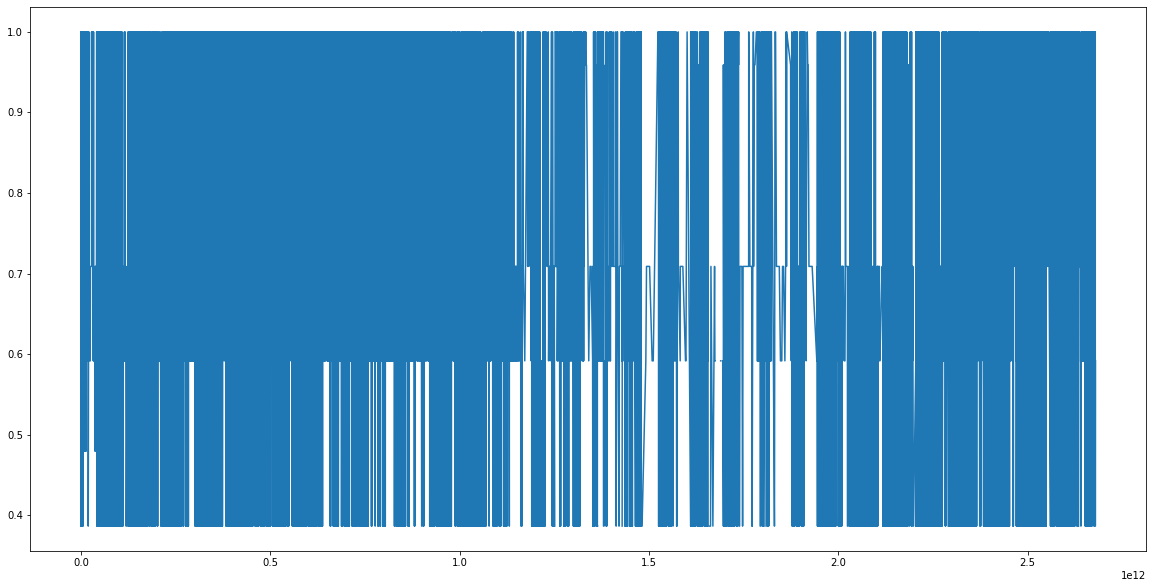

In [20]:
plt.figure(figsize=(20,10))
plt.plot(df.time, df.cpu)

In [ ]:
clusters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
for c in clusters:
    all_machines_query = """SELECT DISTINCT machine_id 
    FROM `google.com:google-cluster-data`.clusterdata_2019_"""+c+""".machine_events 
    ORDER BY machine_id"""
    query_job = client.query(all_machines_query)

    machines = query_job.result().to_dataframe()  # Waits for job to complete.
    machines.to_csv("/Users/arossi/Desktop/BigQuery/machines_"+c+".csv")
    
    for machine in machines.machine_id:
    query_machine = """SELECT CAST(start_time/300000000 as int) as slot, SUM(intervall/1000000) as intervall, COUNT(instance_index) as counts, SUM(pavgcpu * intervall) as avgcpu, SUM(pavgmem * intervall) as avgmem, SUM(pmaxcpu * intervall) as maxcpu, SUM(pmaxmem * intervall) as maxmem
FROM 
(SELECT machine_id, start_time as start_time, end_time-start_time as intervall, instance_index as instance_index, average_usage.cpus as pavgcpu, average_usage.memory as pavgmem, maximum_usage.cpus as pmaxcpu, maximum_usage.memory as pmaxmem
FROM `google.com:google-cluster-data`.clusterdata_2019_"""+c+""".instance_usage
WHERE machine_id = """+ str(machine)+""")
GROUP BY slot
ORDER BY slot
"""
    query_job = client.query(query_machine)

    machine_df = query_job.result().to_dataframe()  # Waits for job to complete.
#     if machine_df.shape[0]:
    print(machine, machine_df)
    machine_df.to_csv("/Users/arossi/Desktop/BigQuery/"+c+"/machine_"+str(machine).zfill(12)+".csv")
#         input()